In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU, RNN, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
from gcn import GCNLayer
from transformer import TransformerModel
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [22]:
dataset_environment_str = "T4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False
model_type = ModelType.RNN
method_prefix = "SubgraphBased"

In [23]:

eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=40_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=200_000)

[2023-12-13 17:25:13,111] {data.py:441} INFO - Loading graphs train
[2023-12-13 17:25:13,111] {data.py:412} INFO - Loading merged.csv
[2023-12-13 17:25:13,115] {data.py:415} INFO - Loaded merged.csv, 10 rows
[2023-12-13 17:25:13,111] {data.py:412} INFO - Loading merged.csv
[2023-12-13 17:25:13,115] {data.py:415} INFO - Loaded merged.csv, 10 rows
[2023-12-13 17:25:13,122] {data.py:421} INFO - Loaded mnasnet1_3.180_7.csv, 10 rows
[2023-12-13 17:25:13,123] {data.py:441} INFO - Loading graphs train
[2023-12-13 17:25:13,124] {data.py:412} INFO - Loading merged.csv
[2023-12-13 17:25:13,126] {data.py:415} INFO - Loaded merged.csv, 100 rows
[2023-12-13 17:25:13,171] {data.py:421} INFO - Loaded mnasnet1_3.180_7.csv, 100 rows


In [24]:
train_configs = {
    ModelType.MLPTestSubgraph.name: Config.from_dict({
        "model": "MLPTestSubgraph",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 20,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.LSTM.name: Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 20,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.RNN.name: Config.from_dict({
        "model": "RNN",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True,
            "hidden_size": 64
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 20,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GRU.name: Config.from_dict({
        "model": "GRU",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 20,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GCNSubgraph.name: Config.from_dict({
        "model": "GCNGrouping",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 20,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.Transformer.name: Config.from_dict({
        "model": "Transformer",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "nlayers": 6,
            "d_hid": 64,
            "dropout": 0.0
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 20,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [25]:
def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                        subgraph_node_size=conf.dataset_subgraph_node_size,
                                        step=conf.dataset_subgraph_step,
                                        dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [26]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]
    
    scaler_cls = conf.dataset_normalizer_cls

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler

scalers = get_scalers(train_ds)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers


In [27]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds


preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)


In [28]:

save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, method_prefix, 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)

In [29]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, method_prefix, 'train',
                           conf.dataset_normalization)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

Loading dataset T4_CPUALL SubgraphBased train Standard
Loading dataset T4_CPUALL SubgraphBased eval Standard
Loading scalers T4_CPUALL SubgraphBased train, Standard


In [30]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    def compute_graph_nodes_durations(outputs_, node_ids_str_):
            x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers
            node_to_durations = defaultdict(list)
            for i, output_ in enumerate(outputs_):
                node_ids = node_ids_str_[i]
                node_ids_ = node_ids.split("|")
                assert len(output_) == len(node_ids_)
                transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(output_)
                for i, node_id in enumerate(node_ids_):
                    node_to_durations[node_id].append(np.sum(transformed[i]))
            node_to_duration = {k: np.average(v) for k, v in node_to_durations.items()}
            return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(group_outputs, group_x_node_ids)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [31]:

def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(conf.device)
    return features, labels

In [32]:

class MLPTest_SubgraphModel(MModule):

    def __init__(self, x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.x_node_feature_count, self.x_node_feature_size, self.y_nodes_duration_count, self.y_nodes_duration_size \
            = x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=self.x_node_feature_count * self.x_node_feature_size,
                                       out_features=64)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=64,
                                       out_features=32)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(32, self.y_nodes_duration_count * self.y_nodes_duration_size)
        self.loss_fn = L1Loss()

    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        X = self.flatten(X)
        X = self.linear1(X)
        X = self.relu1(X)
        X = self.linear2(X)
        X = self.relu2(X)
        Y = self.output(X)
        Y = torch.reshape(Y, (-1, self.y_nodes_duration_count, self.y_nodes_duration_size))
        return Y

    def compute_loss(self, outputs, Y):
        nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, nodes_durations)
        return loss

def init_MLPTestSubgraph_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_count = len(sample_x_dict["x_subgraph_feature"])
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_duration_count = len(sample_y_dict["y_nodes_durations"])
    y_nodes_duration_size = len(sample_y_dict["y_nodes_durations"][0])
    return MLPTest_SubgraphModel(x_node_feature_count,
                                    x_node_feature_size,
                                    y_nodes_duration_count,
                                    y_nodes_duration_size)


In [33]:

class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "num_layers": [4, 6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }
        
    def forward(self, X):
        X = X["x_subgraph_feature"]
        print(X.shape)
        out, _ = self.lstm(X)
        
        Y = self.project(out)
        print(Y.shape)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        print(node_durations.shape)
        loss = self.loss_fn(outputs, node_durations)
        return loss

def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


In [34]:


class GRUModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.gru = GRU(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                       bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "num_layers": [4,  6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }
        
    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.gru(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_GRU_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    return GRUModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


In [35]:


class GCNSubgraphModel(MModule):
    def __init__(self, dim_feats, dim_h, dim_out, n_layers, dropout):
        super(GCNSubgraphModel, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GCNLayer(dim_feats, dim_h, F.relu, 0))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GCNLayer(dim_h, dim_h, F.relu, dropout))
        # output layer
        self.layers.append(GCNLayer(dim_h, dim_out, None, dropout))
        self.loss_fn = L1Loss()
    
    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "n_layers": [4, 6, 8],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }
        
    def forward(self, X):
        adj, features = X["x_adj_matrix"], X["x_subgraph_feature"]
        h = features
        for layer in self.layers:
            h = layer(adj, h)
        return h

    def compute_loss(self, outputs, Y) -> torch.Tensor:
        y_nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, y_nodes_durations)
        return loss


def init_GCNSubgraph_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "dim_h": None,
            "n_layers": 2,
            "dropout": 0.1,
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    if final_params["dim_h"] is None:
        final_params["dim_h"] = x_node_feature_size
    return GCNSubgraphModel(
        dim_feats=x_node_feature_size,
        dim_out=y_nodes_durations_len,
        **final_params
    )

In [36]:
def init_Transformer_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        nhead: int = 8
        d_hid: int = 512
        nlayers: int = 6
        dropout: float = 0.5
        return {
            "nhead": nhead,
            "d_hid": d_hid,
            "nlayers": nlayers,
            "dropout": dropout
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)

    nhead = final_params["nhead"]
    while x_node_feature_size % nhead != 0:
        nhead -= 1
    if nhead != final_params["nhead"]:
        final_params["nhead"] = nhead
        logging.info(f"Transformer nhead set to {nhead}.")
        conf.model_params["nhead"] = nhead

    return TransformerModel(
        d_model=x_node_feature_size,
        output_d=nodes_durations_len,
        **final_params
    )

In [37]:
class RNNModel(MModule):
    def __init__(self, feature_size, nodes_durations_len,hidden_size, num_layers, bidirectional, **kwargs):
        print(f'feature_size: {feature_size}, nodes_durations_len: {nodes_durations_len}, num_layers: {num_layers}, bidirectional: {bidirectional}')
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.input_size = feature_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.node_durations_len = 2
        self.rnn = RNN(input_size=feature_size, 
                       hidden_size=hidden_size, 
                       num_layers=num_layers,
                          batch_first=True, 
                       bidirectional=bidirectional)
        
        
        self.project = torch.nn.Linear(in_features=self.hidden_size * self.num_directions, out_features=nodes_durations_len)
        
        self.loss_fn = L1Loss()

    @staticmethod 
    def grid_search_model_params()->Dict[str, List[Any]]:
        return {
            "n_layers": [4, 6, 8],
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"] # (batch_size, subgraph_size(seq_len), input_size)
        batch_size = X.size(0)
        hidden = self.init_hidden(batch_size).cuda()
        out, _ = self.rnn(X, hidden) #(seq_len, batchsize, hidden_size)
        Y = self.project(out) # 16, 10, 2
        return Y

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)
        return hidden

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss

def init_RNN_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "hidden_size": 64,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return RNNModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


[2023-12-13 17:25:13,428] {executor.py:148} INFO - ModelType.MLPTestSubgraph start single training.
[2023-12-13 17:25:13,429] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 0


  0%|          | 0/1 [00:00<?, ?it/s]

[2023-12-13 17:25:14,075] {executor.py:111} INFO - ModelType.MLPTestSubgraph trained for 0.646836786 seconds.
[2023-12-13 17:25:14,076] {executor.py:112} INFO - ModelType.MLPTestSubgraph eval at step 0.
[2023-12-13 17:25:14,079] {executor.py:116} INFO - ModelType.MLPTestSubgraph train loss: 0.8138779997825623, eval metrics: {'eval_loss': 1.3668071031570435, 'MRE': 0.31465672985997034, 'MAE': 0.31465672985997034, 'RMSE': 3.9873810551757813}
[2023-12-13 17:25:14,079] {executor.py:187} INFO - Saving model at step 0 with loss 0.8138779997825623,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLPTestSubgraph/single_train2023-12-13_17-25-13


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

[2023-12-13 17:25:14,083] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 1



100%|██████████| 1/1 [00:00<00:00, 431.02it/s]

[2023-12-13 17:25:14,087] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 2



100%|██████████| 1/1 [00:00<00:00, 458.90it/s]

[2023-12-13 17:25:14,091] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 3



100%|██████████| 1/1 [00:00<00:00, 455.36it/s]

[2023-12-13 17:25:14,095] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 4



100%|██████████| 1/1 [00:00<00:00, 481.11it/s]

[2023-12-13 17:25:14,099] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 5



100%|██████████| 1/1 [00:00<00:00, 488.56it/s]

[2023-12-13 17:25:14,102] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 6



100%|██████████| 1/1 [00:00<00:00, 499.32it/s]

[2023-12-13 17:25:14,106] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 7



100%|██████████| 1/1 [00:00<00:00, 483.66it/s]

[2023-12-13 17:25:14,110] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 8



100%|██████████| 1/1 [00:00<00:00, 465.21it/s]

[2023-12-13 17:25:14,114] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 9



100%|██████████| 1/1 [00:00<00:00, 493.62it/s]

[2023-12-13 17:25:14,117] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 10



100%|██████████| 1/1 [00:00<00:00, 487.14it/s]

[2023-12-13 17:25:14,121] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 11



100%|██████████| 1/1 [00:00<00:00, 487.88it/s]

[2023-12-13 17:25:14,125] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 12



100%|██████████| 1/1 [00:00<00:00, 501.23it/s]

[2023-12-13 17:25:14,128] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 13



100%|██████████| 1/1 [00:00<00:00, 508.40it/s]

[2023-12-13 17:25:14,132] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 14



100%|██████████| 1/1 [00:00<00:00, 487.03it/s]

[2023-12-13 17:25:14,136] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 15



100%|██████████| 1/1 [00:00<00:00, 503.46it/s]

[2023-12-13 17:25:14,140] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 16



100%|██████████| 1/1 [00:00<00:00, 503.34it/s]

[2023-12-13 17:25:14,143] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 17



100%|██████████| 1/1 [00:00<00:00, 457.44it/s]

[2023-12-13 17:25:14,147] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 18



100%|██████████| 1/1 [00:00<00:00, 502.97it/s]

[2023-12-13 17:25:14,151] {executor.py:150} INFO - ModelType.MLPTestSubgraph training epoch 19



100%|██████████| 1/1 [00:00<00:00, 483.60it/s]


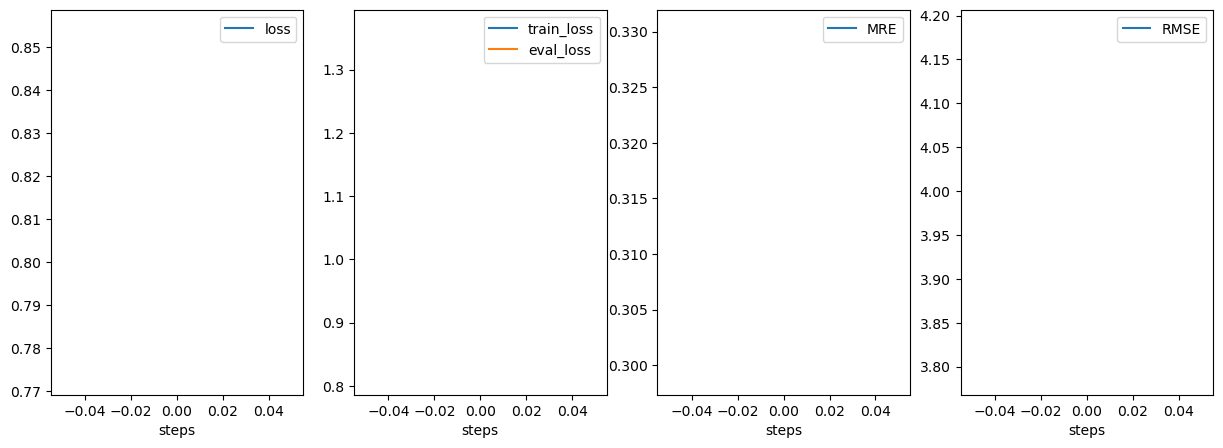

In [38]:
init_model_funcs = {
    ModelType.Transformer.name: init_Transformer_model,
    ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
    ModelType.GRU.name: init_GRU_model,
    ModelType.LSTM.name: init_LSTM_model,
    ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
    ModelType.RNN.name: init_RNN_model,
}

# model_type = ModelType.MLPTestSubgraph
# model_type = ModelType.LSTM
# model_type = ModelType.GRU
model_type = ModelType.RNN
init_model = init_model_funcs[model_type.name]


model_type = ModelType.MLPTestSubgraph
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)



{'num_layers': 5, 'bidirectional': True}
{'num_layers': 5, 'bidirectional': True}
[2023-12-13 17:25:15,015] {executor.py:50} INFO - ModelType.LSTM grid search on common params: True, model specific grid search params name: {'num_layers': [4, 6, 8], 'bidirectional': [True, False], 'learning_rate': [0.001, 0.0001, 1e-05], 'batch_size': [32, 64], 'epochs': [20], 'optimizer': ['Adam', 'SGD']}.
[2023-12-13 17:25:15,016] {executor.py:52} INFO - total search items: 72.
[[42], [32], [False], ['T4_CPUALL'], [{'duration_summed': False}], [10], [20], [5000], [1e-05], [{'learning_rate': 0.005, 'meta_learning_rate': 0.001, 'meta_train_steps': 1000, 'meta_task_per_step': 8, 'meta_fast_adaption_step': 5, 'meta_dataset_train_environment_strs': ['T4_CPUALL'], 'meta_dataset_eval_environment_strs': ['T4_CPUALL']}], ['T4_CPUALL'], ['RNN'], [{'num_layers': 5, 'bidirectional': True, 'hidden_size': 64}], ['Adam']]
[2023-12-13 17:25:15,016] {executor.py:82} INFO - LSTM grid search 1/72 starts. curr time usage

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,334] {executor.py:111} INFO - ModelType.LSTM trained for 0.308482284 seconds.
[2023-12-13 17:25:15,335] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:15,338] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7990199327468872, eval metrics: {'eval_loss': 1.4211790561676025, 'MRE': 0.3426957545722935, 'MAE': 0.3426957545722935, 'RMSE': 4.342696118652343}
[2023-12-13 17:25:15,338] {executor.py:187} INFO - Saving model at step 0 with loss 0.7990199327468872,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-15


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

[2023-12-13 17:25:15,345] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 124.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,355] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,364] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,373] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,381] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 128.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,391] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,400] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 137.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,409] {executor.py:150} INFO - ModelType.LSTM training epoch 8



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 129.39it/s]

[2023-12-13 17:25:15,418] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 136.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,427] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 130.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,436] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 143.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,445] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,454] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,463] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 134.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,472] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,481] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 129.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,490] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,499] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,507] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 122.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:15,734] {executor.py:93} INFO - LSTM grid search 1/72 done. training duration: 0.72s
[2023-12-13 17:25:15,735] {executor.py:82} INFO - LSTM grid search 2/72 starts. curr time usage: 0.72s
[2023-12-13 17:25:15,735] {executor.py:84} INFO - LSTM grid search conf 2/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,754] {executor.py:111} INFO - ModelType.LSTM trained for 0.009703296 seconds.
[2023-12-13 17:25:15,754] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:15,757] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8000226616859436, eval metrics: {'eval_loss': 1.4054630994796753, 'MRE': 0.33539016325182663, 'MAE': 0.33539016325182663, 'RMSE': 4.250118481933594}
[2023-12-13 17:25:15,757] {executor.py:187} INFO - Saving model at step 0 with loss 0.8000226616859436,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-15


100%|██████████| 1/1 [00:00<00:00, 57.98it/s]

[2023-12-13 17:25:15,764] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 122.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,774] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 134.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,783] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 132.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,792] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 131.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,802] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 135.29it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,811] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 132.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,820] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 130.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,829] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 135.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,838] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 135.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,848] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 134.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,857] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 133.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,866] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 133.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,875] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 135.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,884] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 135.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,893] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,902] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 139.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,911] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 136.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,920] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 138.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:15,929] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 131.04it/s]


[2023-12-13 17:25:16,151] {executor.py:93} INFO - LSTM grid search 2/72 done. training duration: 0.42s
[2023-12-13 17:25:16,152] {executor.py:82} INFO - LSTM grid search 3/72 starts. curr time usage: 1.14s
[2023-12-13 17:25:16,152] {executor.py:84} INFO - LSTM grid search conf 3/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,171] {executor.py:111} INFO - ModelType.LSTM trained for 0.01028352 seconds.
[2023-12-13 17:25:16,172] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:16,175] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7855387926101685, eval metrics: {'eval_loss': 1.4188941717147827, 'MRE': 0.37315372881449954, 'MAE': 0.37315372881449954, 'RMSE': 4.728664502441406}
[2023-12-13 17:25:16,175] {executor.py:187} INFO - Saving model at step 0 with loss 0.7855387926101685,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-16


100%|██████████| 1/1 [00:00<00:00, 55.49it/s]

[2023-12-13 17:25:16,181] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,190] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,199] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 129.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,209] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 122.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,220] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 124.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,234] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 131.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,243] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 130.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,253] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 135.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,262] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 133.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,271] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 135.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,280] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 134.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,289] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 136.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,298] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 132.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,307] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 134.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,317] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 131.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,326] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 136.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,335] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 136.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,344] {executor.py:150} INFO - ModelType.LSTM training epoch 18



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 130.87it/s]

[2023-12-13 17:25:16,353] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 88.09it/s]


[2023-12-13 17:25:16,591] {executor.py:93} INFO - LSTM grid search 3/72 done. training duration: 0.44s
[2023-12-13 17:25:16,591] {executor.py:82} INFO - LSTM grid search 4/72 starts. curr time usage: 1.58s
[2023-12-13 17:25:16,592] {executor.py:84} INFO - LSTM grid search conf 4/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,611] {executor.py:111} INFO - ModelType.LSTM trained for 0.009822771 seconds.
[2023-12-13 17:25:16,611] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:16,614] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8234685063362122, eval metrics: {'eval_loss': 1.421379566192627, 'MRE': 0.29403943613888656, 'MAE': 0.29403943613888656, 'RMSE': 3.7261153691406257}
[2023-12-13 17:25:16,615] {executor.py:187} INFO - Saving model at step 0 with loss 0.8234685063362122,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-16


100%|██████████| 1/1 [00:00<00:00, 54.86it/s]

[2023-12-13 17:25:16,621] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 131.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,631] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 131.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,640] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 131.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,649] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,658] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 137.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,667] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,676] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 134.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,685] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 136.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,694] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 135.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,703] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 136.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,712] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 136.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,721] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,730] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 135.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,739] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 138.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,748] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,757] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 132.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,766] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,774] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 138.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:16,783] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 135.88it/s]


[2023-12-13 17:25:17,168] {executor.py:93} INFO - LSTM grid search 4/72 done. training duration: 0.58s
[2023-12-13 17:25:17,169] {executor.py:82} INFO - LSTM grid search 5/72 starts. curr time usage: 2.15s
[2023-12-13 17:25:17,169] {executor.py:84} INFO - LSTM grid search conf 5/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,189] {executor.py:111} INFO - ModelType.LSTM trained for 0.010570667 seconds.
[2023-12-13 17:25:17,189] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:17,192] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7960537075996399, eval metrics: {'eval_loss': 1.4143890142440796, 'MRE': 0.3471009751994914, 'MAE': 0.3471009751994914, 'RMSE': 4.398519788085938}
[2023-12-13 17:25:17,193] {executor.py:187} INFO - Saving model at step 0 with loss 0.7960537075996399,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-17


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]

[2023-12-13 17:25:17,199] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,208] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,217] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 141.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,226] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,235] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,243] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,252] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 136.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,261] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 138.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,270] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 137.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,279] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 136.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,288] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,297] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,306] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 137.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,315] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 132.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,324] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 134.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,333] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 137.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,342] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 132.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,351] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 136.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,360] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 138.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:17,584] {executor.py:93} INFO - LSTM grid search 5/72 done. training duration: 0.42s
[2023-12-13 17:25:17,585] {executor.py:82} INFO - LSTM grid search 6/72 starts. curr time usage: 2.57s
[2023-12-13 17:25:17,585] {executor.py:84} INFO - LSTM grid search conf 6/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,605] {executor.py:111} INFO - ModelType.LSTM trained for 0.010026344 seconds.
[2023-12-13 17:25:17,605] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:17,608] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7925184369087219, eval metrics: {'eval_loss': 1.4025042057037354, 'MRE': 0.35320278482891276, 'MAE': 0.35320278482891276, 'RMSE': 4.475842908203125}
[2023-12-13 17:25:17,608] {executor.py:187} INFO - Saving model at step 0 with loss 0.7925184369087219,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-17


100%|██████████| 1/1 [00:00<00:00, 54.69it/s]

[2023-12-13 17:25:17,615] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,624] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,633] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,642] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 140.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,651] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 141.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,660] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 136.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,669] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 135.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,678] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 135.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,687] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 136.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,696] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,705] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 137.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,714] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,723] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 138.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,732] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 135.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,741] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 136.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,750] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,759] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,767] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:17,776] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 136.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:18,003] {executor.py:93} INFO - LSTM grid search 6/72 done. training duration: 0.42s
[2023-12-13 17:25:18,003] {executor.py:82} INFO - LSTM grid search 7/72 starts. curr time usage: 2.99s
[2023-12-13 17:25:18,004] {executor.py:84} INFO - LSTM grid search conf 7/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,023] {executor.py:111} INFO - ModelType.LSTM trained for 0.009853076 seconds.
[2023-12-13 17:25:18,023] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:18,026] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7985493540763855, eval metrics: {'eval_loss': 1.3902294635772705, 'MRE': 0.3348472694132003, 'MAE': 0.3348472694132003, 'RMSE': 4.243238843261718}
[2023-12-13 17:25:18,026] {executor.py:187} INFO - Saving model at step 0 with loss 0.7985493540763855,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-18


100%|██████████| 1/1 [00:00<00:00, 57.43it/s]

[2023-12-13 17:25:18,032] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 131.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,042] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 133.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,051] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,060] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,069] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 143.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,077] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 142.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,086] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,094] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 137.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,103] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,112] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,121] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 133.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,130] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 135.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,139] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 135.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,148] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 135.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,157] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 135.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,167] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 134.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,176] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 131.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,185] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 135.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,194] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 134.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:18,429] {executor.py:93} INFO - LSTM grid search 7/72 done. training duration: 0.43s
[2023-12-13 17:25:18,430] {executor.py:82} INFO - LSTM grid search 8/72 starts. curr time usage: 3.41s
[2023-12-13 17:25:18,430] {executor.py:84} INFO - LSTM grid search conf 8/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,449] {executor.py:111} INFO - ModelType.LSTM trained for 0.010151979 seconds.
[2023-12-13 17:25:18,450] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:18,452] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8183495402336121, eval metrics: {'eval_loss': 1.3996456861495972, 'MRE': 0.2954404380472059, 'MAE': 0.2954404380472059, 'RMSE': 3.7438690922851556}
[2023-12-13 17:25:18,453] {executor.py:187} INFO - Saving model at step 0 with loss 0.8183495402336121,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-18


100%|██████████| 1/1 [00:00<00:00, 53.86it/s]

[2023-12-13 17:25:18,460] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 126.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,469] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 133.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,479] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 131.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,488] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 132.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,497] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 132.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,507] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 134.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,516] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 135.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,525] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 137.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,534] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 135.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,543] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,552] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 134.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,561] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 136.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,570] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 139.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,578] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 136.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,587] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 134.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,597] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 135.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,606] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 139.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,614] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 136.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,623] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 131.71it/s]


[2023-12-13 17:25:18,847] {executor.py:93} INFO - LSTM grid search 8/72 done. training duration: 0.42s
[2023-12-13 17:25:18,848] {executor.py:82} INFO - LSTM grid search 9/72 starts. curr time usage: 3.83s
[2023-12-13 17:25:18,848] {executor.py:84} INFO - LSTM grid search conf 9/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "mod

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,867] {executor.py:111} INFO - ModelType.LSTM trained for 0.009784403 seconds.
[2023-12-13 17:25:18,867] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:18,870] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8164798021316528, eval metrics: {'eval_loss': 1.415814757347107, 'MRE': 0.3059796568087716, 'MAE': 0.3059796568087716, 'RMSE': 3.877423779785156}
[2023-12-13 17:25:18,870] {executor.py:187} INFO - Saving model at step 0 with loss 0.8164798021316528,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-18


100%|██████████| 1/1 [00:00<00:00, 55.43it/s]

[2023-12-13 17:25:18,877] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,887] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,896] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,904] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,913] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 135.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,922] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 134.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,932] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 134.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,941] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 136.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,950] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 135.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,959] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 137.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,968] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 135.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,977] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,985] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 137.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:18,994] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 137.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,003] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,012] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 139.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,021] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 138.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,030] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,039] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:19,269] {executor.py:93} INFO - LSTM grid search 9/72 done. training duration: 0.42s
[2023-12-13 17:25:19,270] {executor.py:82} INFO - LSTM grid search 10/72 starts. curr time usage: 4.25s
[2023-12-13 17:25:19,270] {executor.py:84} INFO - LSTM grid search conf 10/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "m

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,289] {executor.py:111} INFO - ModelType.LSTM trained for 0.009980116 seconds.
[2023-12-13 17:25:19,289] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:19,292] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8200474977493286, eval metrics: {'eval_loss': 1.4177818298339844, 'MRE': 0.29867846774679957, 'MAE': 0.29867846774679957, 'RMSE': 3.7849019291992185}
[2023-12-13 17:25:19,292] {executor.py:187} INFO - Saving model at step 0 with loss 0.8200474977493286,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-19


100%|██████████| 1/1 [00:00<00:00, 56.89it/s]

[2023-12-13 17:25:19,299] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 128.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,308] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 142.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,317] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 143.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,326] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 143.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,334] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 143.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,343] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.59it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,352] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,360] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,369] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 147.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,377] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 146.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,386] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 145.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,394] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,403] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,412] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 144.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,420] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,429] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,438] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,447] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,455] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 139.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:19,687] {executor.py:93} INFO - LSTM grid search 10/72 done. training duration: 0.42s
[2023-12-13 17:25:19,688] {executor.py:82} INFO - LSTM grid search 11/72 starts. curr time usage: 4.67s
[2023-12-13 17:25:19,688] {executor.py:84} INFO - LSTM grid search conf 11/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,707] {executor.py:111} INFO - ModelType.LSTM trained for 0.009698795 seconds.
[2023-12-13 17:25:19,707] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:19,710] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8071291446685791, eval metrics: {'eval_loss': 1.3952997922897339, 'MRE': 0.31896240357407046, 'MAE': 0.31896240357407046, 'RMSE': 4.041943250000001}
[2023-12-13 17:25:19,710] {executor.py:187} INFO - Saving model at step 0 with loss 0.8071291446685791,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-19


100%|██████████| 1/1 [00:00<00:00, 52.43it/s]

[2023-12-13 17:25:19,718] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,727] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 142.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,736] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 134.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,745] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,754] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 137.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,763] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,772] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,781] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 144.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,789] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 138.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,798] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 146.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,807] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 147.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,815] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 147.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,824] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 125.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,833] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 131.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,843] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,852] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,861] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 142.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,869] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:19,878] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 142.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:20,263] {executor.py:93} INFO - LSTM grid search 11/72 done. training duration: 0.58s
[2023-12-13 17:25:20,264] {executor.py:82} INFO - LSTM grid search 12/72 starts. curr time usage: 5.25s
[2023-12-13 17:25:20,264] {executor.py:84} INFO - LSTM grid search conf 12/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,283] {executor.py:111} INFO - ModelType.LSTM trained for 0.009473749 seconds.
[2023-12-13 17:25:20,283] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:20,286] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8021302819252014, eval metrics: {'eval_loss': 1.4116731882095337, 'MRE': 0.3332854839238364, 'MAE': 0.3332854839238364, 'RMSE': 4.22344764453125}
[2023-12-13 17:25:20,286] {executor.py:187} INFO - Saving model at step 0 with loss 0.8021302819252014,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-20


100%|██████████| 1/1 [00:00<00:00, 57.29it/s]

[2023-12-13 17:25:20,293] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,302] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,311] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,320] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,328] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 128.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,338] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,347] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 141.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,356] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 137.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,365] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 138.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,373] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,382] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,391] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 142.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,400] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 144.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,408] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 146.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,417] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,425] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,434] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 144.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,442] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 146.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,451] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 138.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:20,681] {executor.py:93} INFO - LSTM grid search 12/72 done. training duration: 0.42s
[2023-12-13 17:25:20,681] {executor.py:82} INFO - LSTM grid search 13/72 starts. curr time usage: 5.67s
[2023-12-13 17:25:20,682] {executor.py:84} INFO - LSTM grid search conf 13/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,701] {executor.py:111} INFO - ModelType.LSTM trained for 0.009686016 seconds.
[2023-12-13 17:25:20,701] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:20,704] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8122022151947021, eval metrics: {'eval_loss': 1.4059609174728394, 'MRE': 0.3099612732430124, 'MAE': 0.3099612732430124, 'RMSE': 3.927879468261718}
[2023-12-13 17:25:20,704] {executor.py:187} INFO - Saving model at step 0 with loss 0.8122022151947021,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-20


100%|██████████| 1/1 [00:00<00:00, 54.24it/s]

[2023-12-13 17:25:20,711] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 128.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,721] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 134.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,730] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 132.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,739] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,748] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 136.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,757] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,766] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 139.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,775] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 146.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,783] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 148.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,792] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,800] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 148.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,809] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 146.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,817] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 144.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,826] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,834] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,843] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,852] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,860] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:20,869] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 142.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:21,108] {executor.py:93} INFO - LSTM grid search 13/72 done. training duration: 0.43s
[2023-12-13 17:25:21,109] {executor.py:82} INFO - LSTM grid search 14/72 starts. curr time usage: 6.09s
[2023-12-13 17:25:21,110] {executor.py:84} INFO - LSTM grid search conf 14/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,129] {executor.py:111} INFO - ModelType.LSTM trained for 0.010235735 seconds.
[2023-12-13 17:25:21,130] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:21,132] {executor.py:116} INFO - ModelType.LSTM train loss: 0.824864387512207, eval metrics: {'eval_loss': 1.391194224357605, 'MRE': 0.28020593606179584, 'MAE': 0.28020593606179584, 'RMSE': 3.5508150151367186}
[2023-12-13 17:25:21,133] {executor.py:187} INFO - Saving model at step 0 with loss 0.824864387512207,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-21


100%|██████████| 1/1 [00:00<00:00, 55.73it/s]

[2023-12-13 17:25:21,139] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,148] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,157] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,166] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,175] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,184] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,193] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,202] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,210] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,219] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 143.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,228] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,237] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,246] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,254] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,263] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 108.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,274] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 137.59it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,283] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 137.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,292] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,301] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 146.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:21,526] {executor.py:93} INFO - LSTM grid search 14/72 done. training duration: 0.42s
[2023-12-13 17:25:21,527] {executor.py:82} INFO - LSTM grid search 15/72 starts. curr time usage: 6.51s
[2023-12-13 17:25:21,527] {executor.py:84} INFO - LSTM grid search conf 15/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,547] {executor.py:111} INFO - ModelType.LSTM trained for 0.011449968 seconds.
[2023-12-13 17:25:21,548] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:21,550] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7876963019371033, eval metrics: {'eval_loss': 1.4062004089355469, 'MRE': 0.36315525574354196, 'MAE': 0.36315525574354196, 'RMSE': 4.601962231933594}
[2023-12-13 17:25:21,551] {executor.py:187} INFO - Saving model at step 0 with loss 0.7876963019371033,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-21


100%|██████████| 1/1 [00:00<00:00, 50.59it/s]

[2023-12-13 17:25:21,558] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,567] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 139.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,576] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.29it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,584] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,593] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 146.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,602] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 145.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,610] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 147.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,618] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,627] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,636] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 143.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,644] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,653] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,662] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,670] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 144.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,679] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,688] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 143.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,697] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 134.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,706] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,715] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:21,947] {executor.py:93} INFO - LSTM grid search 15/72 done. training duration: 0.42s
[2023-12-13 17:25:21,948] {executor.py:82} INFO - LSTM grid search 16/72 starts. curr time usage: 6.93s
[2023-12-13 17:25:21,948] {executor.py:84} INFO - LSTM grid search conf 16/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,968] {executor.py:111} INFO - ModelType.LSTM trained for 0.010319628 seconds.
[2023-12-13 17:25:21,968] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:21,971] {executor.py:116} INFO - ModelType.LSTM train loss: 0.818115234375, eval metrics: {'eval_loss': 1.416303277015686, 'MRE': 0.3018340779197371, 'MAE': 0.3018340779197371, 'RMSE': 3.824890332519532}
[2023-12-13 17:25:21,972] {executor.py:187} INFO - Saving model at step 0 with loss 0.818115234375,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-21


100%|██████████| 1/1 [00:00<00:00, 49.88it/s]

[2023-12-13 17:25:21,979] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 126.29it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,989] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 135.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:21,998] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,007] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 132.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,018] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,027] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,036] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,045] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,054] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 135.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,063] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,072] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,080] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,089] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 146.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,098] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 143.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,106] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 143.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,115] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,123] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 145.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,132] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,141] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 135.69it/s]


[2023-12-13 17:25:22,380] {executor.py:93} INFO - LSTM grid search 16/72 done. training duration: 0.43s
[2023-12-13 17:25:22,381] {executor.py:82} INFO - LSTM grid search 17/72 starts. curr time usage: 7.36s
[2023-12-13 17:25:22,381] {executor.py:84} INFO - LSTM grid search conf 17/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,401] {executor.py:111} INFO - ModelType.LSTM trained for 0.010157652 seconds.
[2023-12-13 17:25:22,402] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:22,404] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8154085874557495, eval metrics: {'eval_loss': 1.3771461248397827, 'MRE': 0.29685522952453036, 'MAE': 0.29685522952453036, 'RMSE': 3.761797559082032}
[2023-12-13 17:25:22,405] {executor.py:187} INFO - Saving model at step 0 with loss 0.8154085874557495,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-22


100%|██████████| 1/1 [00:00<00:00, 55.33it/s]

[2023-12-13 17:25:22,411] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,420] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 142.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,429] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,438] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 144.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,446] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,455] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,464] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 116.07it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,475] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 137.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,484] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 138.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,493] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,502] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,511] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,520] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,528] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,537] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 148.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,546] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,555] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 136.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,564] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,573] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 149.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:22,807] {executor.py:93} INFO - LSTM grid search 17/72 done. training duration: 0.43s
[2023-12-13 17:25:22,808] {executor.py:82} INFO - LSTM grid search 18/72 starts. curr time usage: 7.79s
[2023-12-13 17:25:22,808] {executor.py:84} INFO - LSTM grid search conf 18/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,827] {executor.py:111} INFO - ModelType.LSTM trained for 0.0099647 seconds.
[2023-12-13 17:25:22,828] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:22,831] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7898362278938293, eval metrics: {'eval_loss': 1.4095367193222046, 'MRE': 0.359762472690076, 'MAE': 0.359762472690076, 'RMSE': 4.558968335449219}
[2023-12-13 17:25:22,831] {executor.py:187} INFO - Saving model at step 0 with loss 0.7898362278938293,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-22


100%|██████████| 1/1 [00:00<00:00, 52.57it/s]

[2023-12-13 17:25:22,838] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,848] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,857] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,866] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,875] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 143.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,884] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 142.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,892] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,901] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,910] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,919] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 142.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,928] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 145.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,936] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,945] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,954] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 143.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,963] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,971] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 143.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,980] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 146.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,989] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 144.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:22,997] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 146.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:23,228] {executor.py:93} INFO - LSTM grid search 18/72 done. training duration: 0.42s
[2023-12-13 17:25:23,229] {executor.py:82} INFO - LSTM grid search 19/72 starts. curr time usage: 8.21s
[2023-12-13 17:25:23,229] {executor.py:84} INFO - LSTM grid search conf 19/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,247] {executor.py:111} INFO - ModelType.LSTM trained for 0.009402829 seconds.
[2023-12-13 17:25:23,248] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:23,250] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8191102147102356, eval metrics: {'eval_loss': 1.4204225540161133, 'MRE': 0.3014817045811347, 'MAE': 0.3014817045811347, 'RMSE': 3.8204250004882816}
[2023-12-13 17:25:23,251] {executor.py:187} INFO - Saving model at step 0 with loss 0.8191102147102356,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-23


100%|██████████| 1/1 [00:00<00:00, 57.92it/s]

[2023-12-13 17:25:23,257] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,266] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,275] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 145.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,284] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 143.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,293] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,301] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 142.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,310] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 148.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,319] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,327] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,336] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 142.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,345] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,353] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,362] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 147.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,371] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 148.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,379] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,388] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 149.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,396] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 145.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,405] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,414] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:23,647] {executor.py:93} INFO - LSTM grid search 19/72 done. training duration: 0.42s
[2023-12-13 17:25:23,648] {executor.py:82} INFO - LSTM grid search 20/72 starts. curr time usage: 8.63s
[2023-12-13 17:25:23,648] {executor.py:84} INFO - LSTM grid search conf 20/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,666] {executor.py:111} INFO - ModelType.LSTM trained for 0.009438715 seconds.
[2023-12-13 17:25:23,667] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:23,670] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7903345823287964, eval metrics: {'eval_loss': 1.4192453622817993, 'MRE': 0.36305132102137544, 'MAE': 0.36305132102137544, 'RMSE': 4.600645154296876}
[2023-12-13 17:25:23,670] {executor.py:187} INFO - Saving model at step 0 with loss 0.7903345823287964,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-23


100%|██████████| 1/1 [00:00<00:00, 56.33it/s]

[2023-12-13 17:25:23,677] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,686] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 141.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,695] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 146.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,704] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 143.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,712] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 142.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,721] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,730] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,739] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 147.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,747] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 147.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,756] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,764] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,773] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,782] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,791] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,799] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,808] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,817] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 147.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,825] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 145.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:23,834] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 147.29it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:24,296] {executor.py:93} INFO - LSTM grid search 20/72 done. training duration: 0.65s
[2023-12-13 17:25:24,296] {executor.py:82} INFO - LSTM grid search 21/72 starts. curr time usage: 9.28s
[2023-12-13 17:25:24,297] {executor.py:84} INFO - LSTM grid search conf 21/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,316] {executor.py:111} INFO - ModelType.LSTM trained for 0.009833526 seconds.
[2023-12-13 17:25:24,316] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:24,319] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8074712753295898, eval metrics: {'eval_loss': 1.3963127136230469, 'MRE': 0.3173302349300183, 'MAE': 0.3173302349300183, 'RMSE': 4.021260144531251}
[2023-12-13 17:25:24,319] {executor.py:187} INFO - Saving model at step 0 with loss 0.8074712753295898,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-24


100%|██████████| 1/1 [00:00<00:00, 57.61it/s]

[2023-12-13 17:25:24,325] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,335] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,344] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,352] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,361] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,370] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,379] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 139.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,388] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,397] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,405] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,414] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 139.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,423] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 139.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,432] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,441] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 140.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,449] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,458] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 138.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,467] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 136.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,476] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 137.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,485] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 136.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])



/root/guohao/repos/DLT-perf-model/notebooks/executor.py:227: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))


[2023-12-13 17:25:24,732] {executor.py:93} INFO - LSTM grid search 21/72 done. training duration: 0.44s
[2023-12-13 17:25:24,733] {executor.py:82} INFO - LSTM grid search 22/72 starts. curr time usage: 9.72s
[2023-12-13 17:25:24,733] {executor.py:84} INFO - LSTM grid search conf 22/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    "

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,752] {executor.py:111} INFO - ModelType.LSTM trained for 0.009807466 seconds.
[2023-12-13 17:25:24,752] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:24,755] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7946404814720154, eval metrics: {'eval_loss': 1.4037431478500366, 'MRE': 0.34731004394619336, 'MAE': 0.34731004394619336, 'RMSE': 4.401169141113282}
[2023-12-13 17:25:24,755] {executor.py:187} INFO - Saving model at step 0 with loss 0.7946404814720154,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-24


100%|██████████| 1/1 [00:00<00:00, 55.70it/s]

[2023-12-13 17:25:24,762] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 127.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,772] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 130.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,781] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,790] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,799] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,808] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 137.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,817] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 136.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,826] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,835] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 138.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,844] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 138.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,853] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 138.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,862] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 135.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,871] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 138.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,880] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 136.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,889] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,898] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 134.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,907] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 136.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,916] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 132.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:24,926] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 134.09it/s]


[2023-12-13 17:25:25,164] {executor.py:93} INFO - LSTM grid search 22/72 done. training duration: 0.43s
[2023-12-13 17:25:25,164] {executor.py:82} INFO - LSTM grid search 23/72 starts. curr time usage: 10.15s
[2023-12-13 17:25:25,165] {executor.py:84} INFO - LSTM grid search conf 23/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,184] {executor.py:111} INFO - ModelType.LSTM trained for 0.009948783 seconds.
[2023-12-13 17:25:25,184] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:25,187] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7810642719268799, eval metrics: {'eval_loss': 1.4166595935821533, 'MRE': 0.383885086411816, 'MAE': 0.383885086411816, 'RMSE': 4.864654004394532}
[2023-12-13 17:25:25,187] {executor.py:187} INFO - Saving model at step 0 with loss 0.7810642719268799,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-25


100%|██████████| 1/1 [00:00<00:00, 56.31it/s]

[2023-12-13 17:25:25,194] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 131.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,203] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,212] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,221] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,230] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,239] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,247] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 138.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,256] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,265] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,274] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 136.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,283] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 138.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,292] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 139.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,301] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,310] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,318] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 137.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,327] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,336] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 139.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,345] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,354] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 139.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:25,598] {executor.py:93} INFO - LSTM grid search 23/72 done. training duration: 0.43s
[2023-12-13 17:25:25,599] {executor.py:82} INFO - LSTM grid search 24/72 starts. curr time usage: 10.58s
[2023-12-13 17:25:25,599] {executor.py:84} INFO - LSTM grid search conf 24/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,618] {executor.py:111} INFO - ModelType.LSTM trained for 0.009735007 seconds.
[2023-12-13 17:25:25,619] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:25,621] {executor.py:116} INFO - ModelType.LSTM train loss: 0.787585437297821, eval metrics: {'eval_loss': 1.4207128286361694, 'MRE': 0.3686465674859413, 'MAE': 0.3686465674859413, 'RMSE': 4.671549023925781}
[2023-12-13 17:25:25,622] {executor.py:187} INFO - Saving model at step 0 with loss 0.787585437297821,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-25


100%|██████████| 1/1 [00:00<00:00, 55.84it/s]

[2023-12-13 17:25:25,628] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,638] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 134.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,647] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 127.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,657] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 134.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,666] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,675] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,684] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 139.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,693] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,702] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 137.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,711] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,722] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 138.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,731] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,740] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 145.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,748] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 141.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,757] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,766] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,775] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 147.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,783] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:25,792] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 135.00it/s]


[2023-12-13 17:25:26,028] {executor.py:93} INFO - LSTM grid search 24/72 done. training duration: 0.43s
[2023-12-13 17:25:26,029] {executor.py:82} INFO - LSTM grid search 25/72 starts. curr time usage: 11.01s
[2023-12-13 17:25:26,029] {executor.py:84} INFO - LSTM grid search conf 25/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,048] {executor.py:111} INFO - ModelType.LSTM trained for 0.009593171 seconds.
[2023-12-13 17:25:26,048] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:26,051] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8046966195106506, eval metrics: {'eval_loss': 1.395990252494812, 'MRE': 0.3248892499189365, 'MAE': 0.3248892499189365, 'RMSE': 4.1170492070312505}
[2023-12-13 17:25:26,051] {executor.py:187} INFO - Saving model at step 0 with loss 0.8046966195106506,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-26


100%|██████████| 1/1 [00:00<00:00, 52.01it/s]

[2023-12-13 17:25:26,059] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 129.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,069] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,078] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,087] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 140.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,095] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,104] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 136.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,113] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 139.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,122] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,131] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 138.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,140] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 137.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,149] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 145.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,157] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,166] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 144.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,174] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 141.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,183] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,192] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,201] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,209] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 144.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,218] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 142.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:26,452] {executor.py:93} INFO - LSTM grid search 25/72 done. training duration: 0.42s
[2023-12-13 17:25:26,453] {executor.py:82} INFO - LSTM grid search 26/72 starts. curr time usage: 11.44s
[2023-12-13 17:25:26,453] {executor.py:84} INFO - LSTM grid search conf 26/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,472] {executor.py:111} INFO - ModelType.LSTM trained for 0.010038171 seconds.
[2023-12-13 17:25:26,473] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:26,476] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7989186644554138, eval metrics: {'eval_loss': 1.4033714532852173, 'MRE': 0.33835350454417823, 'MAE': 0.33835350454417823, 'RMSE': 4.287670422851562}
[2023-12-13 17:25:26,476] {executor.py:187} INFO - Saving model at step 0 with loss 0.7989186644554138,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-26


100%|██████████| 1/1 [00:00<00:00, 54.20it/s]

[2023-12-13 17:25:26,483] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 131.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,492] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,501] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 133.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,510] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 143.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,519] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 141.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,528] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,537] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,545] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,554] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,562] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,571] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,579] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,588] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 148.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,596] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 142.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,605] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,614] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 139.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,623] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,631] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 124.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,644] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:26,875] {executor.py:93} INFO - LSTM grid search 26/72 done. training duration: 0.42s
[2023-12-13 17:25:26,876] {executor.py:82} INFO - LSTM grid search 27/72 starts. curr time usage: 11.86s
[2023-12-13 17:25:26,876] {executor.py:84} INFO - LSTM grid search conf 27/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,896] {executor.py:111} INFO - ModelType.LSTM trained for 0.00985108 seconds.
[2023-12-13 17:25:26,896] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:26,899] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8170645236968994, eval metrics: {'eval_loss': 1.4230355024337769, 'MRE': 0.3066322747729679, 'MAE': 0.3066322747729679, 'RMSE': 3.8856938603515623}
[2023-12-13 17:25:26,899] {executor.py:187} INFO - Saving model at step 0 with loss 0.8170645236968994,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-26


100%|██████████| 1/1 [00:00<00:00, 54.67it/s]

[2023-12-13 17:25:26,906] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 138.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,915] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 135.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,924] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 145.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,933] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,941] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 142.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,950] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,959] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,967] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 146.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,976] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,986] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 137.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:26,995] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 143.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,004] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,012] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,021] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,029] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,038] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,047] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,056] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 147.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,064] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 144.29it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:27,300] {executor.py:93} INFO - LSTM grid search 27/72 done. training duration: 0.42s
[2023-12-13 17:25:27,301] {executor.py:82} INFO - LSTM grid search 28/72 starts. curr time usage: 12.28s
[2023-12-13 17:25:27,302] {executor.py:84} INFO - LSTM grid search conf 28/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,320] {executor.py:111} INFO - ModelType.LSTM trained for 0.009739603 seconds.
[2023-12-13 17:25:27,321] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:27,323] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8184499144554138, eval metrics: {'eval_loss': 1.4127622842788696, 'MRE': 0.3014967753325903, 'MAE': 0.3014967753325903, 'RMSE': 3.820615979492187}
[2023-12-13 17:25:27,324] {executor.py:187} INFO - Saving model at step 0 with loss 0.8184499144554138,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-27


100%|██████████| 1/1 [00:00<00:00, 56.97it/s]

[2023-12-13 17:25:27,330] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 136.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,339] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,348] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 144.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,357] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 147.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,365] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 145.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,373] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 145.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,382] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 144.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,391] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 148.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,399] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,407] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,416] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,425] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 147.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,433] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 147.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,441] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 141.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,450] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,459] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 136.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,468] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 137.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,477] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,486] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:27,708] {executor.py:93} INFO - LSTM grid search 28/72 done. training duration: 0.41s
[2023-12-13 17:25:27,709] {executor.py:82} INFO - LSTM grid search 29/72 starts. curr time usage: 12.69s
[2023-12-13 17:25:27,709] {executor.py:84} INFO - LSTM grid search conf 29/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,727] {executor.py:111} INFO - ModelType.LSTM trained for 0.009492914 seconds.
[2023-12-13 17:25:27,728] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:27,730] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7869361639022827, eval metrics: {'eval_loss': 1.4061908721923828, 'MRE': 0.3668003016948933, 'MAE': 0.3668003016948933, 'RMSE': 4.648152844726562}
[2023-12-13 17:25:27,731] {executor.py:187} INFO - Saving model at step 0 with loss 0.7869361639022827,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-27


100%|██████████| 1/1 [00:00<00:00, 55.97it/s]

[2023-12-13 17:25:27,737] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 137.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,746] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 144.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,755] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 146.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,764] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,772] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 145.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,781] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,790] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,798] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 146.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,807] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 147.07it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,815] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,824] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 143.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,832] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,841] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,849] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 147.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,858] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 143.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,866] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 133.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,876] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 134.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,885] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:27,894] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 138.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:28,129] {executor.py:93} INFO - LSTM grid search 29/72 done. training duration: 0.42s
[2023-12-13 17:25:28,130] {executor.py:82} INFO - LSTM grid search 30/72 starts. curr time usage: 13.11s
[2023-12-13 17:25:28,130] {executor.py:84} INFO - LSTM grid search conf 30/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,149] {executor.py:111} INFO - ModelType.LSTM trained for 0.009510023 seconds.
[2023-12-13 17:25:28,149] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:28,152] {executor.py:116} INFO - ModelType.LSTM train loss: 0.798283040523529, eval metrics: {'eval_loss': 1.3774000406265259, 'MRE': 0.3335135873812293, 'MAE': 0.3335135873812293, 'RMSE': 4.226338208496093}
[2023-12-13 17:25:28,152] {executor.py:187} INFO - Saving model at step 0 with loss 0.798283040523529,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-28


100%|██████████| 1/1 [00:00<00:00, 58.13it/s]

[2023-12-13 17:25:28,158] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 136.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,167] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 143.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,176] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,185] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,194] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,203] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,212] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,220] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,229] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 147.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,238] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,246] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 144.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,255] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,263] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,272] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,280] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,289] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.59it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,298] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,306] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,315] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 142.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:28,819] {executor.py:93} INFO - LSTM grid search 30/72 done. training duration: 0.69s
[2023-12-13 17:25:28,820] {executor.py:82} INFO - LSTM grid search 31/72 starts. curr time usage: 13.80s
[2023-12-13 17:25:28,820] {executor.py:84} INFO - LSTM grid search conf 31/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,838] {executor.py:111} INFO - ModelType.LSTM trained for 0.009222414 seconds.
[2023-12-13 17:25:28,838] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:28,841] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8077971935272217, eval metrics: {'eval_loss': 1.384105920791626, 'MRE': 0.31306541456006826, 'MAE': 0.31306541456006826, 'RMSE': 3.9672156499023448}
[2023-12-13 17:25:28,841] {executor.py:187} INFO - Saving model at step 0 with loss 0.8077971935272217,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-28


100%|██████████| 1/1 [00:00<00:00, 57.54it/s]

[2023-12-13 17:25:28,848] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 136.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,857] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,866] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 139.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,875] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 145.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,883] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,892] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 146.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,900] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 146.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,909] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,918] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,926] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,935] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,944] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 142.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,952] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 145.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,961] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 147.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,969] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,978] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 145.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,986] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:28,995] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,004] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 145.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:29,238] {executor.py:93} INFO - LSTM grid search 31/72 done. training duration: 0.42s
[2023-12-13 17:25:29,238] {executor.py:82} INFO - LSTM grid search 32/72 starts. curr time usage: 14.22s
[2023-12-13 17:25:29,239] {executor.py:84} INFO - LSTM grid search conf 32/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,256] {executor.py:111} INFO - ModelType.LSTM trained for 0.009242683 seconds.
[2023-12-13 17:25:29,257] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:29,259] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8088039755821228, eval metrics: {'eval_loss': 1.4508122205734253, 'MRE': 0.3352487467182741, 'MAE': 0.3352487467182741, 'RMSE': 4.2483264287109375}
[2023-12-13 17:25:29,260] {executor.py:187} INFO - Saving model at step 0 with loss 0.8088039755821228,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-29


100%|██████████| 1/1 [00:00<00:00, 59.82it/s]

[2023-12-13 17:25:29,266] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 140.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,275] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 146.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,283] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 144.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,292] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 144.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,300] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 146.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,309] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 144.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,317] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 144.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,326] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 147.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,334] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 148.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,343] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 148.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,351] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 147.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,360] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 149.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,368] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 149.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,377] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 144.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,385] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 145.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,394] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 148.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,402] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 146.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,411] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 148.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,419] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 145.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:29,647] {executor.py:93} INFO - LSTM grid search 32/72 done. training duration: 0.41s
[2023-12-13 17:25:29,647] {executor.py:82} INFO - LSTM grid search 33/72 starts. curr time usage: 14.63s
[2023-12-13 17:25:29,648] {executor.py:84} INFO - LSTM grid search conf 33/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,667] {executor.py:111} INFO - ModelType.LSTM trained for 0.010080418 seconds.
[2023-12-13 17:25:29,668] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:29,670] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8155744075775146, eval metrics: {'eval_loss': 1.391638159751892, 'MRE': 0.2978330848050534, 'MAE': 0.2978330848050534, 'RMSE': 3.7741890996093748}
[2023-12-13 17:25:29,671] {executor.py:187} INFO - Saving model at step 0 with loss 0.8155744075775146,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-29


100%|██████████| 1/1 [00:00<00:00, 53.72it/s]

[2023-12-13 17:25:29,678] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 129.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,688] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 131.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,697] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 136.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,706] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 138.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,715] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,724] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,733] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 138.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,742] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,751] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,759] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,768] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 143.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,777] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,785] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,794] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 143.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,803] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,812] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 143.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,820] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,829] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 142.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:29,837] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:30,073] {executor.py:93} INFO - LSTM grid search 33/72 done. training duration: 0.43s
[2023-12-13 17:25:30,073] {executor.py:82} INFO - LSTM grid search 34/72 starts. curr time usage: 15.06s
[2023-12-13 17:25:30,074] {executor.py:84} INFO - LSTM grid search conf 34/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,092] {executor.py:111} INFO - ModelType.LSTM trained for 0.009643386 seconds.
[2023-12-13 17:25:30,093] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:30,095] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8032321929931641, eval metrics: {'eval_loss': 1.4002649784088135, 'MRE': 0.327759257551427, 'MAE': 0.327759257551427, 'RMSE': 4.153418408691406}
[2023-12-13 17:25:30,096] {executor.py:187} INFO - Saving model at step 0 with loss 0.8032321929931641,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-30


100%|██████████| 1/1 [00:00<00:00, 58.46it/s]

[2023-12-13 17:25:30,102] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,111] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,120] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 145.07it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,129] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,137] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,146] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 142.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,155] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,163] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,172] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,180] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,189] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,198] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,206] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 147.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,214] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 146.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,223] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 144.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,231] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 147.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,240] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 146.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,248] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,257] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 143.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:30,480] {executor.py:93} INFO - LSTM grid search 34/72 done. training duration: 0.41s
[2023-12-13 17:25:30,481] {executor.py:82} INFO - LSTM grid search 35/72 starts. curr time usage: 15.47s
[2023-12-13 17:25:30,482] {executor.py:84} INFO - LSTM grid search conf 35/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,500] {executor.py:111} INFO - ModelType.LSTM trained for 0.009586054 seconds.
[2023-12-13 17:25:30,501] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:30,503] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8100697994232178, eval metrics: {'eval_loss': 1.4388328790664673, 'MRE': 0.3269792630794029, 'MAE': 0.3269792630794029, 'RMSE': 4.143534192382813}
[2023-12-13 17:25:30,504] {executor.py:187} INFO - Saving model at step 0 with loss 0.8100697994232178,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-30


100%|██████████| 1/1 [00:00<00:00, 56.27it/s]

[2023-12-13 17:25:30,510] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,519] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 142.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,528] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 141.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,537] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,545] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 141.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,554] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,563] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,572] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,581] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,589] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,598] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,607] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,616] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 145.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,624] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 143.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,633] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,642] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,650] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,659] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 144.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,667] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 145.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:30,890] {executor.py:93} INFO - LSTM grid search 35/72 done. training duration: 0.41s
[2023-12-13 17:25:30,891] {executor.py:82} INFO - LSTM grid search 36/72 starts. curr time usage: 15.87s
[2023-12-13 17:25:30,891] {executor.py:84} INFO - LSTM grid search conf 36/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,910] {executor.py:111} INFO - ModelType.LSTM trained for 0.009548576 seconds.
[2023-12-13 17:25:30,910] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:30,913] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7880189418792725, eval metrics: {'eval_loss': 1.399840235710144, 'MRE': 0.36272510596054713, 'MAE': 0.36272510596054713, 'RMSE': 4.596511304199218}
[2023-12-13 17:25:30,913] {executor.py:187} INFO - Saving model at step 0 with loss 0.7880189418792725,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-30


100%|██████████| 1/1 [00:00<00:00, 57.05it/s]

[2023-12-13 17:25:30,920] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,929] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,938] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,947] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 145.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,955] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 146.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,964] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 144.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,972] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,981] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 141.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,990] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:30,998] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,007] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,015] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,024] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 148.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,032] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 144.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,041] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,050] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 139.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,059] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,067] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,076] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:31,299] {executor.py:93} INFO - LSTM grid search 36/72 done. training duration: 0.41s
[2023-12-13 17:25:31,300] {executor.py:82} INFO - LSTM grid search 37/72 starts. curr time usage: 16.28s
[2023-12-13 17:25:31,300] {executor.py:84} INFO - LSTM grid search conf 37/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,319] {executor.py:111} INFO - ModelType.LSTM trained for 0.00985582 seconds.
[2023-12-13 17:25:31,319] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:31,322] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8073077201843262, eval metrics: {'eval_loss': 1.398703932762146, 'MRE': 0.31949265898130685, 'MAE': 0.31949265898130685, 'RMSE': 4.0486627324218745}
[2023-12-13 17:25:31,323] {executor.py:187} INFO - Saving model at step 0 with loss 0.8073077201843262,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-31


100%|██████████| 1/1 [00:00<00:00, 56.86it/s]

[2023-12-13 17:25:31,329] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 134.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,338] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 141.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,347] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 143.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,356] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 138.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,366] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 142.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,375] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 148.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,383] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 139.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,392] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,401] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,410] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,419] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 143.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,428] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,437] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,446] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,455] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 149.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,463] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 136.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,472] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 138.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,482] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,491] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:31,728] {executor.py:93} INFO - LSTM grid search 37/72 done. training duration: 0.43s
[2023-12-13 17:25:31,729] {executor.py:82} INFO - LSTM grid search 38/72 starts. curr time usage: 16.71s
[2023-12-13 17:25:31,730] {executor.py:84} INFO - LSTM grid search conf 38/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,749] {executor.py:111} INFO - ModelType.LSTM trained for 0.009784158 seconds.
[2023-12-13 17:25:31,749] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:31,752] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7919862866401672, eval metrics: {'eval_loss': 1.4402912855148315, 'MRE': 0.36597329360671155, 'MAE': 0.36597329360671155, 'RMSE': 4.637672864257812}
[2023-12-13 17:25:31,752] {executor.py:187} INFO - Saving model at step 0 with loss 0.7919862866401672,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-31


100%|██████████| 1/1 [00:00<00:00, 55.24it/s]

[2023-12-13 17:25:31,759] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,769] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 135.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,778] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 141.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,787] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 143.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,796] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,805] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 146.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,813] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 149.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,822] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,831] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,840] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 146.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,848] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,857] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 142.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,866] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 149.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,875] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 148.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,884] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 136.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,893] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 138.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,902] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 142.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,911] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.07it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:31,920] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 137.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:32,155] {executor.py:93} INFO - LSTM grid search 38/72 done. training duration: 0.43s
[2023-12-13 17:25:32,156] {executor.py:82} INFO - LSTM grid search 39/72 starts. curr time usage: 17.14s
[2023-12-13 17:25:32,156] {executor.py:84} INFO - LSTM grid search conf 39/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,175] {executor.py:111} INFO - ModelType.LSTM trained for 0.00992514 seconds.
[2023-12-13 17:25:32,175] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:32,178] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8170304894447327, eval metrics: {'eval_loss': 1.4041328430175781, 'MRE': 0.30005902853361766, 'MAE': 0.30005902853361766, 'RMSE': 3.802396619140625}
[2023-12-13 17:25:32,179] {executor.py:187} INFO - Saving model at step 0 with loss 0.8170304894447327,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-32


100%|██████████| 1/1 [00:00<00:00, 56.05it/s]

[2023-12-13 17:25:32,185] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 139.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,194] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 126.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,204] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,214] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,223] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 142.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,232] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,241] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,250] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,258] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,267] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 146.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,276] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,285] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,294] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 149.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,302] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 144.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,311] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,320] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 145.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,329] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,338] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 115.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,348] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 141.20it/s]


[2023-12-13 17:25:32,585] {executor.py:93} INFO - LSTM grid search 39/72 done. training duration: 0.43s
[2023-12-13 17:25:32,585] {executor.py:82} INFO - LSTM grid search 40/72 starts. curr time usage: 17.57s
[2023-12-13 17:25:32,586] {executor.py:84} INFO - LSTM grid search conf 40/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,605] {executor.py:111} INFO - ModelType.LSTM trained for 0.009725047 seconds.
[2023-12-13 17:25:32,605] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:32,608] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8007652163505554, eval metrics: {'eval_loss': 1.4106372594833374, 'MRE': 0.3357571738591006, 'MAE': 0.3357571738591006, 'RMSE': 4.254769299804687}
[2023-12-13 17:25:32,608] {executor.py:187} INFO - Saving model at step 0 with loss 0.8007652163505554,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-32


100%|██████████| 1/1 [00:00<00:00, 55.38it/s]

[2023-12-13 17:25:32,615] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,625] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,634] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,643] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,652] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 145.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,661] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 143.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,669] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,678] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 152.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,687] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 149.59it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,695] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 143.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,704] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,713] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,722] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,731] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 146.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,740] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,749] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,758] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 142.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,766] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 144.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:32,775] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 144.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:32,998] {executor.py:93} INFO - LSTM grid search 40/72 done. training duration: 0.41s
[2023-12-13 17:25:32,999] {executor.py:82} INFO - LSTM grid search 41/72 starts. curr time usage: 17.98s
[2023-12-13 17:25:33,000] {executor.py:84} INFO - LSTM grid search conf 41/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,018] {executor.py:111} INFO - ModelType.LSTM trained for 0.009350158 seconds.
[2023-12-13 17:25:33,019] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:33,022] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8117893934249878, eval metrics: {'eval_loss': 1.4093073606491089, 'MRE': 0.31243272235450775, 'MAE': 0.31243272235450775, 'RMSE': 3.959198071777344}
[2023-12-13 17:25:33,022] {executor.py:187} INFO - Saving model at step 0 with loss 0.8117893934249878,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-33


100%|██████████| 1/1 [00:00<00:00, 57.63it/s]

[2023-12-13 17:25:33,028] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 136.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,037] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 146.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,046] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 146.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,055] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 151.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,063] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 147.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,072] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 148.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,080] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 144.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,089] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,098] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 147.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,106] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,115] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 145.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,124] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 142.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,133] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,141] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 147.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,150] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 143.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,159] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,167] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 116.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,178] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 142.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,186] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 145.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:33,419] {executor.py:93} INFO - LSTM grid search 41/72 done. training duration: 0.42s
[2023-12-13 17:25:33,420] {executor.py:82} INFO - LSTM grid search 42/72 starts. curr time usage: 18.40s
[2023-12-13 17:25:33,421] {executor.py:84} INFO - LSTM grid search conf 42/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,439] {executor.py:111} INFO - ModelType.LSTM trained for 0.009762786 seconds.
[2023-12-13 17:25:33,440] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:33,442] {executor.py:116} INFO - ModelType.LSTM train loss: 0.801775336265564, eval metrics: {'eval_loss': 1.415293574333191, 'MRE': 0.3353723374764553, 'MAE': 0.3353723374764553, 'RMSE': 4.249892590820313}
[2023-12-13 17:25:33,443] {executor.py:187} INFO - Saving model at step 0 with loss 0.801775336265564,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-33


100%|██████████| 1/1 [00:00<00:00, 54.80it/s]

[2023-12-13 17:25:33,450] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 134.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,460] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 133.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,469] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 131.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,479] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 135.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,488] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,497] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 137.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,506] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,515] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.59it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,524] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,533] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,542] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 143.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,551] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 139.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,560] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,569] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 140.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,578] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,587] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,596] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,605] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,613] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 135.48it/s]


[2023-12-13 17:25:33,842] {executor.py:93} INFO - LSTM grid search 42/72 done. training duration: 0.42s
[2023-12-13 17:25:33,843] {executor.py:82} INFO - LSTM grid search 43/72 starts. curr time usage: 18.83s
[2023-12-13 17:25:33,844] {executor.py:84} INFO - LSTM grid search conf 43/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,863] {executor.py:111} INFO - ModelType.LSTM trained for 0.009864891 seconds.
[2023-12-13 17:25:33,863] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:33,866] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7912339568138123, eval metrics: {'eval_loss': 1.4356263875961304, 'MRE': 0.36588366381641557, 'MAE': 0.36588366381641557, 'RMSE': 4.636537061035156}
[2023-12-13 17:25:33,867] {executor.py:187} INFO - Saving model at step 0 with loss 0.7912339568138123,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-33


100%|██████████| 1/1 [00:00<00:00, 55.16it/s]

[2023-12-13 17:25:33,873] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 136.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,882] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,891] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 143.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,900] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 147.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,909] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,917] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 135.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,926] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,935] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 137.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,944] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,953] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,962] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 150.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,970] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 150.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,979] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 148.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,987] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 152.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:33,995] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,004] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,013] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 148.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,022] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 146.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,030] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 146.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:34,594] {executor.py:93} INFO - LSTM grid search 43/72 done. training duration: 0.75s
[2023-12-13 17:25:34,595] {executor.py:82} INFO - LSTM grid search 44/72 starts. curr time usage: 19.58s
[2023-12-13 17:25:34,596] {executor.py:84} INFO - LSTM grid search conf 44/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,614] {executor.py:111} INFO - ModelType.LSTM trained for 0.009437383 seconds.
[2023-12-13 17:25:34,614] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:34,617] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7949435114860535, eval metrics: {'eval_loss': 1.4199436902999878, 'MRE': 0.351382590619082, 'MAE': 0.351382590619082, 'RMSE': 4.4527771123046875}
[2023-12-13 17:25:34,618] {executor.py:187} INFO - Saving model at step 0 with loss 0.7949435114860535,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-34


100%|██████████| 1/1 [00:00<00:00, 58.70it/s]

[2023-12-13 17:25:34,624] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,633] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 139.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,642] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 146.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,650] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 145.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,659] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 144.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,667] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 146.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,676] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 147.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,684] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 144.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,693] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,701] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,710] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 147.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,718] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,727] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 146.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,735] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,744] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,752] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 152.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,761] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,769] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:34,778] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:34,994] {executor.py:93} INFO - LSTM grid search 44/72 done. training duration: 0.40s
[2023-12-13 17:25:34,995] {executor.py:82} INFO - LSTM grid search 45/72 starts. curr time usage: 19.98s
[2023-12-13 17:25:34,995] {executor.py:84} INFO - LSTM grid search conf 45/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,014] {executor.py:111} INFO - ModelType.LSTM trained for 0.009573203 seconds.
[2023-12-13 17:25:35,014] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:35,017] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7947111129760742, eval metrics: {'eval_loss': 1.4227492809295654, 'MRE': 0.3518618395520729, 'MAE': 0.3518618395520729, 'RMSE': 4.4588502324218755}
[2023-12-13 17:25:35,017] {executor.py:187} INFO - Saving model at step 0 with loss 0.7947111129760742,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-34


100%|██████████| 1/1 [00:00<00:00, 56.60it/s]

[2023-12-13 17:25:35,024] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,033] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 138.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,042] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,051] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,059] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 141.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,068] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,077] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,085] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 144.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,094] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,103] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,111] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,120] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,129] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,137] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 140.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,146] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 143.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,155] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 147.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,163] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 147.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,171] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 145.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,180] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 133.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:35,412] {executor.py:93} INFO - LSTM grid search 45/72 done. training duration: 0.42s
[2023-12-13 17:25:35,413] {executor.py:82} INFO - LSTM grid search 46/72 starts. curr time usage: 20.40s
[2023-12-13 17:25:35,413] {executor.py:84} INFO - LSTM grid search conf 46/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,432] {executor.py:111} INFO - ModelType.LSTM trained for 0.009862993 seconds.
[2023-12-13 17:25:35,433] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:35,435] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7889146208763123, eval metrics: {'eval_loss': 1.3891619443893433, 'MRE': 0.35847531781024966, 'MAE': 0.35847531781024966, 'RMSE': 4.542657300292969}
[2023-12-13 17:25:35,436] {executor.py:187} INFO - Saving model at step 0 with loss 0.7889146208763123,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-35


100%|██████████| 1/1 [00:00<00:00, 57.46it/s]

[2023-12-13 17:25:35,442] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 131.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,451] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,460] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 135.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,469] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,478] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,487] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 134.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,496] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 137.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,505] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,514] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,523] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,531] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 139.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,540] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 139.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,549] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 139.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,558] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 141.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,567] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 143.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,575] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,584] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,592] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 144.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,601] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 143.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:35,823] {executor.py:93} INFO - LSTM grid search 46/72 done. training duration: 0.41s
[2023-12-13 17:25:35,824] {executor.py:82} INFO - LSTM grid search 47/72 starts. curr time usage: 20.81s
[2023-12-13 17:25:35,824] {executor.py:84} INFO - LSTM grid search conf 47/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,842] {executor.py:111} INFO - ModelType.LSTM trained for 0.009198966 seconds.
[2023-12-13 17:25:35,842] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:35,845] {executor.py:116} INFO - ModelType.LSTM train loss: 0.815506100654602, eval metrics: {'eval_loss': 1.3862051963806152, 'MRE': 0.29749612418765836, 'MAE': 0.29749612418765836, 'RMSE': 3.7699190800781253}
[2023-12-13 17:25:35,845] {executor.py:187} INFO - Saving model at step 0 with loss 0.815506100654602,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-35


100%|██████████| 1/1 [00:00<00:00, 56.86it/s]

[2023-12-13 17:25:35,852] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 139.07it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,861] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 139.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,870] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,879] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 144.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,888] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 149.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,896] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 143.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,904] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 141.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,913] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,922] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,930] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 146.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,939] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 125.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,949] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,957] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,966] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 142.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,975] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 139.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,984] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:35,992] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,001] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,010] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:36,238] {executor.py:93} INFO - LSTM grid search 47/72 done. training duration: 0.41s
[2023-12-13 17:25:36,239] {executor.py:82} INFO - LSTM grid search 48/72 starts. curr time usage: 21.22s
[2023-12-13 17:25:36,239] {executor.py:84} INFO - LSTM grid search conf 48/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,259] {executor.py:111} INFO - ModelType.LSTM trained for 0.010237623 seconds.
[2023-12-13 17:25:36,259] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:36,262] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7999762296676636, eval metrics: {'eval_loss': 1.4198583364486694, 'MRE': 0.3404196665185763, 'MAE': 0.3404196665185763, 'RMSE': 4.313853162109375}
[2023-12-13 17:25:36,263] {executor.py:187} INFO - Saving model at step 0 with loss 0.7999762296676636,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-36


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]

[2023-12-13 17:25:36,269] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 127.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,279] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,288] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,296] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,305] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,314] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,323] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,331] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 144.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,340] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,349] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,357] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 139.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,366] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,375] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,383] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 141.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,392] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,401] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,410] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 147.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,418] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 148.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,426] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 143.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:36,649] {executor.py:93} INFO - LSTM grid search 48/72 done. training duration: 0.41s
[2023-12-13 17:25:36,649] {executor.py:82} INFO - LSTM grid search 49/72 starts. curr time usage: 21.63s
[2023-12-13 17:25:36,650] {executor.py:84} INFO - LSTM grid search conf 49/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,668] {executor.py:111} INFO - ModelType.LSTM trained for 0.009419116 seconds.
[2023-12-13 17:25:36,668] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:36,671] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7884712219238281, eval metrics: {'eval_loss': 1.394799828529358, 'MRE': 0.36012454641008823, 'MAE': 0.36012454641008823, 'RMSE': 4.563556592285156}
[2023-12-13 17:25:36,671] {executor.py:187} INFO - Saving model at step 0 with loss 0.7884712219238281,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-36


100%|██████████| 1/1 [00:00<00:00, 57.07it/s]

[2023-12-13 17:25:36,678] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,687] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 134.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,696] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 141.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,705] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,714] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,723] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 141.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,731] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,740] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,749] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,758] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 146.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,766] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,775] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,783] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,792] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,801] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 143.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,809] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,818] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 144.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,826] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 146.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:36,835] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 142.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:37,061] {executor.py:93} INFO - LSTM grid search 49/72 done. training duration: 0.41s
[2023-12-13 17:25:37,062] {executor.py:82} INFO - LSTM grid search 50/72 starts. curr time usage: 22.05s
[2023-12-13 17:25:37,062] {executor.py:84} INFO - LSTM grid search conf 50/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,081] {executor.py:111} INFO - ModelType.LSTM trained for 0.009745522 seconds.
[2023-12-13 17:25:37,081] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:37,084] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8295340538024902, eval metrics: {'eval_loss': 1.3867104053497314, 'MRE': 0.2713862038263972, 'MAE': 0.2713862038263972, 'RMSE': 3.4390499394531258}
[2023-12-13 17:25:37,084] {executor.py:187} INFO - Saving model at step 0 with loss 0.8295340538024902,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-37


100%|██████████| 1/1 [00:00<00:00, 57.71it/s]

[2023-12-13 17:25:37,090] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,100] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,109] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,117] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,126] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 142.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,135] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,143] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,152] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 144.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,161] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,169] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 142.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,178] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,187] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,196] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,204] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 137.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,213] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 135.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,222] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 137.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,231] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,240] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,249] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 139.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:37,470] {executor.py:93} INFO - LSTM grid search 50/72 done. training duration: 0.41s
[2023-12-13 17:25:37,470] {executor.py:82} INFO - LSTM grid search 51/72 starts. curr time usage: 22.45s
[2023-12-13 17:25:37,471] {executor.py:84} INFO - LSTM grid search conf 51/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,490] {executor.py:111} INFO - ModelType.LSTM trained for 0.0099274 seconds.
[2023-12-13 17:25:37,490] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:37,493] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7942451238632202, eval metrics: {'eval_loss': 1.4105952978134155, 'MRE': 0.3497429757040965, 'MAE': 0.3497429757040965, 'RMSE': 4.431999646484375}
[2023-12-13 17:25:37,493] {executor.py:187} INFO - Saving model at step 0 with loss 0.7942451238632202,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-37


100%|██████████| 1/1 [00:00<00:00, 55.32it/s]

[2023-12-13 17:25:37,500] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,510] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,519] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 139.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,527] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 135.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,536] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,545] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,554] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,563] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 141.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,572] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,580] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,589] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,598] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,607] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 141.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,615] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 145.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,624] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,633] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,641] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,650] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,658] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:37,880] {executor.py:93} INFO - LSTM grid search 51/72 done. training duration: 0.41s
[2023-12-13 17:25:37,881] {executor.py:82} INFO - LSTM grid search 52/72 starts. curr time usage: 22.86s
[2023-12-13 17:25:37,881] {executor.py:84} INFO - LSTM grid search conf 52/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,900] {executor.py:111} INFO - ModelType.LSTM trained for 0.009652141 seconds.
[2023-12-13 17:25:37,900] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:37,903] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8023331761360168, eval metrics: {'eval_loss': 1.423006296157837, 'MRE': 0.33734577266688986, 'MAE': 0.33734577266688986, 'RMSE': 4.27490028125}
[2023-12-13 17:25:37,903] {executor.py:187} INFO - Saving model at step 0 with loss 0.8023331761360168,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-37


100%|██████████| 1/1 [00:00<00:00, 56.42it/s]

[2023-12-13 17:25:37,910] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,919] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,928] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 144.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,937] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 140.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,945] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 136.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,955] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 136.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,964] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 136.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,973] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 138.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,982] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:37,991] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,000] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,008] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,017] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,026] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 142.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,034] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 145.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,043] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,052] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,060] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 146.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,069] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 144.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:38,298] {executor.py:93} INFO - LSTM grid search 52/72 done. training duration: 0.42s
[2023-12-13 17:25:38,299] {executor.py:82} INFO - LSTM grid search 53/72 starts. curr time usage: 23.28s
[2023-12-13 17:25:38,299] {executor.py:84} INFO - LSTM grid search conf 53/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,317] {executor.py:111} INFO - ModelType.LSTM trained for 0.009414685 seconds.
[2023-12-13 17:25:38,318] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:38,320] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8172886967658997, eval metrics: {'eval_loss': 1.3777817487716675, 'MRE': 0.2921921588880093, 'MAE': 0.2921921588880093, 'RMSE': 3.7027063725585947}
[2023-12-13 17:25:38,321] {executor.py:187} INFO - Saving model at step 0 with loss 0.8172886967658997,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-38


100%|██████████| 1/1 [00:00<00:00, 57.92it/s]

[2023-12-13 17:25:38,327] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,337] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,346] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,354] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,363] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 146.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,371] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 143.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,380] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,388] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,397] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,406] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,414] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 144.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,423] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,431] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,440] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 138.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,449] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,458] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 135.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,467] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 139.59it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,476] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,485] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:38,723] {executor.py:93} INFO - LSTM grid search 53/72 done. training duration: 0.42s
[2023-12-13 17:25:38,724] {executor.py:82} INFO - LSTM grid search 54/72 starts. curr time usage: 23.71s
[2023-12-13 17:25:38,724] {executor.py:84} INFO - LSTM grid search conf 54/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,743] {executor.py:111} INFO - ModelType.LSTM trained for 0.009622131 seconds.
[2023-12-13 17:25:38,743] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:38,746] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8021150231361389, eval metrics: {'eval_loss': 1.4053822755813599, 'MRE': 0.3312805634338605, 'MAE': 0.3312805634338605, 'RMSE': 4.198040967285156}
[2023-12-13 17:25:38,746] {executor.py:187} INFO - Saving model at step 0 with loss 0.8021150231361389,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-38


100%|██████████| 1/1 [00:00<00:00, 52.39it/s]

[2023-12-13 17:25:38,754] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 129.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,764] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 134.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,773] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,782] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 141.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,790] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,799] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,808] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.69it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,817] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 143.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,826] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 146.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,834] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 143.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,843] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,851] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,860] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 144.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,868] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 142.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,877] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,886] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 143.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,895] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 142.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,903] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 136.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:38,913] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 142.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:39,147] {executor.py:93} INFO - LSTM grid search 54/72 done. training duration: 0.42s
[2023-12-13 17:25:39,148] {executor.py:82} INFO - LSTM grid search 55/72 starts. curr time usage: 24.13s
[2023-12-13 17:25:39,148] {executor.py:84} INFO - LSTM grid search conf 55/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,167] {executor.py:111} INFO - ModelType.LSTM trained for 0.009647708 seconds.
[2023-12-13 17:25:39,167] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:39,170] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7987319231033325, eval metrics: {'eval_loss': 1.4402004480361938, 'MRE': 0.3507610292881184, 'MAE': 0.3507610292881184, 'RMSE': 4.444900586425781}
[2023-12-13 17:25:39,170] {executor.py:187} INFO - Saving model at step 0 with loss 0.7987319231033325,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-39


100%|██████████| 1/1 [00:00<00:00, 57.46it/s]

[2023-12-13 17:25:39,176] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 132.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,186] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 99.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,198] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 133.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,207] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 136.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,216] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,225] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.28it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,234] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,242] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 139.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,251] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,260] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,269] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,278] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 139.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,286] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,295] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 137.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,304] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,313] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 138.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,322] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,330] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,339] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 144.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:39,577] {executor.py:93} INFO - LSTM grid search 55/72 done. training duration: 0.43s
[2023-12-13 17:25:39,578] {executor.py:82} INFO - LSTM grid search 56/72 starts. curr time usage: 24.56s
[2023-12-13 17:25:39,578] {executor.py:84} INFO - LSTM grid search conf 56/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,597] {executor.py:111} INFO - ModelType.LSTM trained for 0.009699112 seconds.
[2023-12-13 17:25:39,597] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:39,600] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8141448497772217, eval metrics: {'eval_loss': 1.434343695640564, 'MRE': 0.3170902251454927, 'MAE': 0.3170902251454927, 'RMSE': 4.018218701660157}
[2023-12-13 17:25:39,601] {executor.py:187} INFO - Saving model at step 0 with loss 0.8141448497772217,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-39


100%|██████████| 1/1 [00:00<00:00, 54.82it/s]

[2023-12-13 17:25:39,608] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 103.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,619] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,628] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 136.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,637] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,646] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,655] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,664] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 141.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,672] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 138.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,681] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 139.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,690] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,699] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,708] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,717] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 139.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,726] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 136.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,735] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,743] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,752] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 137.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,761] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:39,770] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 135.76it/s]


[2023-12-13 17:25:40,006] {executor.py:93} INFO - LSTM grid search 56/72 done. training duration: 0.43s
[2023-12-13 17:25:40,006] {executor.py:82} INFO - LSTM grid search 57/72 starts. curr time usage: 24.99s
[2023-12-13 17:25:40,007] {executor.py:84} INFO - LSTM grid search conf 57/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,025] {executor.py:111} INFO - ModelType.LSTM trained for 0.009698641 seconds.
[2023-12-13 17:25:40,026] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:40,029] {executor.py:116} INFO - ModelType.LSTM train loss: 0.812148928642273, eval metrics: {'eval_loss': 1.3904986381530762, 'MRE': 0.30506377993340345, 'MAE': 0.30506377993340345, 'RMSE': 3.865817639648437}
[2023-12-13 17:25:40,029] {executor.py:187} INFO - Saving model at step 0 with loss 0.812148928642273,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-40


100%|██████████| 1/1 [00:00<00:00, 57.18it/s]

[2023-12-13 17:25:40,035] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,047] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,056] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,065] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,073] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,082] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,091] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.20it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,100] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,108] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 140.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,117] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 138.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,126] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,135] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,144] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,152] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.62it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,161] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,170] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 141.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,179] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 137.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,188] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 136.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,197] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 139.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:40,438] {executor.py:93} INFO - LSTM grid search 57/72 done. training duration: 0.43s
[2023-12-13 17:25:40,439] {executor.py:82} INFO - LSTM grid search 58/72 starts. curr time usage: 25.42s
[2023-12-13 17:25:40,440] {executor.py:84} INFO - LSTM grid search conf 58/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,460] {executor.py:111} INFO - ModelType.LSTM trained for 0.01152552 seconds.
[2023-12-13 17:25:40,461] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:40,463] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7833454608917236, eval metrics: {'eval_loss': 1.4209598302841187, 'MRE': 0.37858994971153354, 'MAE': 0.37858994971153354, 'RMSE': 4.797553174316406}
[2023-12-13 17:25:40,464] {executor.py:187} INFO - Saving model at step 0 with loss 0.7833454608917236,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-40


100%|██████████| 1/1 [00:00<00:00, 49.20it/s]

[2023-12-13 17:25:40,471] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 127.31it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,481] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 132.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,490] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,499] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 144.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,508] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 149.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,516] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,525] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 141.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,534] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,542] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 142.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,551] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 141.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,560] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,569] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,577] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 137.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,586] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 140.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,595] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 136.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,604] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,613] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 142.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,622] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 143.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,630] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 144.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:40,858] {executor.py:93} INFO - LSTM grid search 58/72 done. training duration: 0.42s
[2023-12-13 17:25:40,859] {executor.py:82} INFO - LSTM grid search 59/72 starts. curr time usage: 25.84s
[2023-12-13 17:25:40,859] {executor.py:84} INFO - LSTM grid search conf 59/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,880] {executor.py:111} INFO - ModelType.LSTM trained for 0.011763272 seconds.
[2023-12-13 17:25:40,880] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:40,883] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7936702370643616, eval metrics: {'eval_loss': 1.4136110544204712, 'MRE': 0.35155662914036495, 'MAE': 0.35155662914036495, 'RMSE': 4.4549825566406245}
[2023-12-13 17:25:40,883] {executor.py:187} INFO - Saving model at step 0 with loss 0.7936702370643616,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-40


100%|██████████| 1/1 [00:00<00:00, 49.87it/s]

[2023-12-13 17:25:40,890] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,899] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 142.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,908] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,917] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 136.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,926] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 134.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,935] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,944] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 141.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,953] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,961] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,970] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 147.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,978] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 147.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,987] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 149.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:40,995] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 123.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,005] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 135.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,014] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 135.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,023] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 137.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,032] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 139.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,041] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 137.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,050] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 132.95it/s]


[2023-12-13 17:25:41,276] {executor.py:93} INFO - LSTM grid search 59/72 done. training duration: 0.42s
[2023-12-13 17:25:41,277] {executor.py:82} INFO - LSTM grid search 60/72 starts. curr time usage: 26.26s
[2023-12-13 17:25:41,277] {executor.py:84} INFO - LSTM grid search conf 60/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,295] {executor.py:111} INFO - ModelType.LSTM trained for 0.00927654 seconds.
[2023-12-13 17:25:41,296] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:41,298] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8308882713317871, eval metrics: {'eval_loss': 1.4070484638214111, 'MRE': 0.27340656593643264, 'MAE': 0.27340656593643264, 'RMSE': 3.464652295410156}
[2023-12-13 17:25:41,299] {executor.py:187} INFO - Saving model at step 0 with loss 0.8308882713317871,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-41


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

[2023-12-13 17:25:41,684] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 120.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,694] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 135.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,703] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 136.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,712] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 140.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,721] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 137.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,730] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,739] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,748] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 141.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,756] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,765] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 138.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,774] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,783] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,791] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 144.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,800] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 149.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,808] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,817] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,826] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,834] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 141.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:41,843] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 136.72it/s]


torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,066] {executor.py:93} INFO - LSTM grid search 60/72 done. training duration: 0.79s
[2023-12-13 17:25:42,067] {executor.py:82} INFO - LSTM grid search 61/72 starts. curr time usage: 27.05s
[2023-12-13 17:25:42,068] {executor.py:84} INFO - LSTM grid search conf 61/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,089] {executor.py:111} INFO - ModelType.LSTM trained for 0.009913301 seconds.
[2023-12-13 17:25:42,089] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:42,092] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7966044545173645, eval metrics: {'eval_loss': 1.3986400365829468, 'MRE': 0.3426710219712311, 'MAE': 0.3426710219712311, 'RMSE': 4.342382703125001}
[2023-12-13 17:25:42,092] {executor.py:187} INFO - Saving model at step 0 with loss 0.7966044545173645,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-42


100%|██████████| 1/1 [00:00<00:00, 57.39it/s]

[2023-12-13 17:25:42,099] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 131.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,108] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 141.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,117] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,125] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,134] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,143] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 141.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,151] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 141.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,160] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 141.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,169] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,178] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,186] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 136.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,195] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 144.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,204] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,213] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 140.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,221] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,230] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 139.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,239] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,248] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,257] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:42,485] {executor.py:93} INFO - LSTM grid search 61/72 done. training duration: 0.42s
[2023-12-13 17:25:42,486] {executor.py:82} INFO - LSTM grid search 62/72 starts. curr time usage: 27.47s
[2023-12-13 17:25:42,486] {executor.py:84} INFO - LSTM grid search conf 62/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,509] {executor.py:111} INFO - ModelType.LSTM trained for 0.013442487 seconds.
[2023-12-13 17:25:42,509] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:42,512] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8072240948677063, eval metrics: {'eval_loss': 1.3735759258270264, 'MRE': 0.3130431817097267, 'MAE': 0.3130431817097267, 'RMSE': 3.966933911621094}
[2023-12-13 17:25:42,513] {executor.py:187} INFO - Saving model at step 0 with loss 0.8072240948677063,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-42


100%|██████████| 1/1 [00:00<00:00, 44.14it/s]

[2023-12-13 17:25:42,520] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 127.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,530] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 136.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,539] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.12it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,548] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 139.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,557] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 140.29it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,566] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,574] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,583] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 142.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,592] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,600] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 142.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,609] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,618] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 142.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,626] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,635] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 138.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,644] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.49it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,653] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 143.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,661] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,670] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,679] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 135.59it/s]


[2023-12-13 17:25:42,915] {executor.py:93} INFO - LSTM grid search 62/72 done. training duration: 0.43s
[2023-12-13 17:25:42,916] {executor.py:82} INFO - LSTM grid search 63/72 starts. curr time usage: 27.90s
[2023-12-13 17:25:42,916] {executor.py:84} INFO - LSTM grid search conf 63/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,938] {executor.py:111} INFO - ModelType.LSTM trained for 0.009799099 seconds.
[2023-12-13 17:25:42,938] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:42,941] {executor.py:116} INFO - ModelType.LSTM train loss: 0.805165708065033, eval metrics: {'eval_loss': 1.4047635793685913, 'MRE': 0.32509461479607327, 'MAE': 0.32509461479607327, 'RMSE': 4.119651624023438}
[2023-12-13 17:25:42,942] {executor.py:187} INFO - Saving model at step 0 with loss 0.805165708065033,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-42


100%|██████████| 1/1 [00:00<00:00, 55.42it/s]

[2023-12-13 17:25:42,949] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 138.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,958] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,966] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 140.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,975] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 148.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,984] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:42,993] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 138.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,002] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,010] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 141.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,019] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 143.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,027] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 143.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,036] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,045] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 140.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,053] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 147.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,062] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 147.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,070] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 142.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,079] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,087] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 143.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,096] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 145.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,104] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:43,330] {executor.py:93} INFO - LSTM grid search 63/72 done. training duration: 0.41s
[2023-12-13 17:25:43,331] {executor.py:82} INFO - LSTM grid search 64/72 starts. curr time usage: 28.31s
[2023-12-13 17:25:43,331] {executor.py:84} INFO - LSTM grid search conf 64/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,351] {executor.py:111} INFO - ModelType.LSTM trained for 0.011003137 seconds.
[2023-12-13 17:25:43,352] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:43,356] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7978069186210632, eval metrics: {'eval_loss': 1.403215765953064, 'MRE': 0.3402714009570373, 'MAE': 0.3402714009570373, 'RMSE': 4.311974316894531}
[2023-12-13 17:25:43,356] {executor.py:187} INFO - Saving model at step 0 with loss 0.7978069186210632,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-43


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]

[2023-12-13 17:25:43,363] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,372] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 139.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,381] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 137.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,390] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 140.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,399] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,408] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 141.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,416] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 140.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,425] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 137.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,434] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 141.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,443] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.19it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,451] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,460] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 136.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,469] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 136.14it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,478] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,487] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 136.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,496] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,504] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.18it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,513] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.92it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,522] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 139.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:43,751] {executor.py:93} INFO - LSTM grid search 64/72 done. training duration: 0.42s
[2023-12-13 17:25:43,752] {executor.py:82} INFO - LSTM grid search 65/72 starts. curr time usage: 28.74s
[2023-12-13 17:25:43,752] {executor.py:84} INFO - LSTM grid search conf 65/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,771] {executor.py:111} INFO - ModelType.LSTM trained for 0.009545027 seconds.
[2023-12-13 17:25:43,771] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:43,774] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7896202206611633, eval metrics: {'eval_loss': 1.416915774345398, 'MRE': 0.3623377553777549, 'MAE': 0.3623377553777549, 'RMSE': 4.591602734863281}
[2023-12-13 17:25:43,774] {executor.py:187} INFO - Saving model at step 0 with loss 0.7896202206611633,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-43


100%|██████████| 1/1 [00:00<00:00, 56.00it/s]

[2023-12-13 17:25:43,781] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,790] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.57it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,799] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 145.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,808] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,816] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.88it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,825] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 143.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,834] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,842] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 145.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,851] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 144.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,859] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 142.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,868] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 140.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,877] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 143.89it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,885] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,894] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 142.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,903] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 141.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,911] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 144.83it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,920] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 137.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,929] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.95it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:43,938] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:44,174] {executor.py:93} INFO - LSTM grid search 65/72 done. training duration: 0.42s
[2023-12-13 17:25:44,175] {executor.py:82} INFO - LSTM grid search 66/72 starts. curr time usage: 29.16s
[2023-12-13 17:25:44,176] {executor.py:84} INFO - LSTM grid search conf 66/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,198] {executor.py:111} INFO - ModelType.LSTM trained for 0.010458668 seconds.
[2023-12-13 17:25:44,198] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:44,201] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8090201616287231, eval metrics: {'eval_loss': 1.3821220397949219, 'MRE': 0.30973502412863974, 'MAE': 0.30973502412863974, 'RMSE': 3.9250124028320315}
[2023-12-13 17:25:44,201] {executor.py:187} INFO - Saving model at step 0 with loss 0.8090201616287231,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-44


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]

[2023-12-13 17:25:44,208] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,217] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 133.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,226] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 138.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,235] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 137.85it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,244] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 139.81it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,253] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 135.94it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,262] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 136.64it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,271] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,280] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 139.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,288] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 139.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,297] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 136.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,306] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,315] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 139.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,324] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 137.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,333] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 136.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,342] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 137.98it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,351] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 139.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,359] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 139.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,368] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 134.85it/s]


[2023-12-13 17:25:44,613] {executor.py:93} INFO - LSTM grid search 66/72 done. training duration: 0.44s
[2023-12-13 17:25:44,613] {executor.py:82} INFO - LSTM grid search 67/72 starts. curr time usage: 29.60s
[2023-12-13 17:25:44,614] {executor.py:84} INFO - LSTM grid search conf 67/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,633] {executor.py:111} INFO - ModelType.LSTM trained for 0.009743212 seconds.
[2023-12-13 17:25:44,633] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:44,636] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7893515825271606, eval metrics: {'eval_loss': 1.404504656791687, 'MRE': 0.36130194826549233, 'MAE': 0.36130194826549233, 'RMSE': 4.578476819335938}
[2023-12-13 17:25:44,636] {executor.py:187} INFO - Saving model at step 0 with loss 0.7893515825271606,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-44


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]

[2023-12-13 17:25:44,643] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 133.99it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,652] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 139.63it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,661] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,670] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 138.93it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,679] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,688] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 137.46it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,696] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 143.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,705] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 140.77it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,714] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 137.97it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,723] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,731] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 142.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,740] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 141.07it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,749] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,758] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 141.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,766] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 140.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,775] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 138.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,784] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 142.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,793] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 138.03it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:44,802] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.47it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:45,036] {executor.py:93} INFO - LSTM grid search 67/72 done. training duration: 0.42s
[2023-12-13 17:25:45,037] {executor.py:82} INFO - LSTM grid search 68/72 starts. curr time usage: 30.02s
[2023-12-13 17:25:45,037] {executor.py:84} INFO - LSTM grid search conf 68/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,056] {executor.py:111} INFO - ModelType.LSTM trained for 0.009631957 seconds.
[2023-12-13 17:25:45,056] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:45,059] {executor.py:116} INFO - ModelType.LSTM train loss: 0.7879614233970642, eval metrics: {'eval_loss': 1.4176981449127197, 'MRE': 0.36729221314165106, 'MAE': 0.36729221314165106, 'RMSE': 4.654386426269532}
[2023-12-13 17:25:45,059] {executor.py:187} INFO - Saving model at step 0 with loss 0.7879614233970642,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-45


100%|██████████| 1/1 [00:00<00:00, 57.79it/s]

[2023-12-13 17:25:45,065] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 138.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,074] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 140.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,083] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 142.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,092] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 144.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,100] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 141.55it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,109] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 140.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,118] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 142.44it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,126] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 141.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,135] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 142.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,144] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 145.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,152] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 141.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,161] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 146.26it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,170] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 138.24it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,179] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 136.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,188] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 136.21it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,197] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 138.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,206] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.08it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,214] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,223] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.36it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:45,467] {executor.py:93} INFO - LSTM grid search 68/72 done. training duration: 0.43s
[2023-12-13 17:25:45,468] {executor.py:82} INFO - LSTM grid search 69/72 starts. curr time usage: 30.45s
[2023-12-13 17:25:45,469] {executor.py:84} INFO - LSTM grid search conf 69/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,488] {executor.py:111} INFO - ModelType.LSTM trained for 0.01012463 seconds.
[2023-12-13 17:25:45,489] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:45,491] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8252683877944946, eval metrics: {'eval_loss': 1.4009417295455933, 'MRE': 0.28268647386232815, 'MAE': 0.28268647386232815, 'RMSE': 3.5822487919921873}
[2023-12-13 17:25:45,492] {executor.py:187} INFO - Saving model at step 0 with loss 0.8252683877944946,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-45


100%|██████████| 1/1 [00:00<00:00, 51.94it/s]

[2023-12-13 17:25:45,500] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 126.38it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,509] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 126.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,519] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 126.76it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,529] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 131.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,538] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 129.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,548] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 127.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,558] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 131.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,567] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 135.70it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,577] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 134.67it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,586] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 134.48it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,595] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 137.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,604] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.33it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,613] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 140.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,622] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.05it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,631] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.11it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,640] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,648] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.17it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,657] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 137.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,666] {executor.py:150} INFO - ModelType.LSTM training epoch 19



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])


100%|██████████| 1/1 [00:00<00:00, 130.34it/s]

torch.Size([20, 10, 2])


[2023-12-13 17:25:45,896] {executor.py:93} INFO - LSTM grid search 69/72 done. training duration: 0.43s
[2023-12-13 17:25:45,896] {executor.py:82} INFO - LSTM grid search 70/72 starts. curr time usage: 30.88s
[2023-12-13 17:25:45,897] {executor.py:84} INFO - LSTM grid search conf 70/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,915] {executor.py:111} INFO - ModelType.LSTM trained for 0.009589649 seconds.
[2023-12-13 17:25:45,916] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:45,918] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8077831268310547, eval metrics: {'eval_loss': 1.4507769346237183, 'MRE': 0.33638211153930364, 'MAE': 0.33638211153930364, 'RMSE': 4.262688611328125}
[2023-12-13 17:25:45,919] {executor.py:187} INFO - Saving model at step 0 with loss 0.8077831268310547,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-45


100%|██████████| 1/1 [00:00<00:00, 55.80it/s]

[2023-12-13 17:25:45,926] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 130.09it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,935] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 137.91it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,944] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 134.96it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,953] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 136.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,962] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 138.53it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,971] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 139.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,980] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 133.45it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,990] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 130.43it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:45,999] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,008] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 140.25it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,017] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 139.74it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,026] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 138.39it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,035] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 139.78it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,043] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 139.71it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,052] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 138.58it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,061] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 138.75it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,070] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 140.51it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,079] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 140.06it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,088] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 140.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:46,319] {executor.py:93} INFO - LSTM grid search 70/72 done. training duration: 0.42s
[2023-12-13 17:25:46,320] {executor.py:82} INFO - LSTM grid search 71/72 starts. curr time usage: 31.30s
[2023-12-13 17:25:46,321] {executor.py:84} INFO - LSTM grid search conf 71/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,339] {executor.py:111} INFO - ModelType.LSTM trained for 0.009477178 seconds.
[2023-12-13 17:25:46,339] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:46,342] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8141396045684814, eval metrics: {'eval_loss': 1.4233639240264893, 'MRE': 0.3132147927274195, 'MAE': 0.3132147927274195, 'RMSE': 3.969108594238282}
[2023-12-13 17:25:46,343] {executor.py:187} INFO - Saving model at step 0 with loss 0.8141396045684814,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-46


100%|██████████| 1/1 [00:00<00:00, 55.13it/s]

[2023-12-13 17:25:46,350] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 136.04it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,359] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 143.30it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,368] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 146.73it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,376] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 145.80it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,385] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 143.15it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,393] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 142.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,402] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 148.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,411] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 144.72it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,419] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 142.68it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,428] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 144.82it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,436] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 146.13it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,445] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 145.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,453] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 143.10it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,462] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 134.35it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,472] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 137.42it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,481] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,490] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 141.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,498] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 146.65it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,507] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 141.90it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:46,735] {executor.py:93} INFO - LSTM grid search 71/72 done. training duration: 0.41s
[2023-12-13 17:25:46,735] {executor.py:82} INFO - LSTM grid search 72/72 starts. curr time usage: 31.72s
[2023-12-13 17:25:46,736] {executor.py:84} INFO - LSTM grid search conf 72/72 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_params": {
        "duration_summed": false
    },
    "dataset_subgraph_node_size": 10,
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "meta_dataset_environment_strs": "T4_CPUALL",
    

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,754] {executor.py:111} INFO - ModelType.LSTM trained for 0.009510622 seconds.
[2023-12-13 17:25:46,755] {executor.py:112} INFO - ModelType.LSTM eval at step 0.
torch.Size([2, 10, 66])
torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
[2023-12-13 17:25:46,757] {executor.py:116} INFO - ModelType.LSTM train loss: 0.8110485672950745, eval metrics: {'eval_loss': 1.3701637983322144, 'MRE': 0.3028271147306494, 'MAE': 0.3028271147306494, 'RMSE': 3.837474255859375}
[2023-12-13 17:25:46,758] {executor.py:187} INFO - Saving model at step 0 with loss 0.8110485672950745,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/LSTM/single_train2023-12-13_17-25-46


100%|██████████| 1/1 [00:00<00:00, 56.60it/s]

[2023-12-13 17:25:46,764] {executor.py:150} INFO - ModelType.LSTM training epoch 1



100%|██████████| 1/1 [00:00<00:00, 135.41it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,774] {executor.py:150} INFO - ModelType.LSTM training epoch 2



100%|██████████| 1/1 [00:00<00:00, 134.23it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,783] {executor.py:150} INFO - ModelType.LSTM training epoch 3



100%|██████████| 1/1 [00:00<00:00, 144.60it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,791] {executor.py:150} INFO - ModelType.LSTM training epoch 4



100%|██████████| 1/1 [00:00<00:00, 142.34it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,800] {executor.py:150} INFO - ModelType.LSTM training epoch 5



100%|██████████| 1/1 [00:00<00:00, 142.84it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,809] {executor.py:150} INFO - ModelType.LSTM training epoch 6



100%|██████████| 1/1 [00:00<00:00, 144.50it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,817] {executor.py:150} INFO - ModelType.LSTM training epoch 7



100%|██████████| 1/1 [00:00<00:00, 146.00it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,826] {executor.py:150} INFO - ModelType.LSTM training epoch 8



100%|██████████| 1/1 [00:00<00:00, 147.16it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,834] {executor.py:150} INFO - ModelType.LSTM training epoch 9



100%|██████████| 1/1 [00:00<00:00, 148.37it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,843] {executor.py:150} INFO - ModelType.LSTM training epoch 10



100%|██████████| 1/1 [00:00<00:00, 149.22it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,851] {executor.py:150} INFO - ModelType.LSTM training epoch 11



100%|██████████| 1/1 [00:00<00:00, 150.02it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,860] {executor.py:150} INFO - ModelType.LSTM training epoch 12



100%|██████████| 1/1 [00:00<00:00, 149.61it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,868] {executor.py:150} INFO - ModelType.LSTM training epoch 13



100%|██████████| 1/1 [00:00<00:00, 149.79it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,876] {executor.py:150} INFO - ModelType.LSTM training epoch 14



100%|██████████| 1/1 [00:00<00:00, 148.27it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,884] {executor.py:150} INFO - ModelType.LSTM training epoch 15



100%|██████████| 1/1 [00:00<00:00, 135.54it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,894] {executor.py:150} INFO - ModelType.LSTM training epoch 16



100%|██████████| 1/1 [00:00<00:00, 142.66it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,902] {executor.py:150} INFO - ModelType.LSTM training epoch 17



100%|██████████| 1/1 [00:00<00:00, 139.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,911] {executor.py:150} INFO - ModelType.LSTM training epoch 18



100%|██████████| 1/1 [00:00<00:00, 142.52it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])
[2023-12-13 17:25:46,920] {executor.py:150} INFO - ModelType.LSTM training epoch 19



100%|██████████| 1/1 [00:00<00:00, 139.86it/s]

torch.Size([20, 10, 66])
torch.Size([20, 10, 2])
torch.Size([20, 10, 2])


[2023-12-13 17:25:47,153] {executor.py:93} INFO - LSTM grid search 72/72 done. training duration: 0.42s


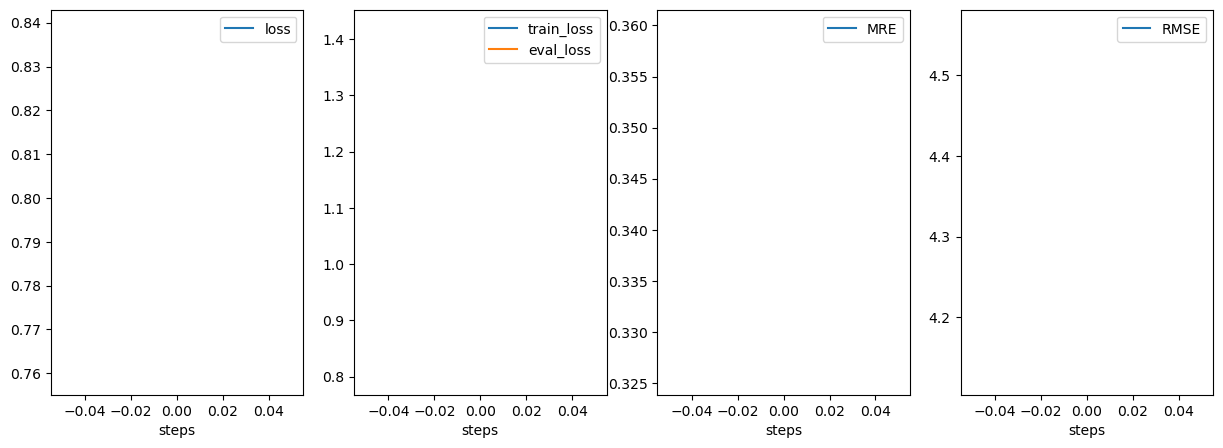

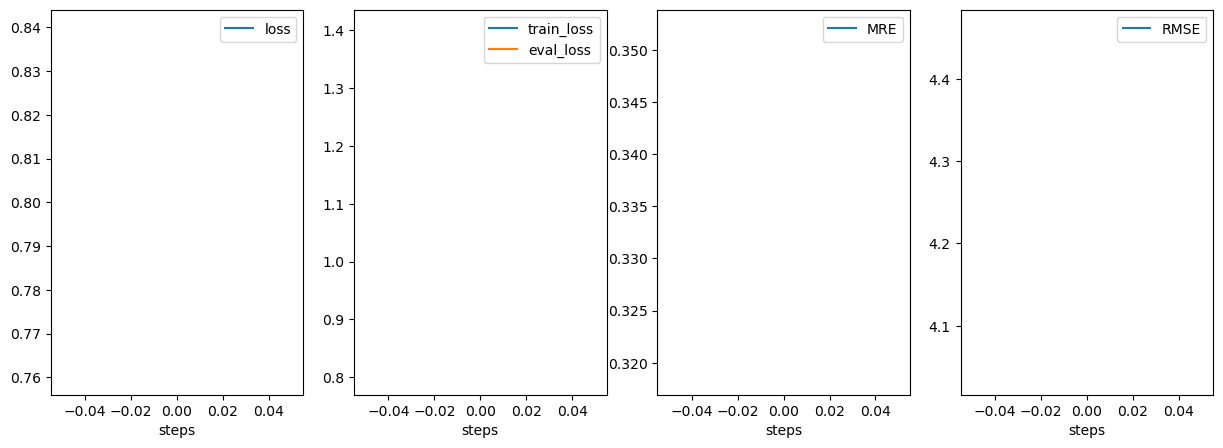

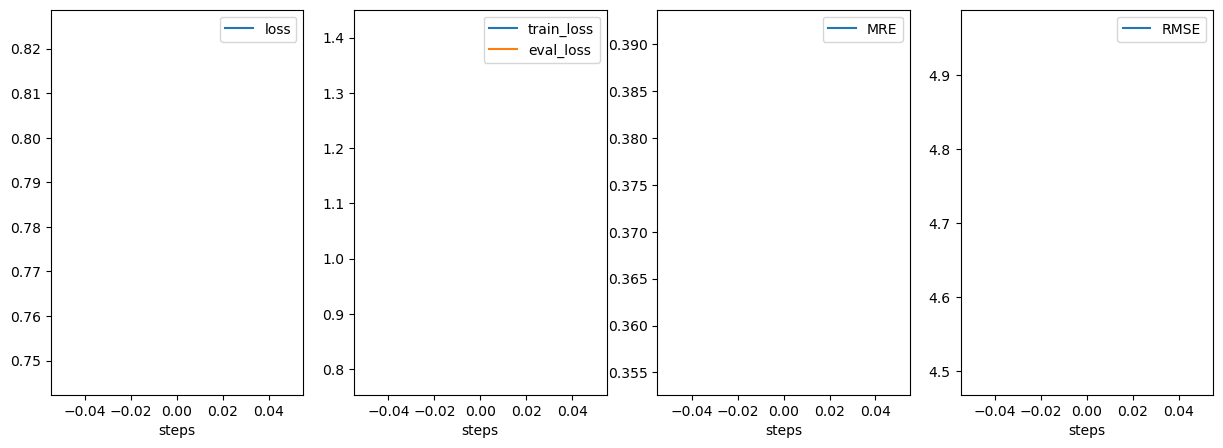

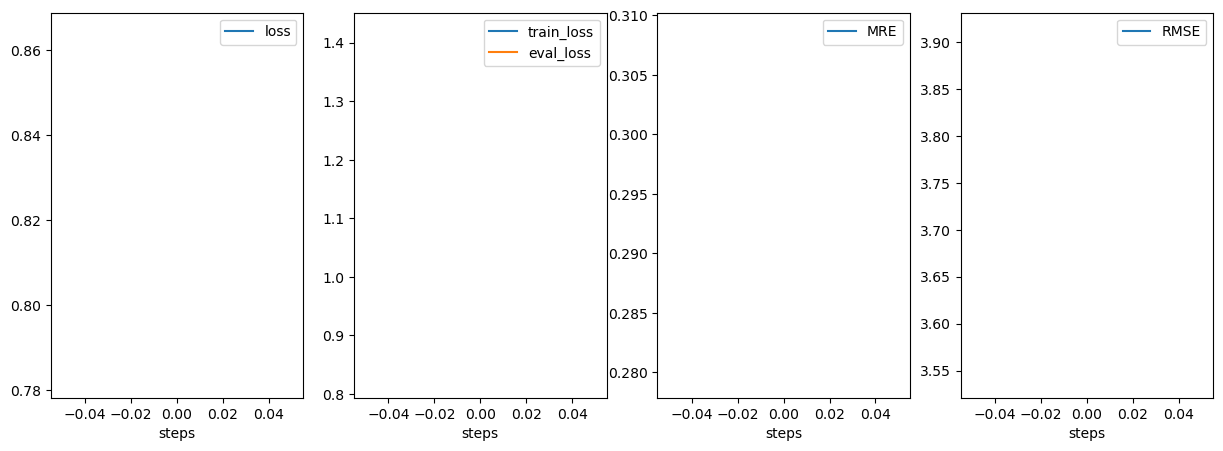

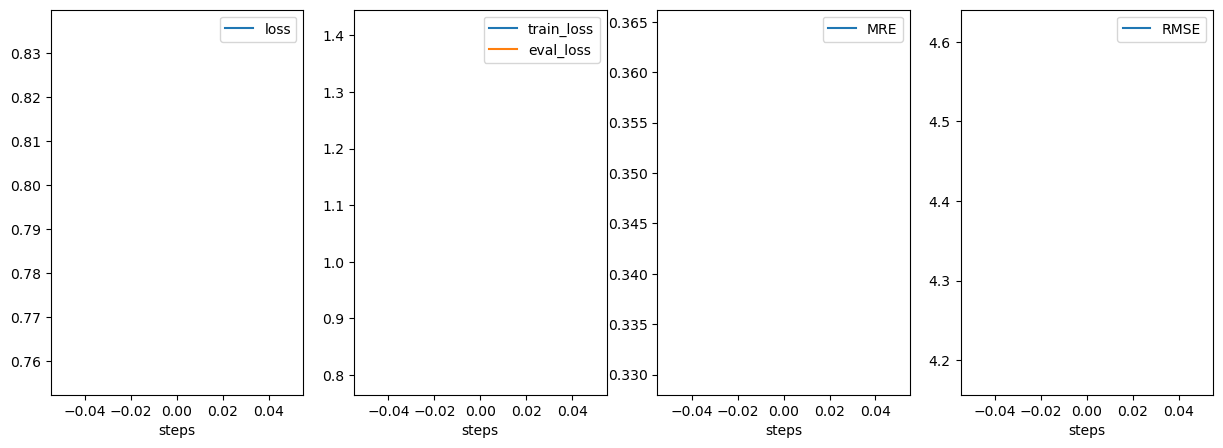

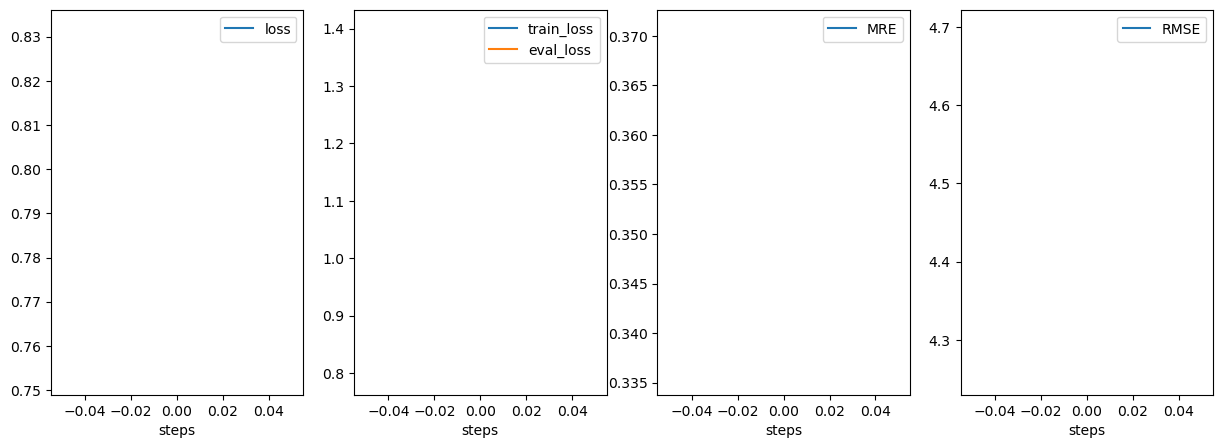

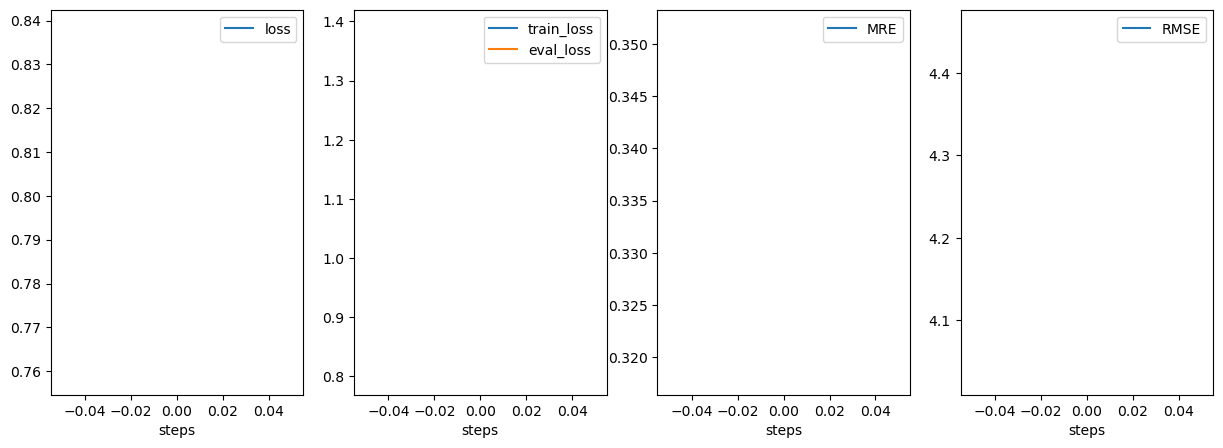

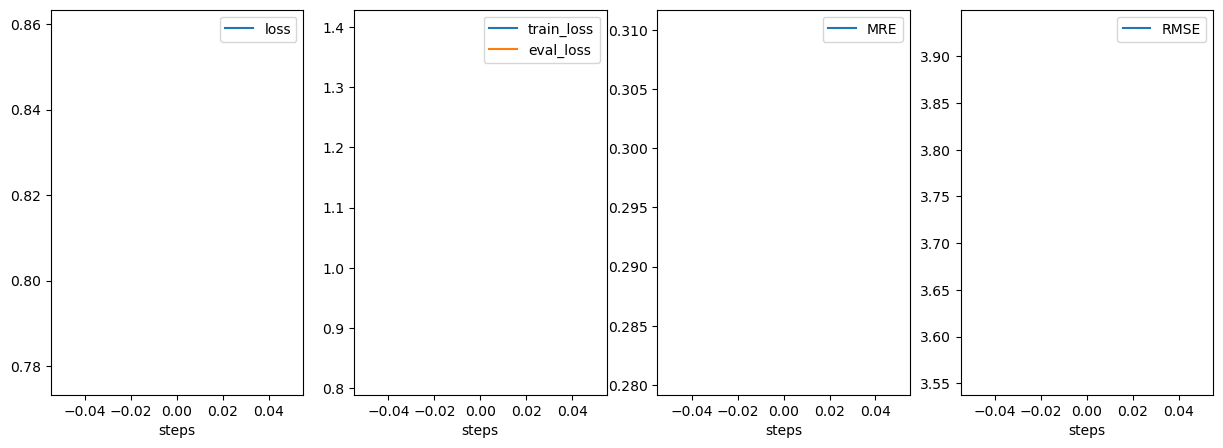

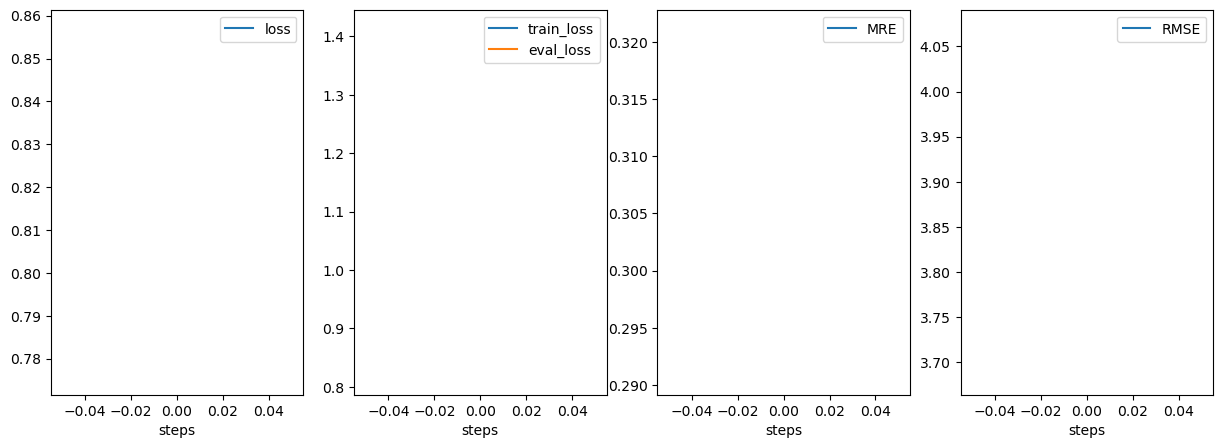

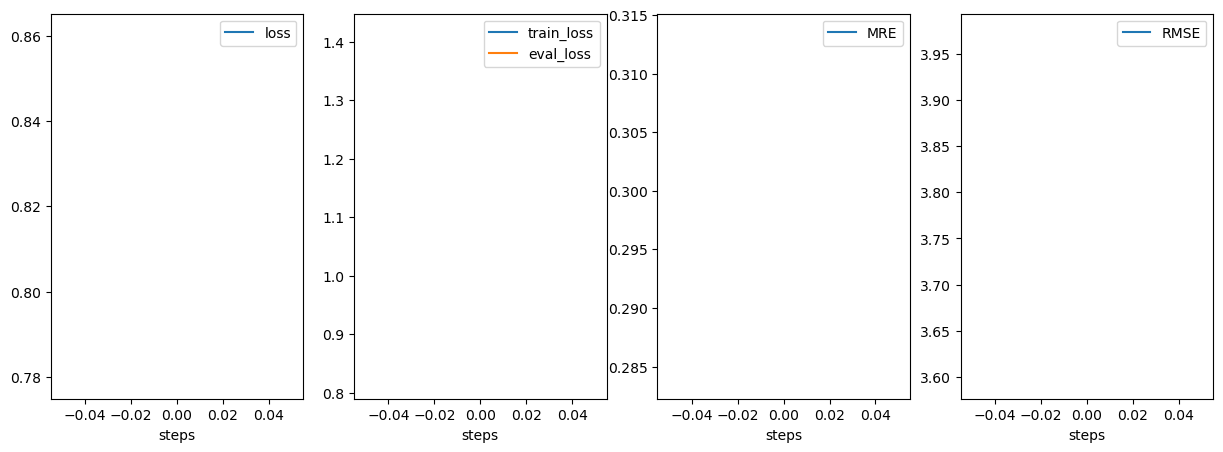

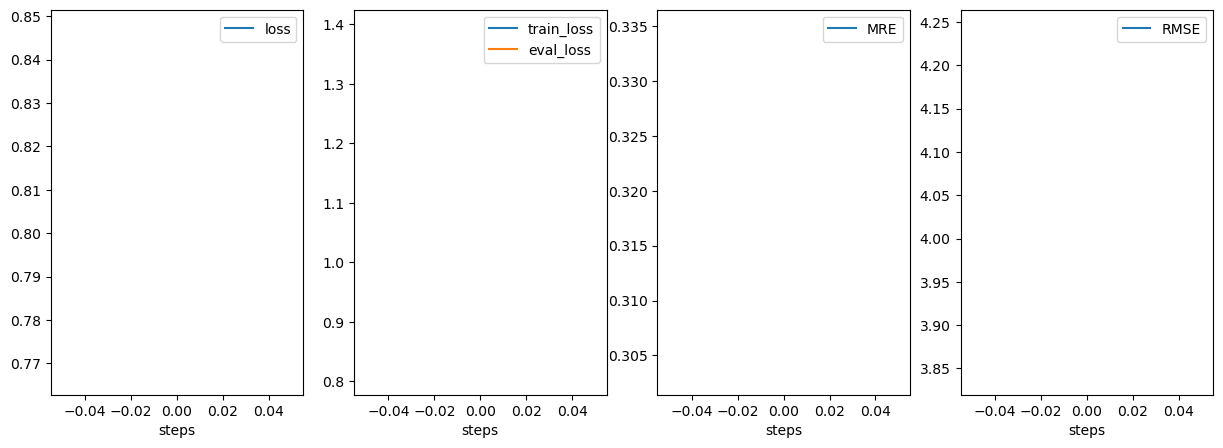

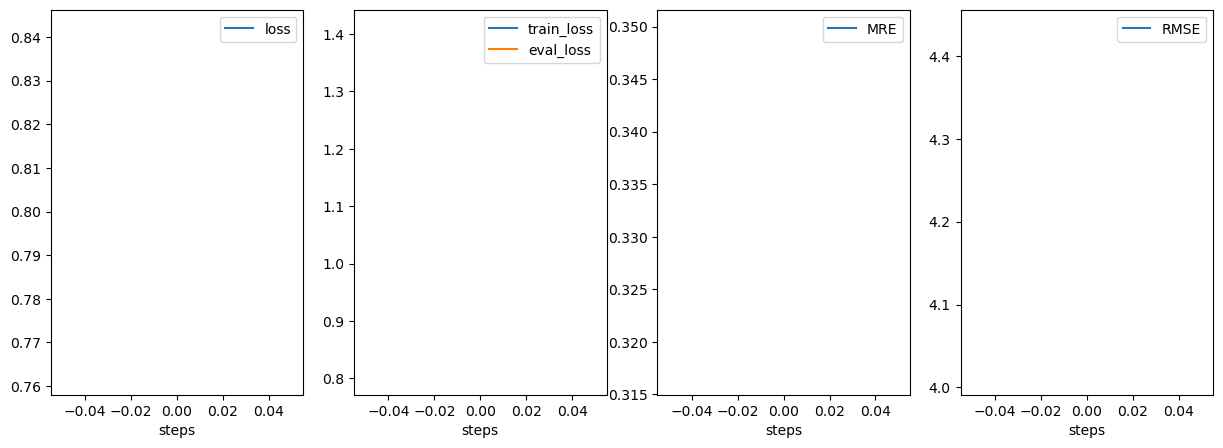

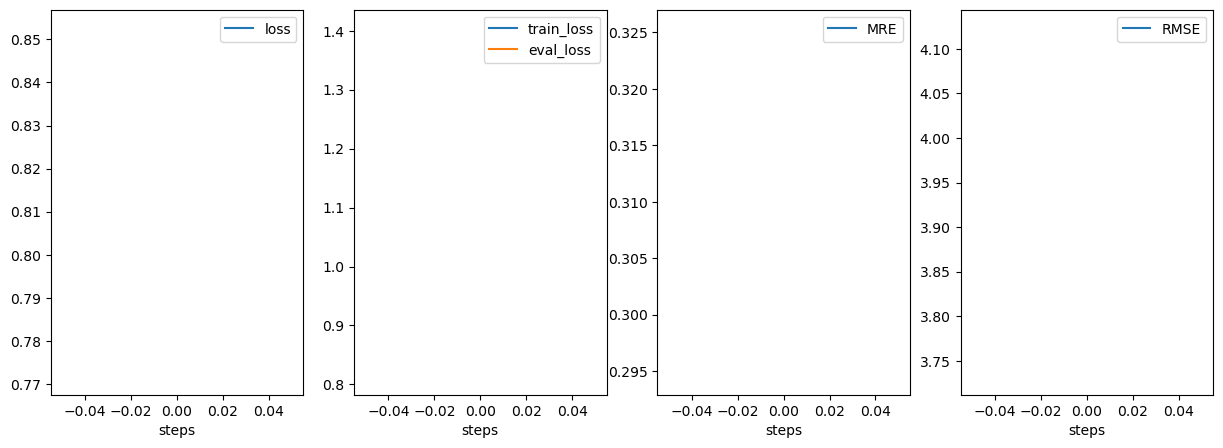

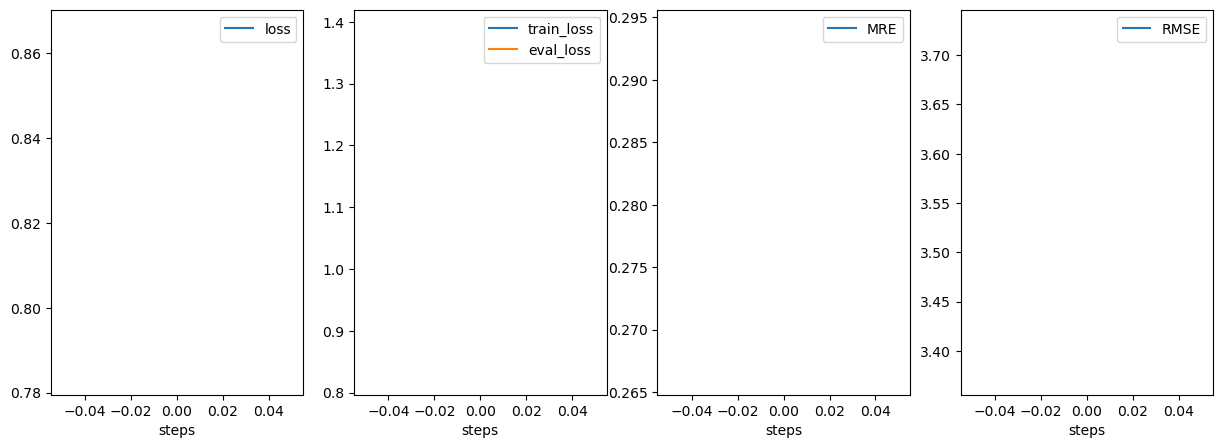

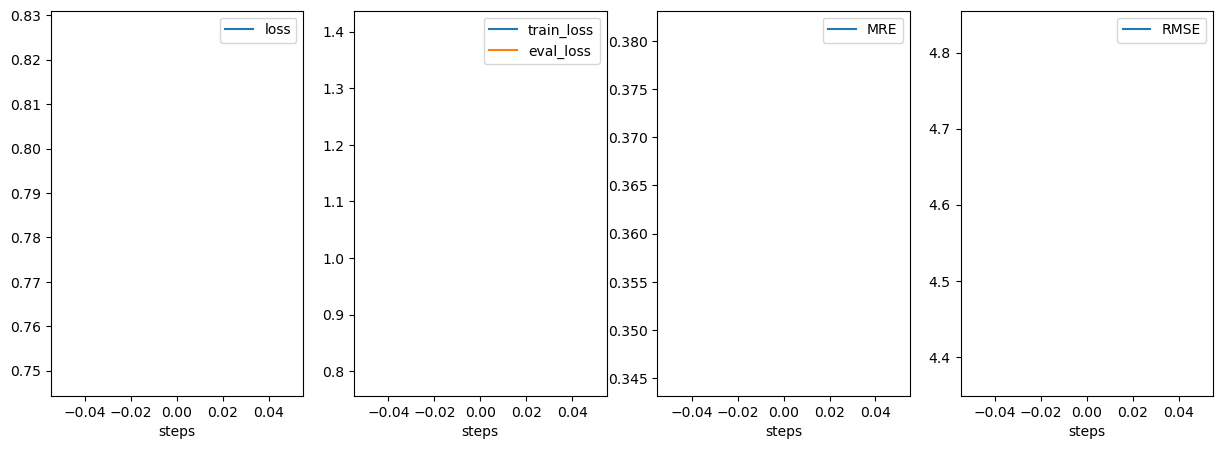

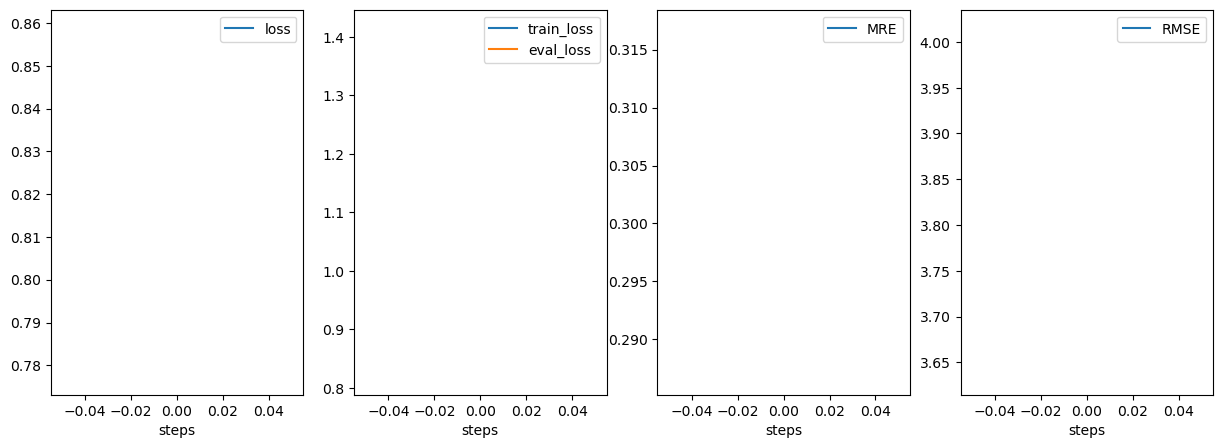

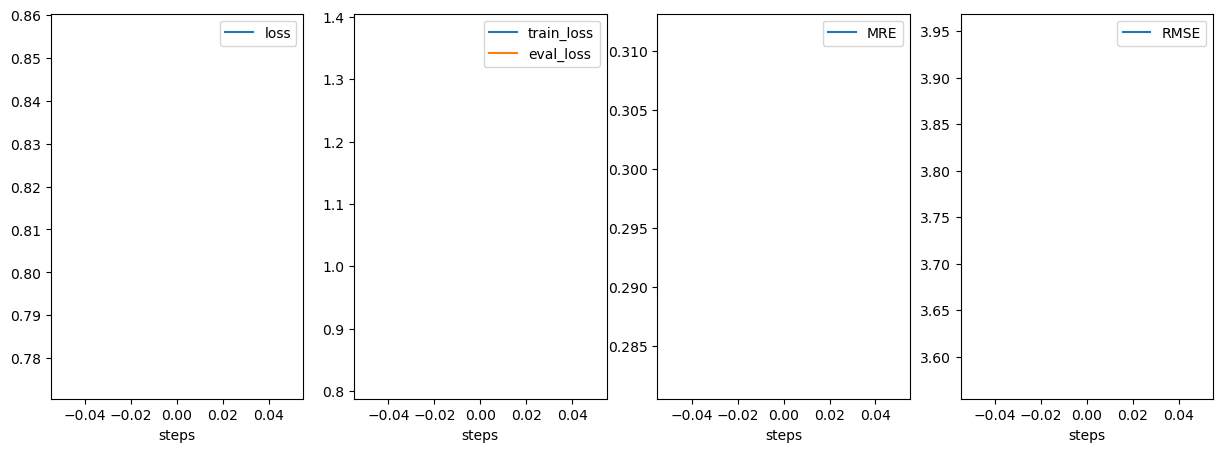

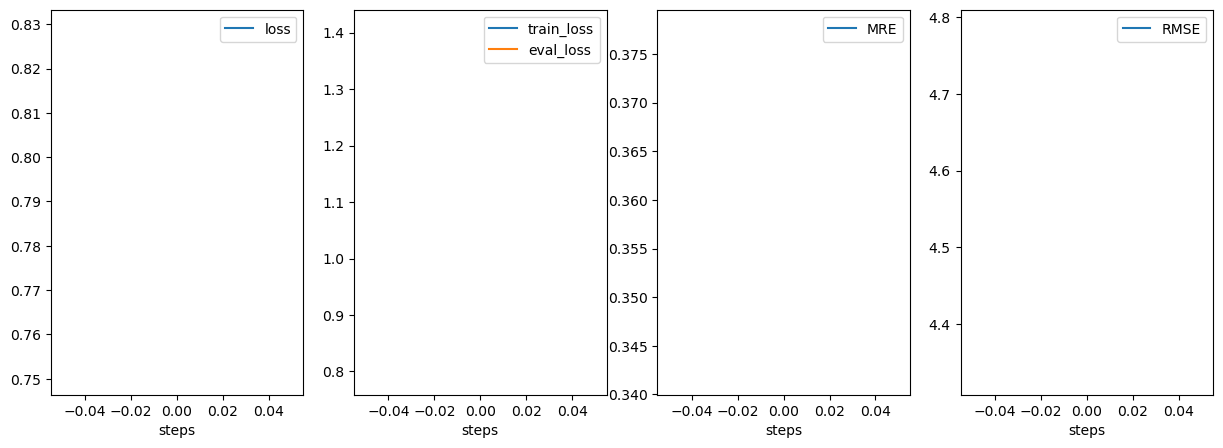

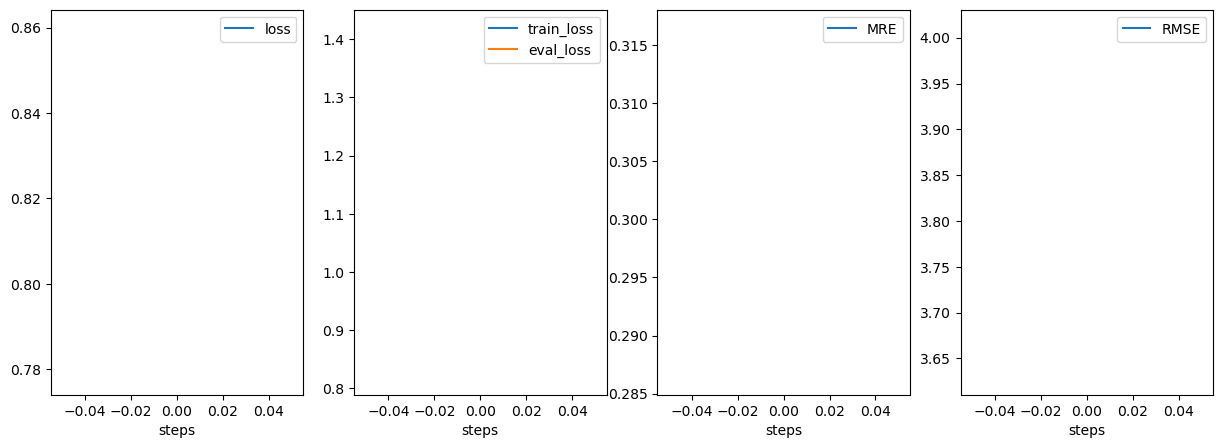

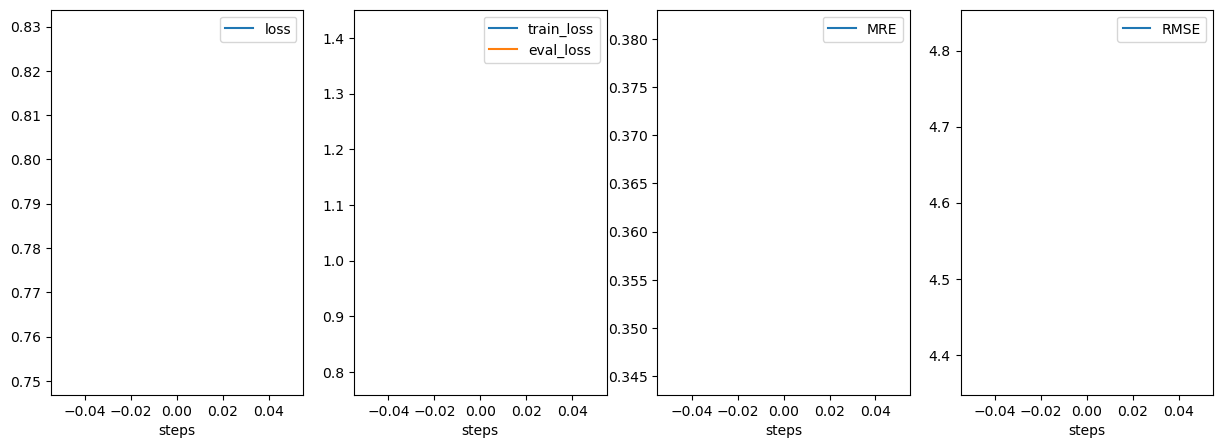

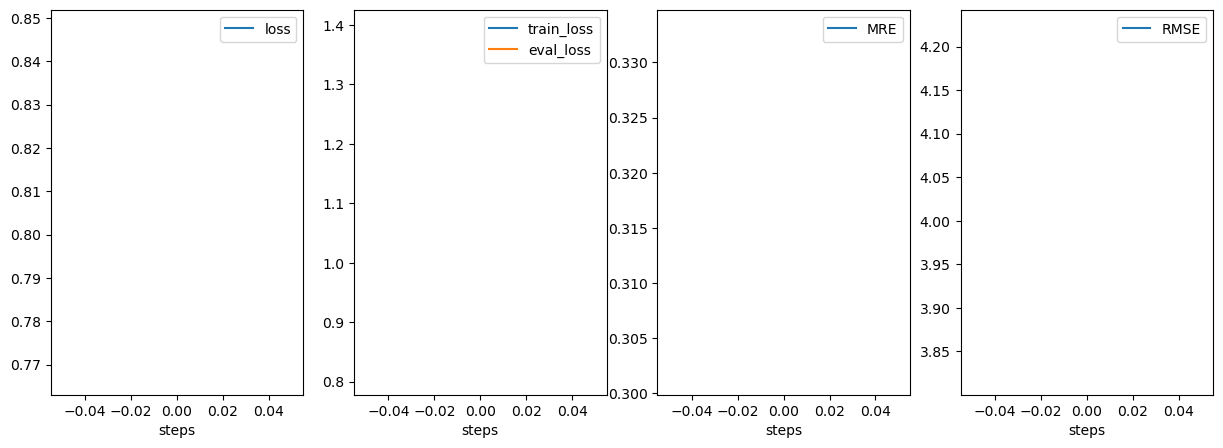

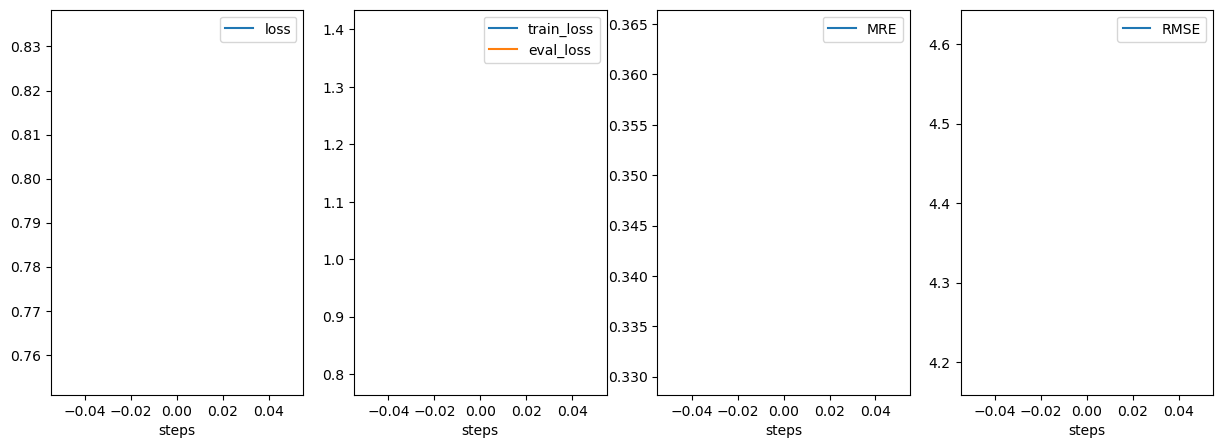

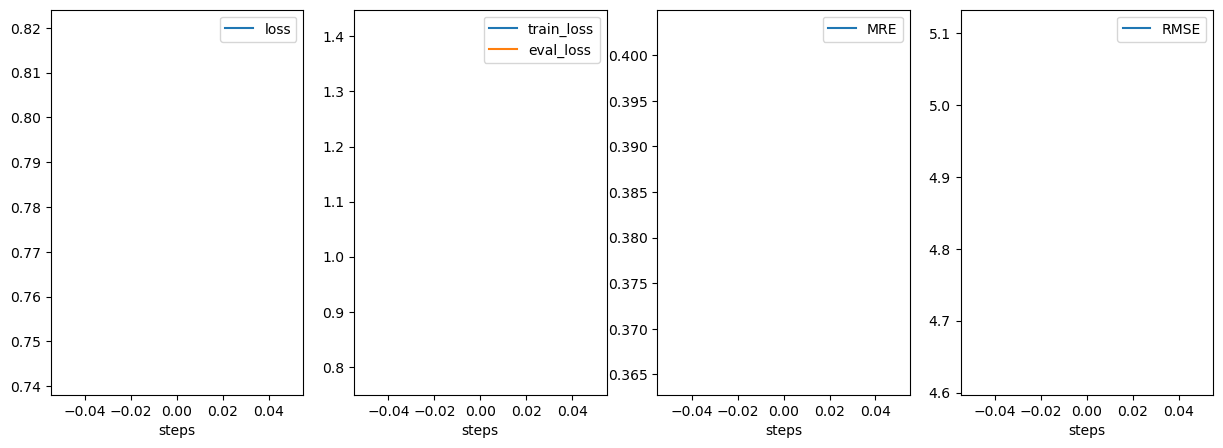

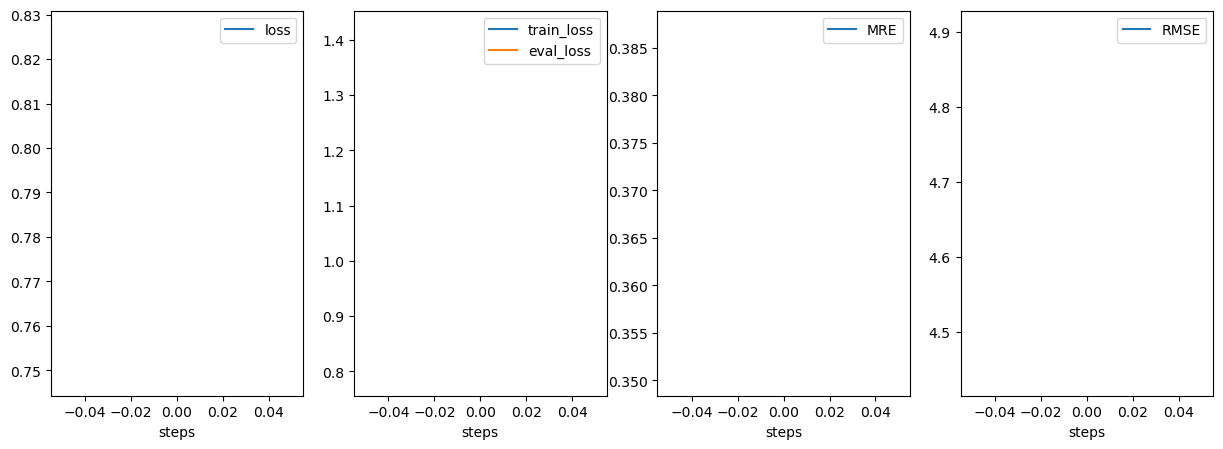

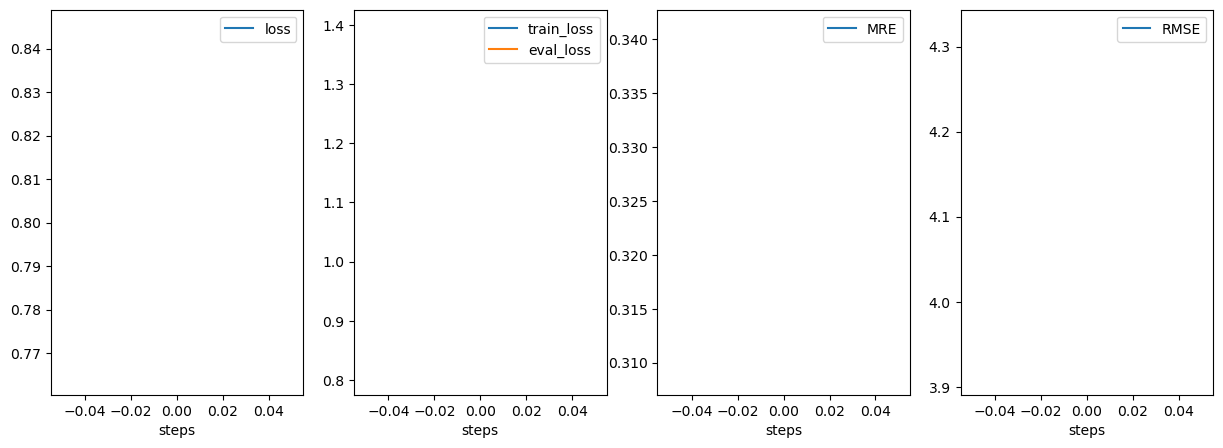

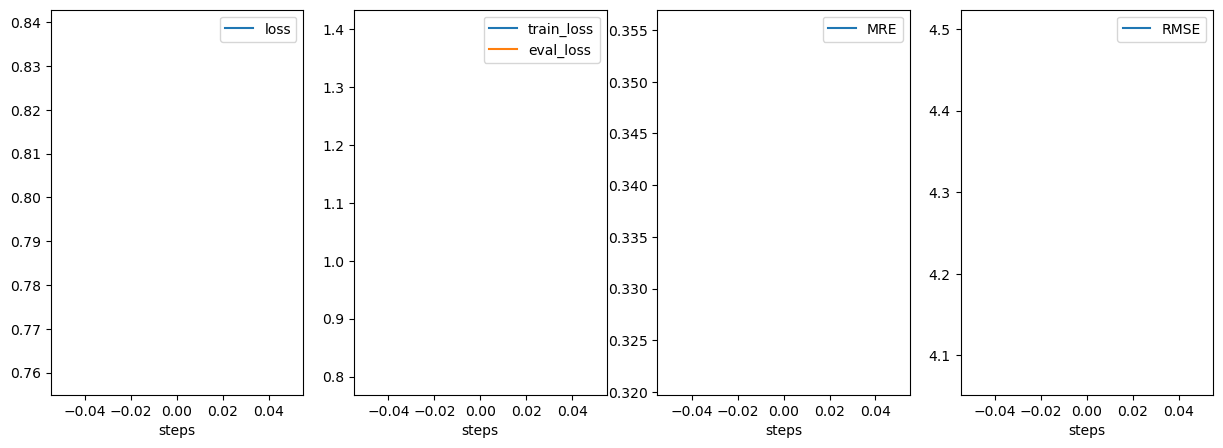

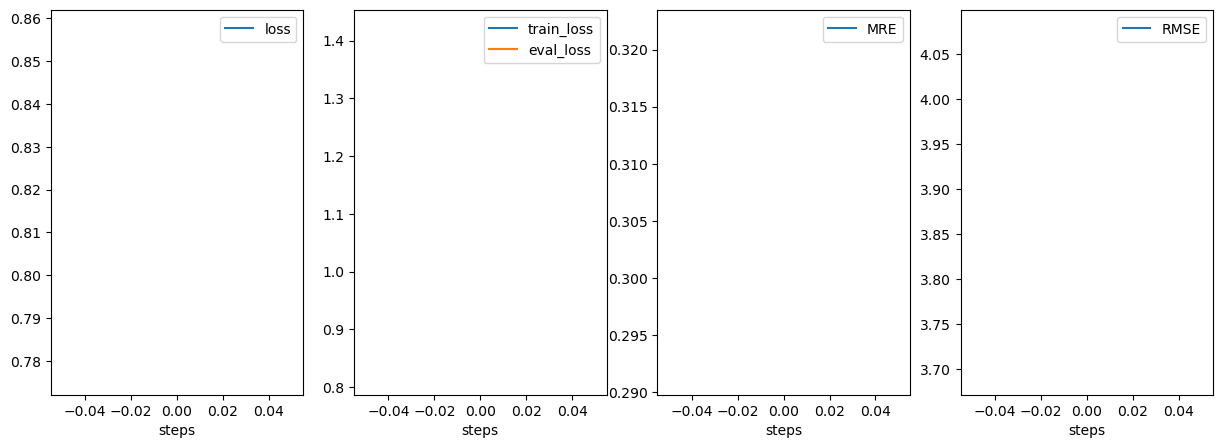

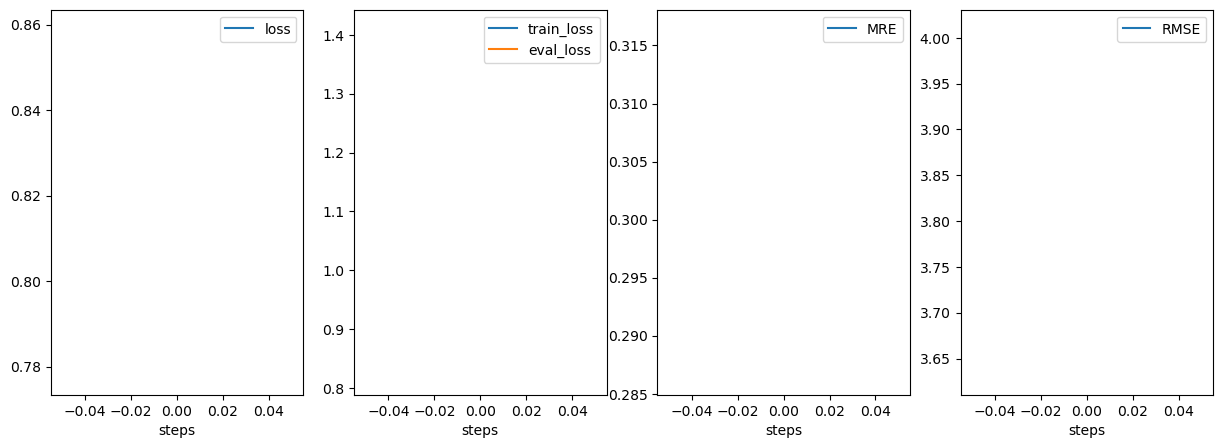

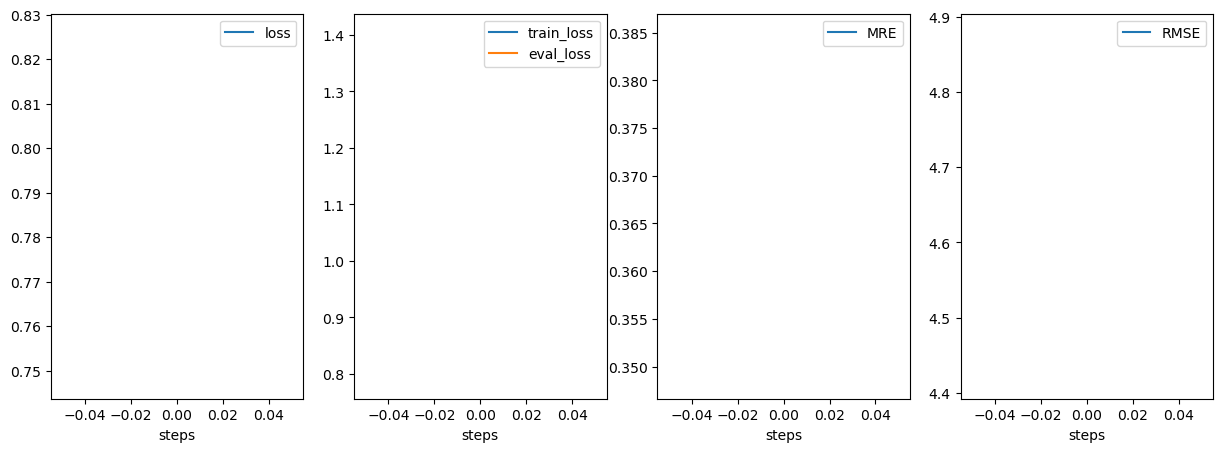

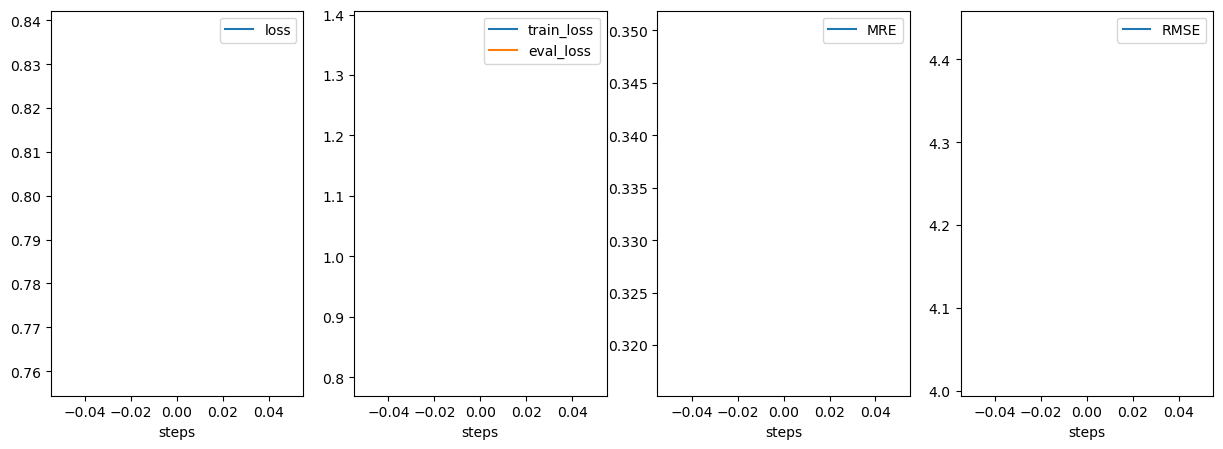

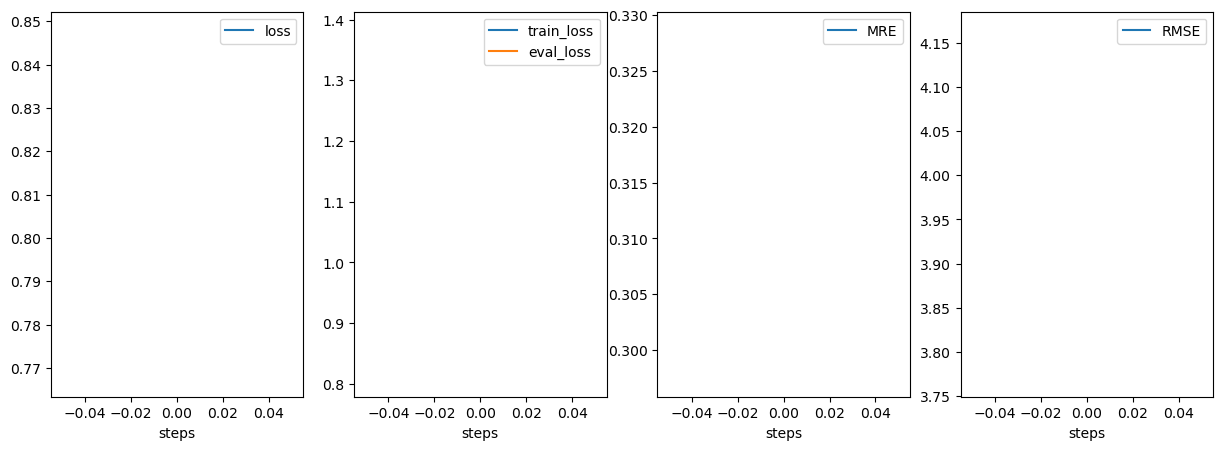

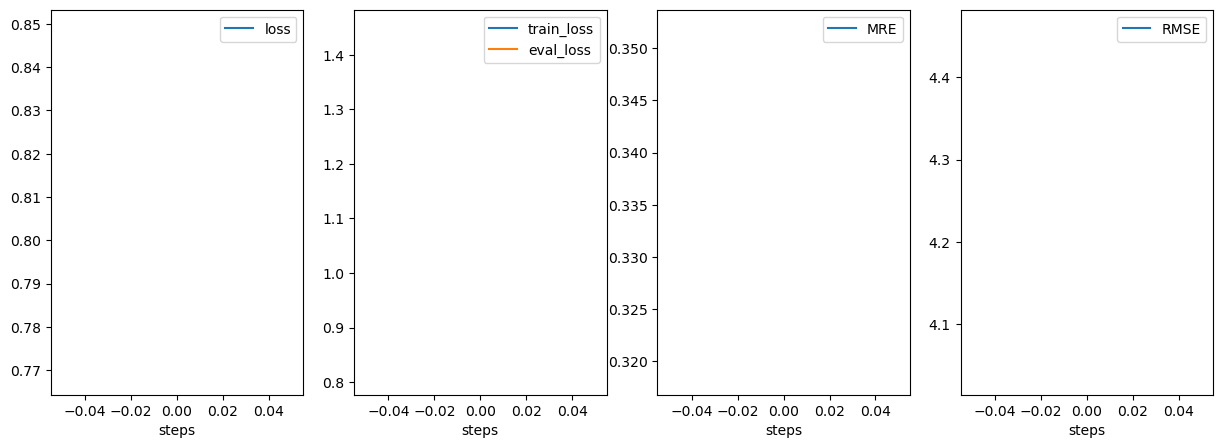

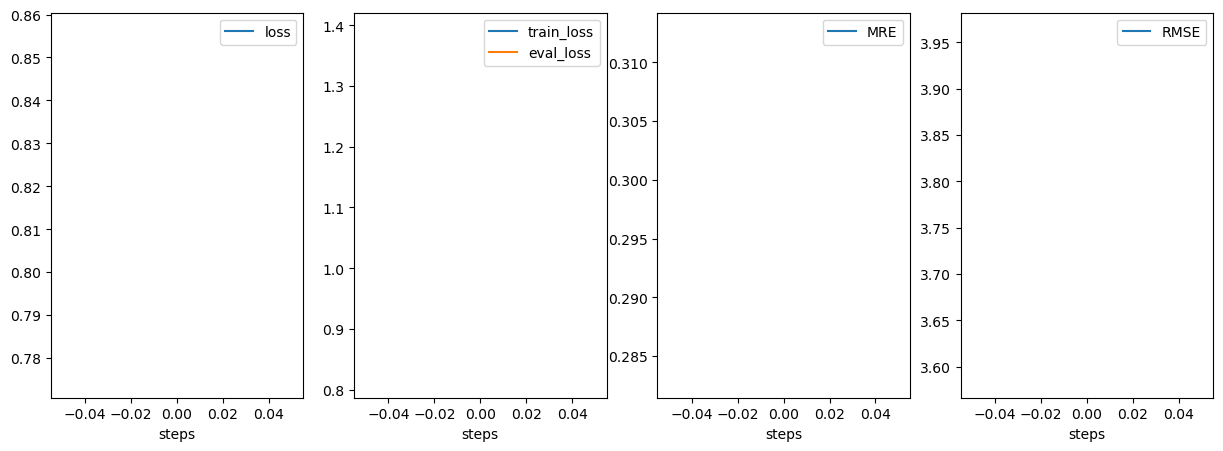

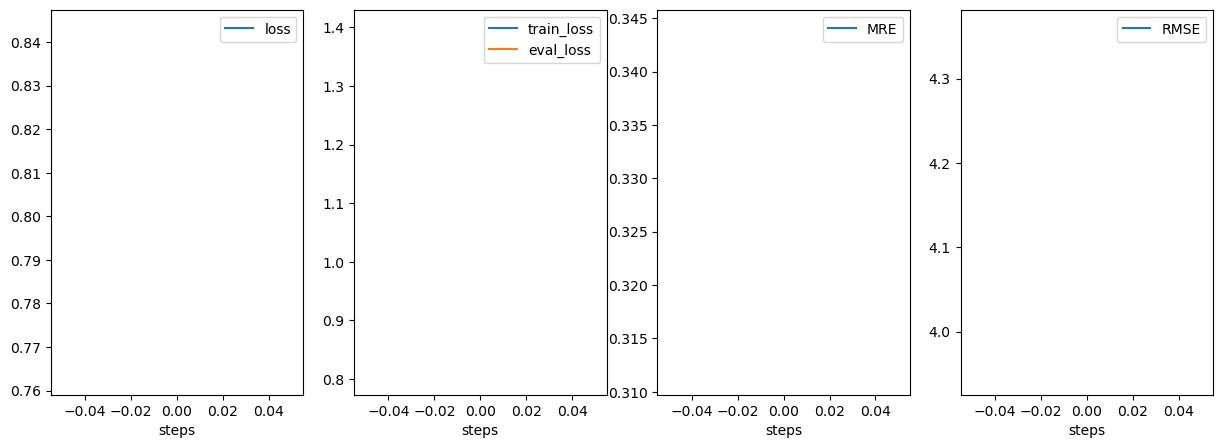

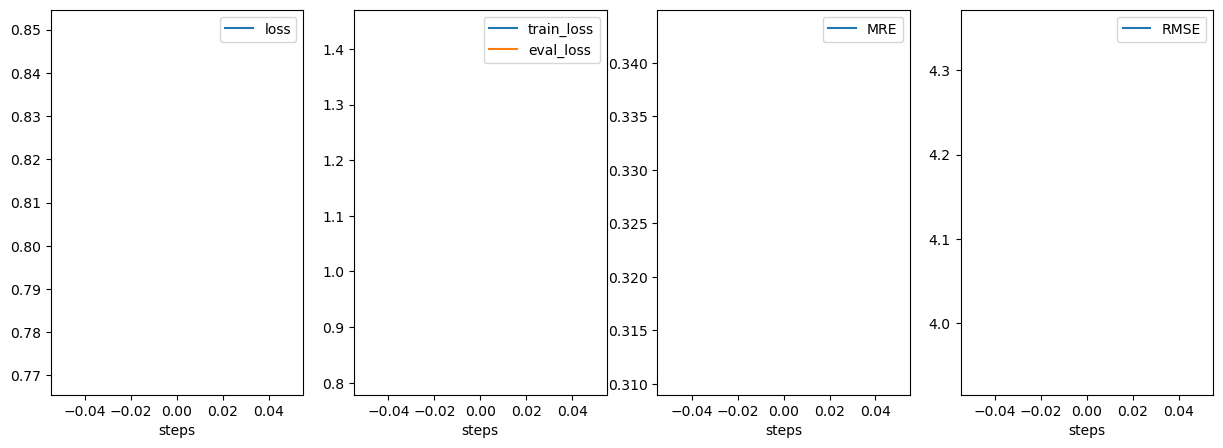

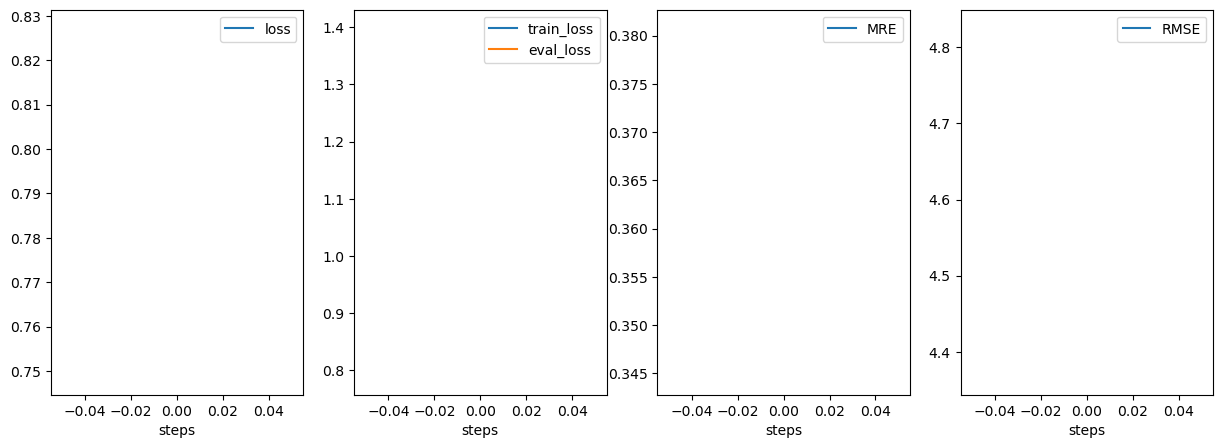

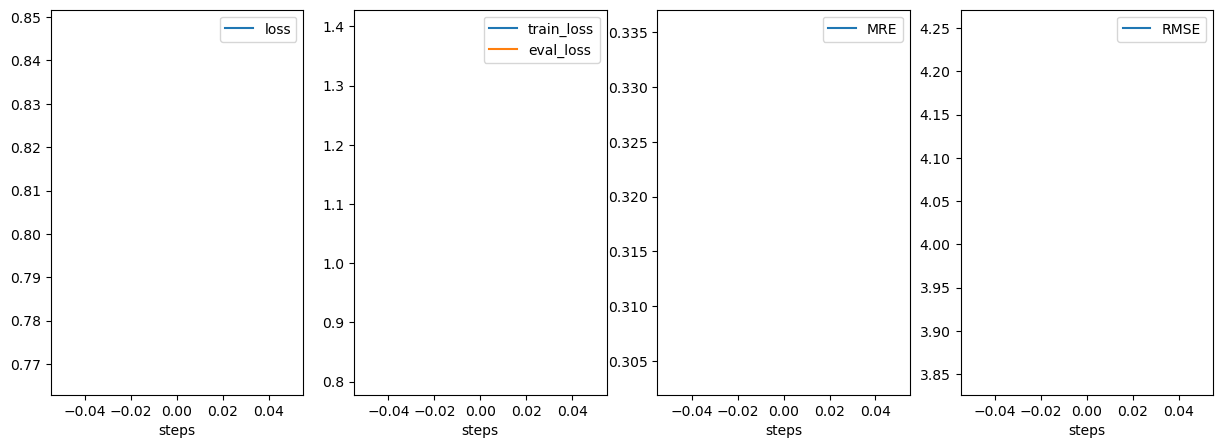

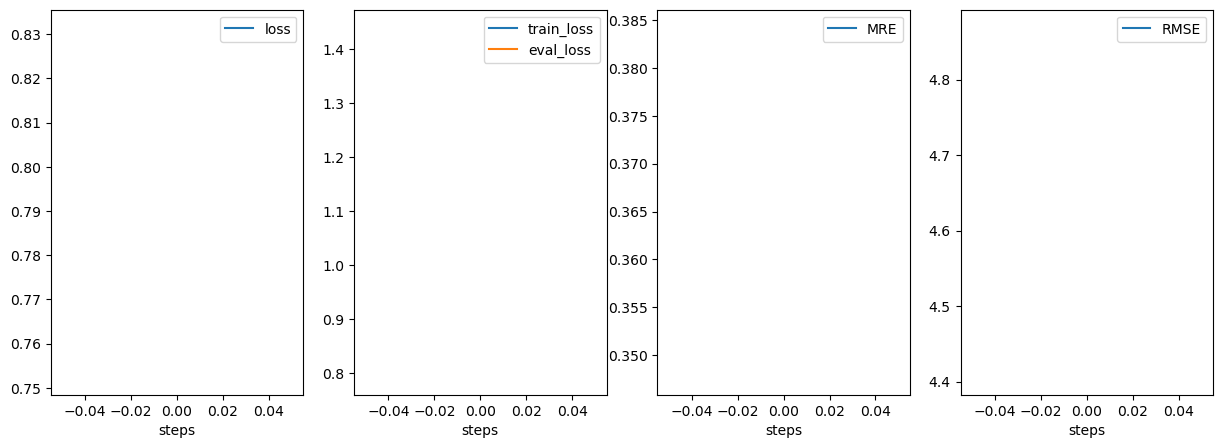

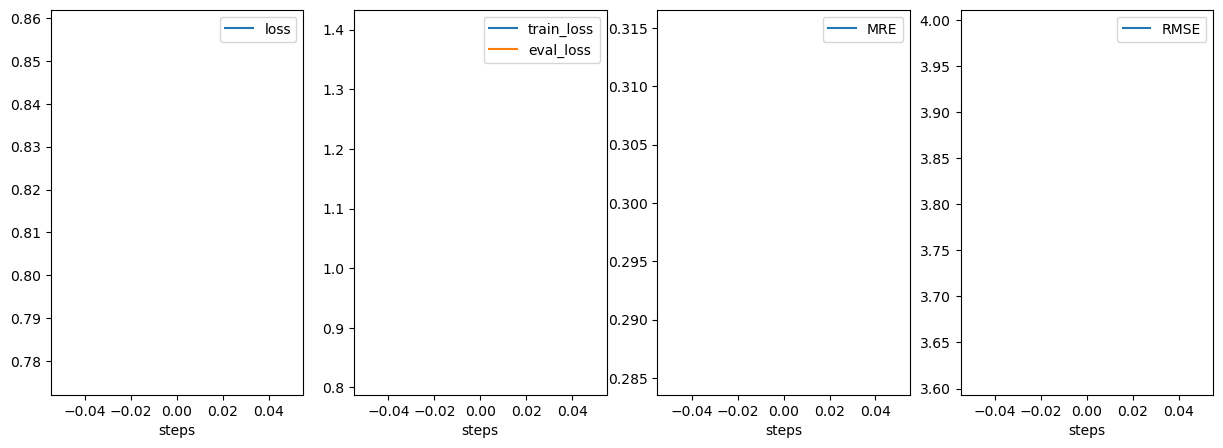

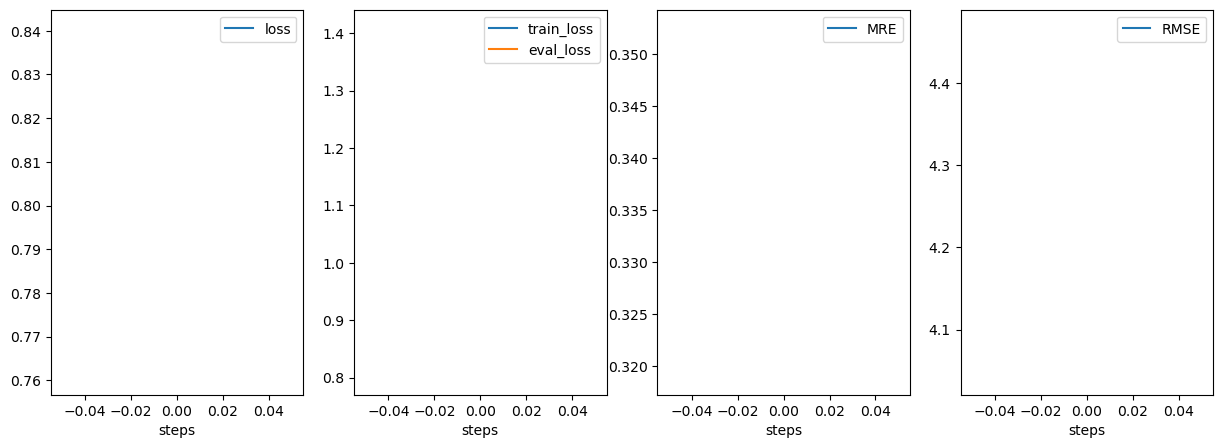

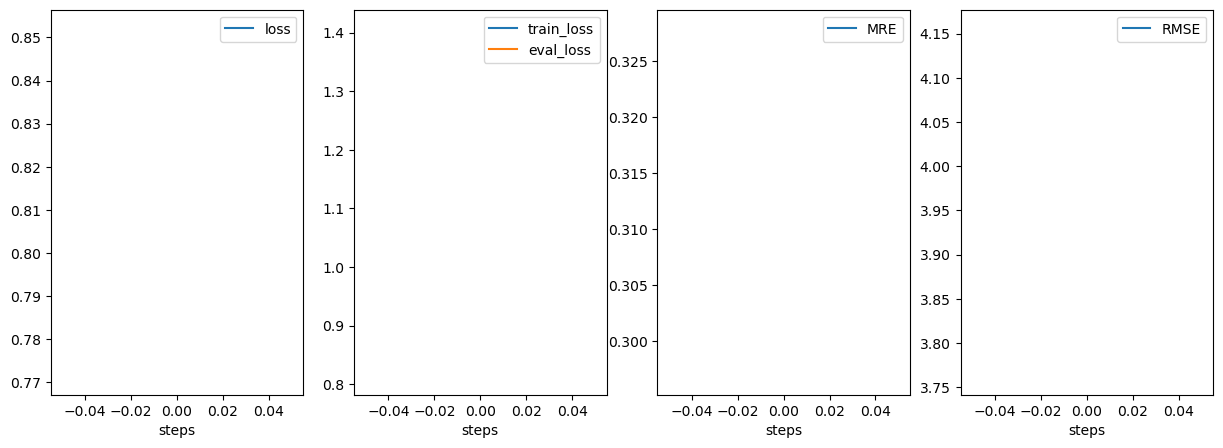

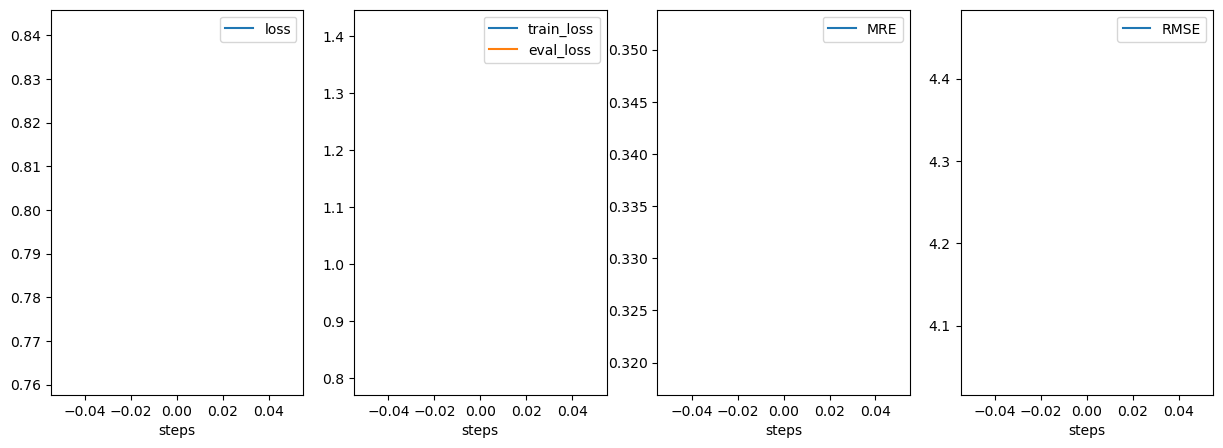

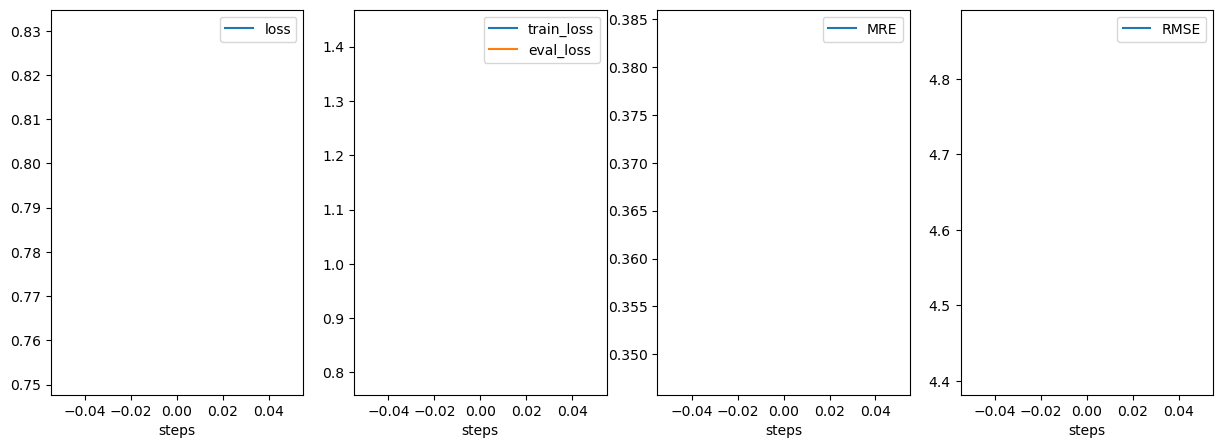

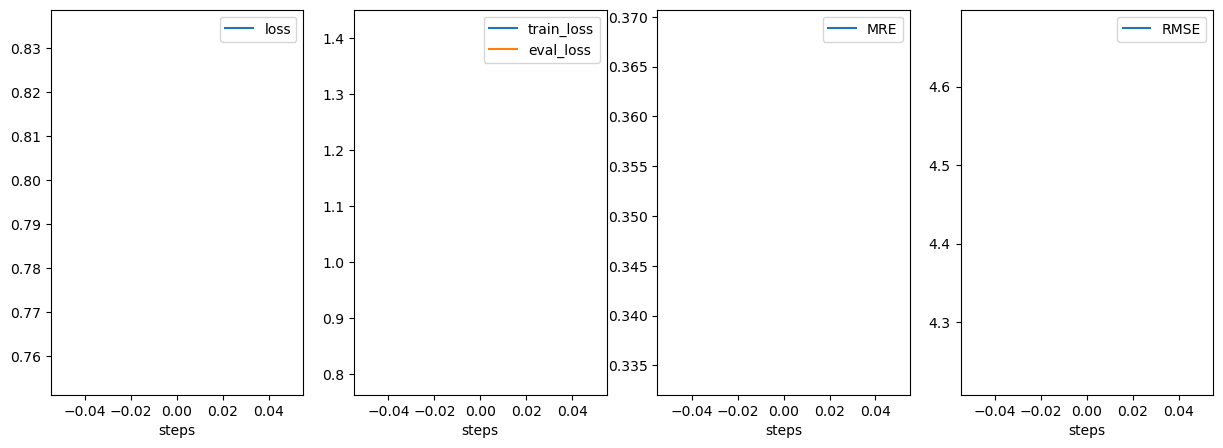

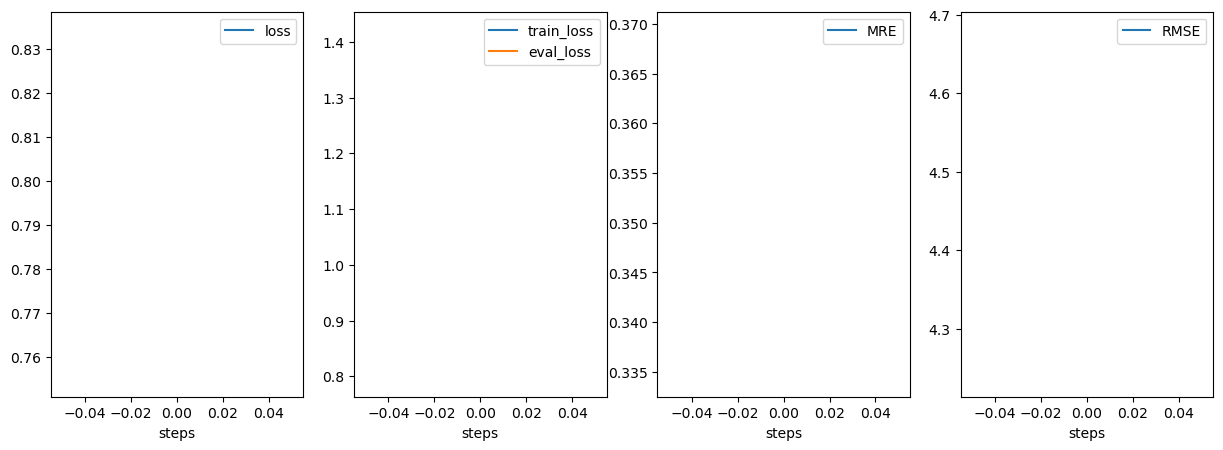

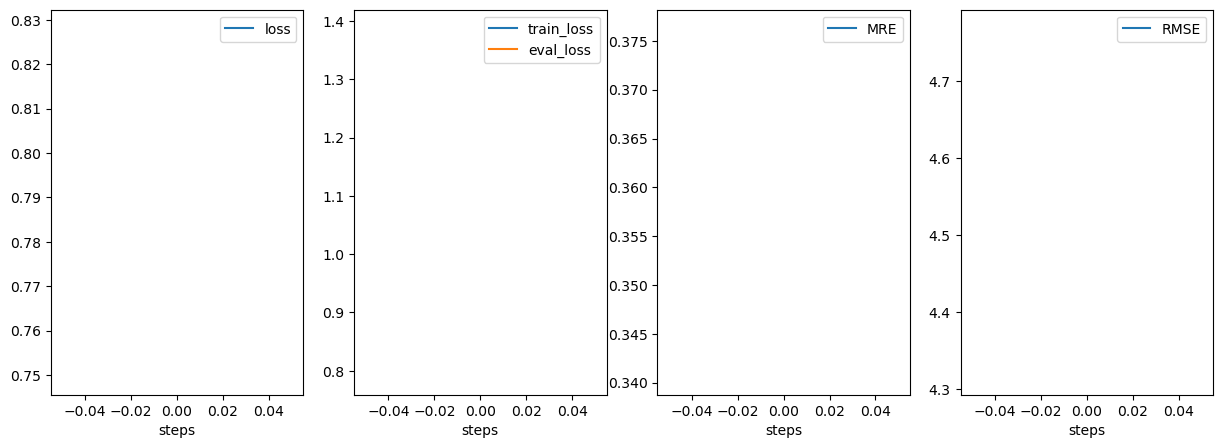

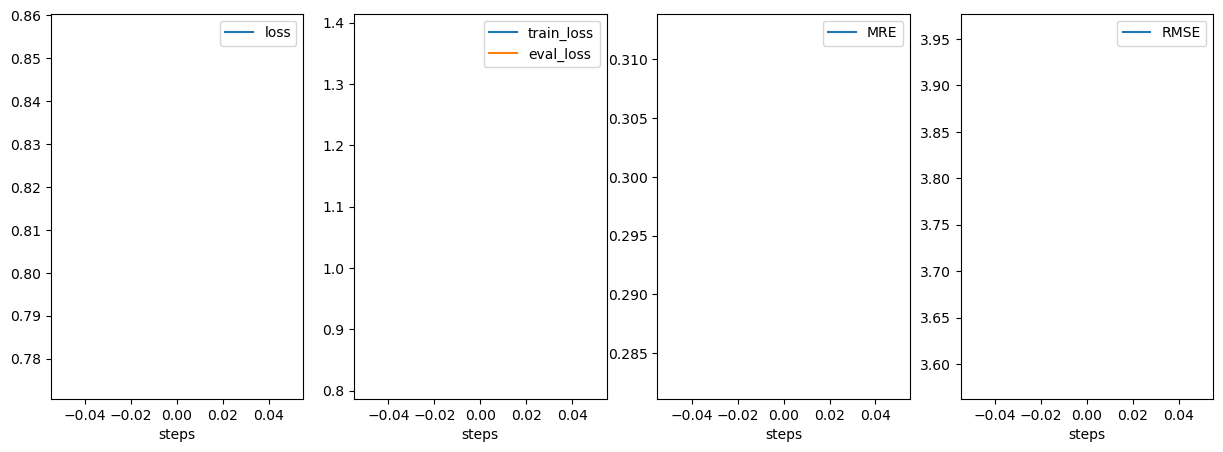

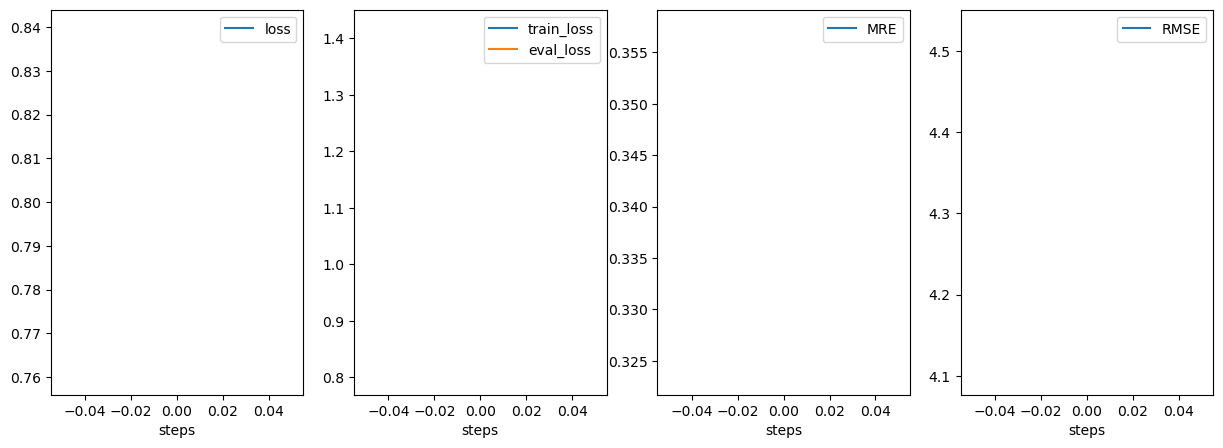

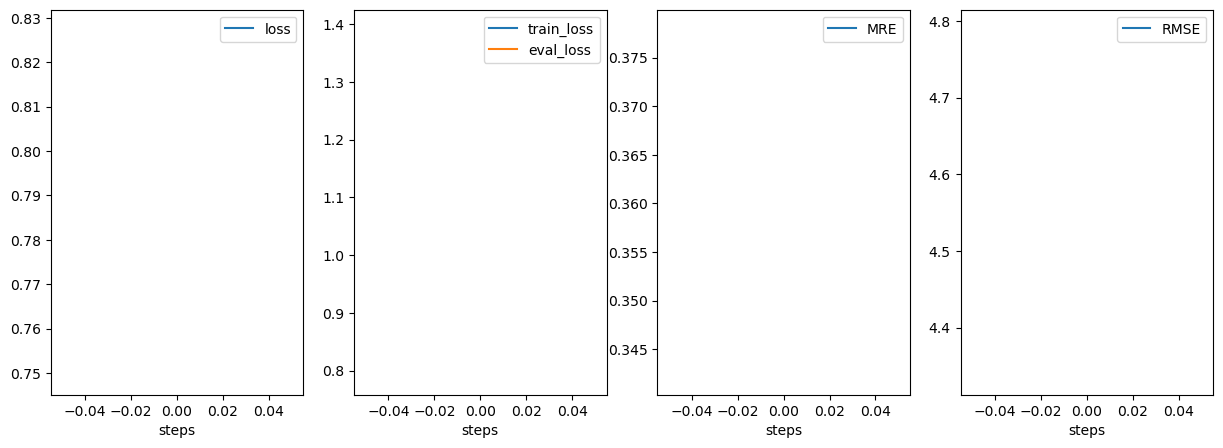

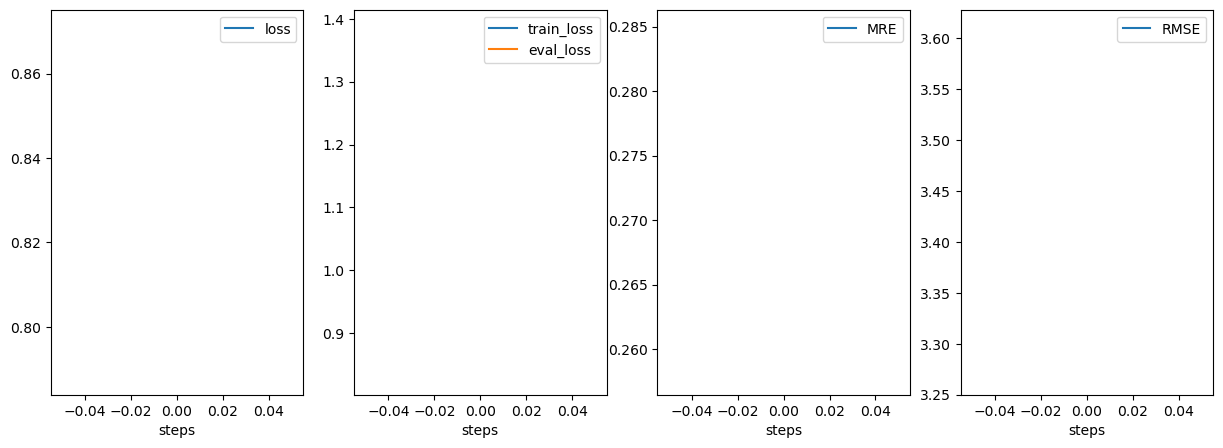

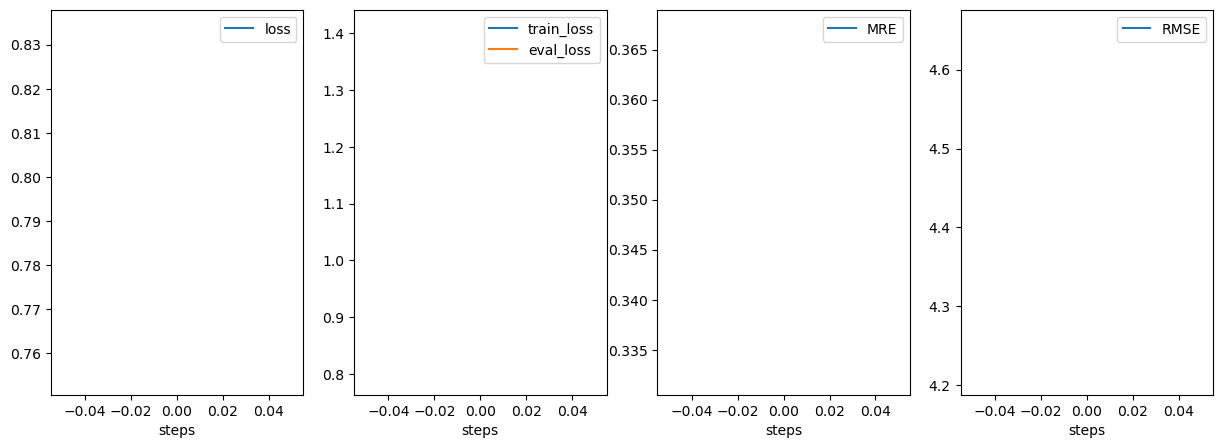

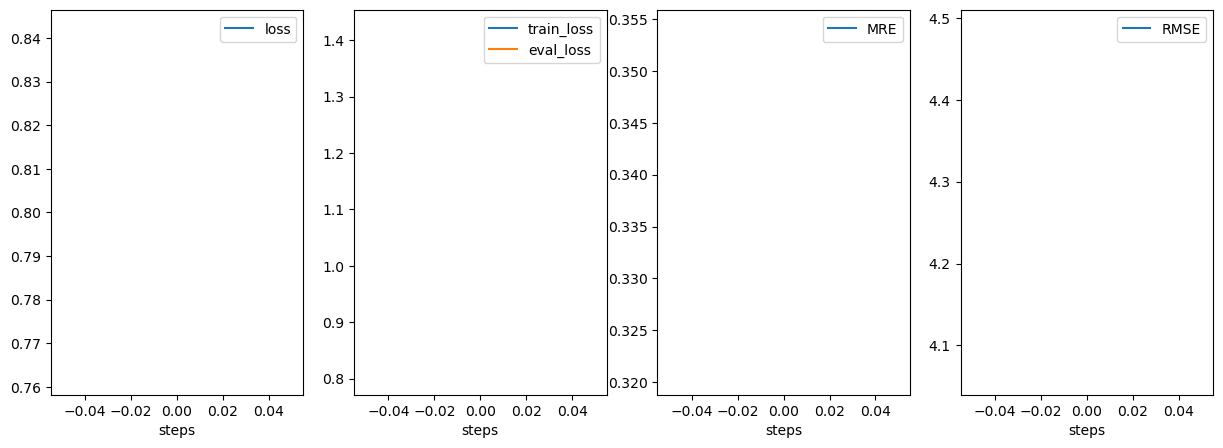

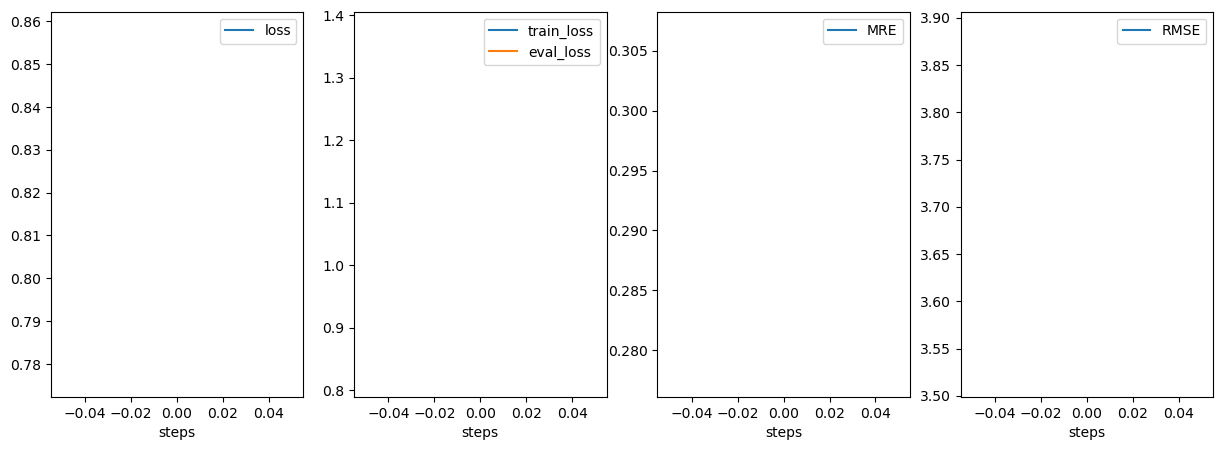

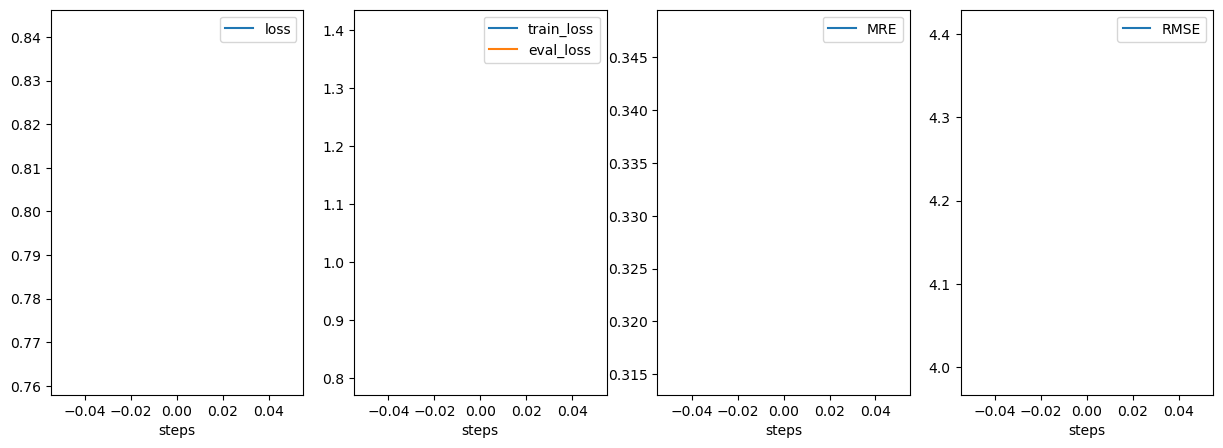

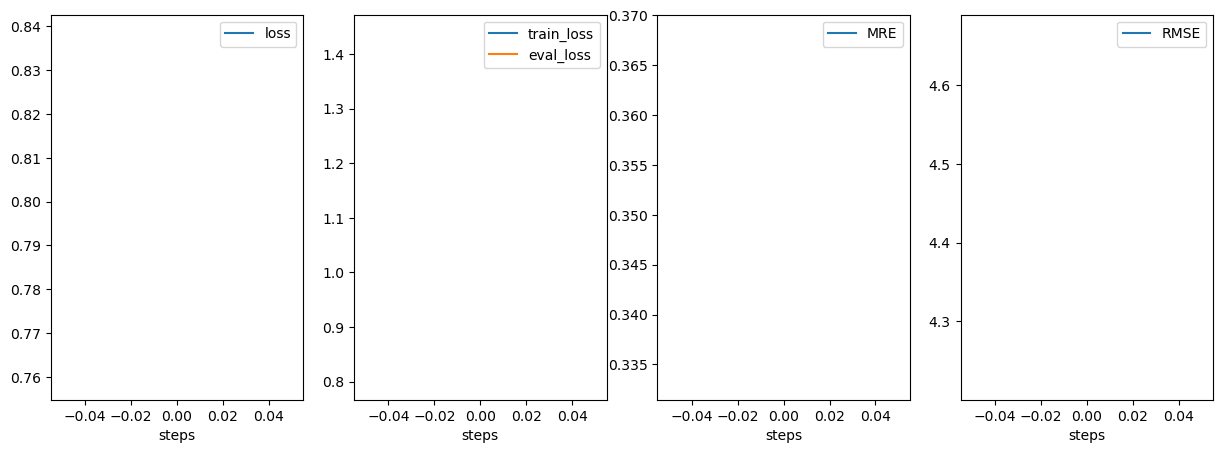

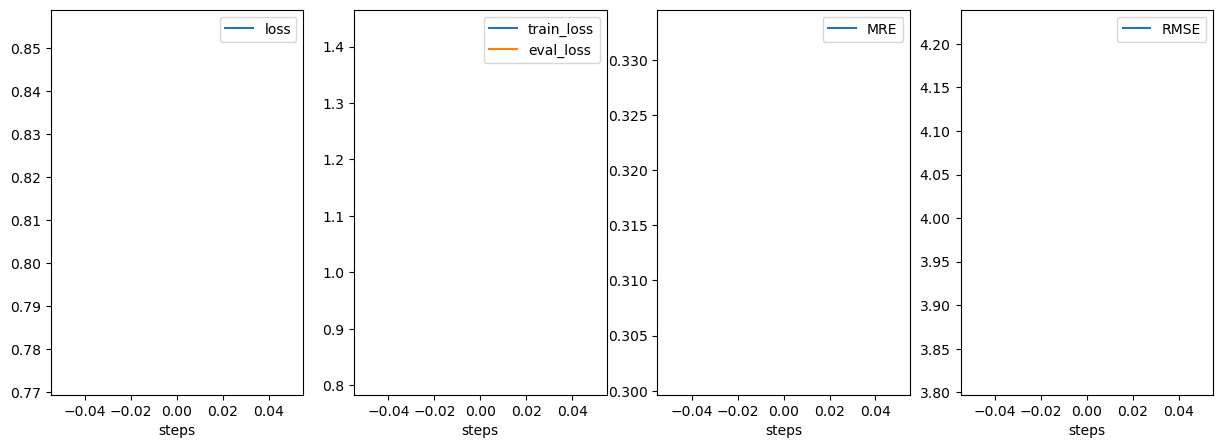

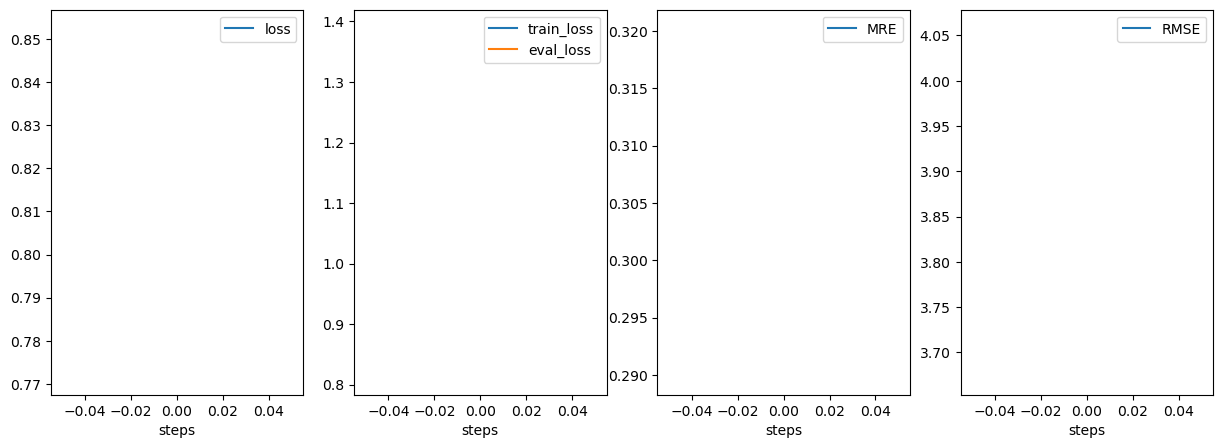

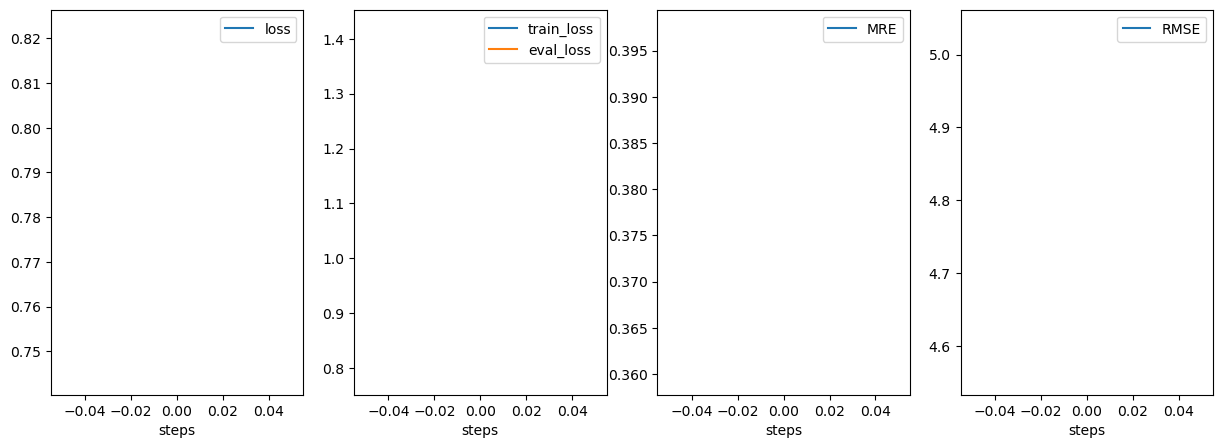

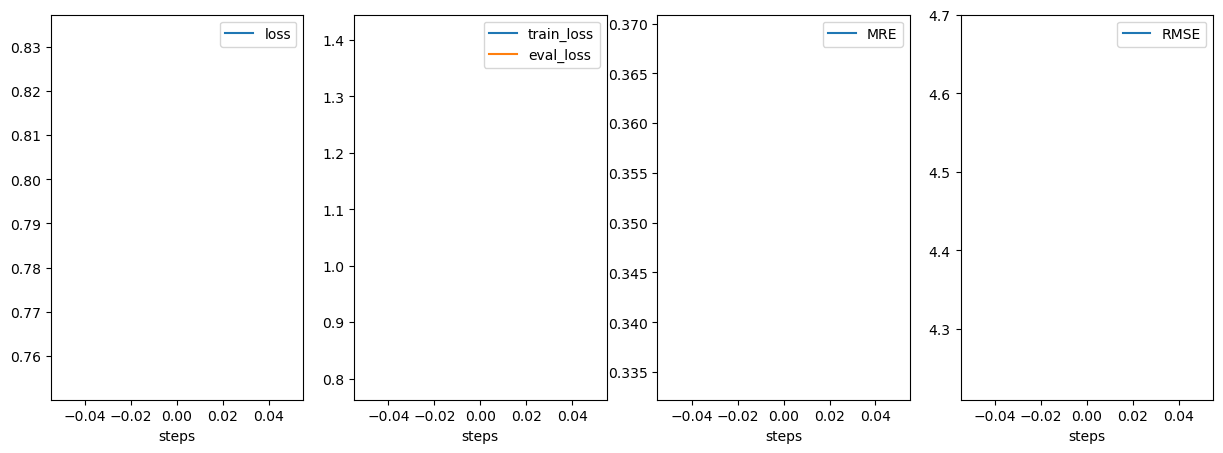

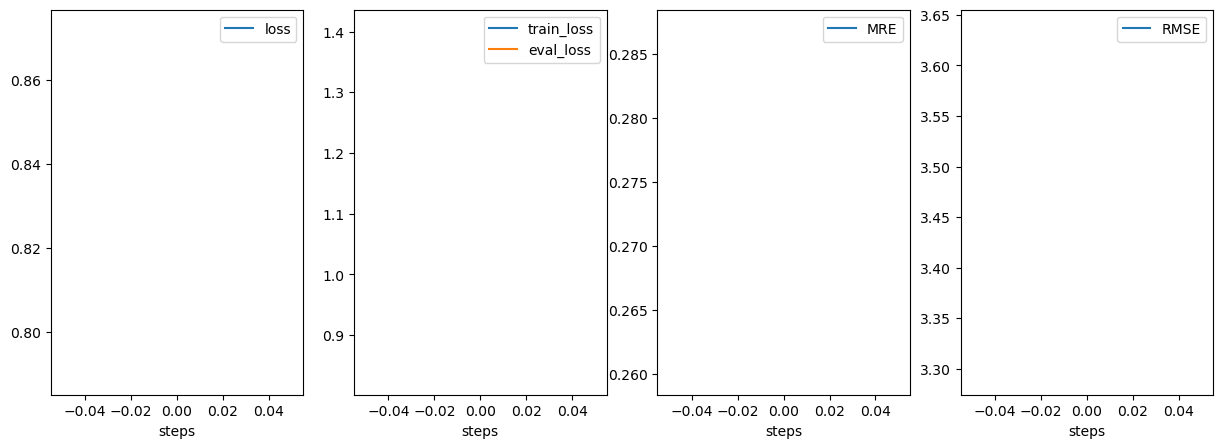

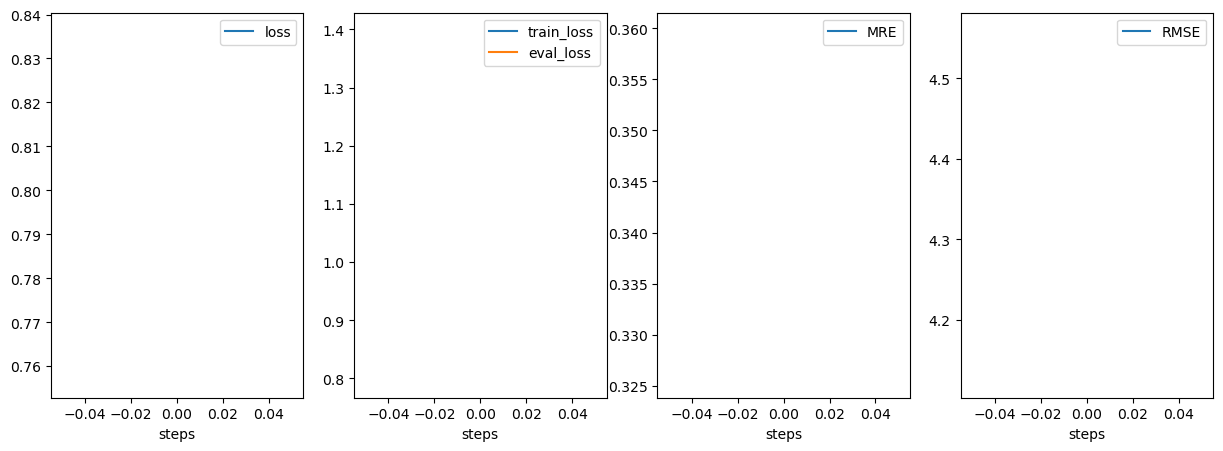

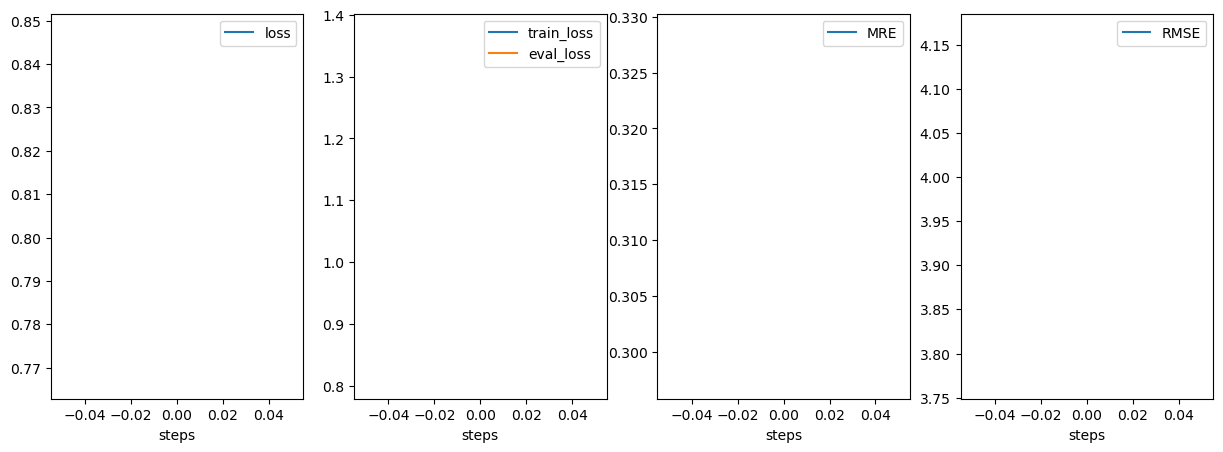

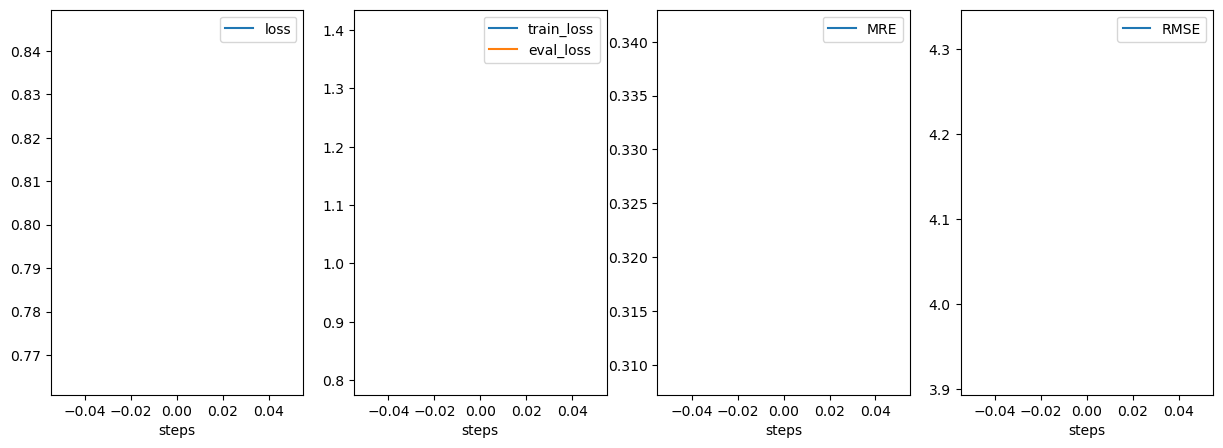

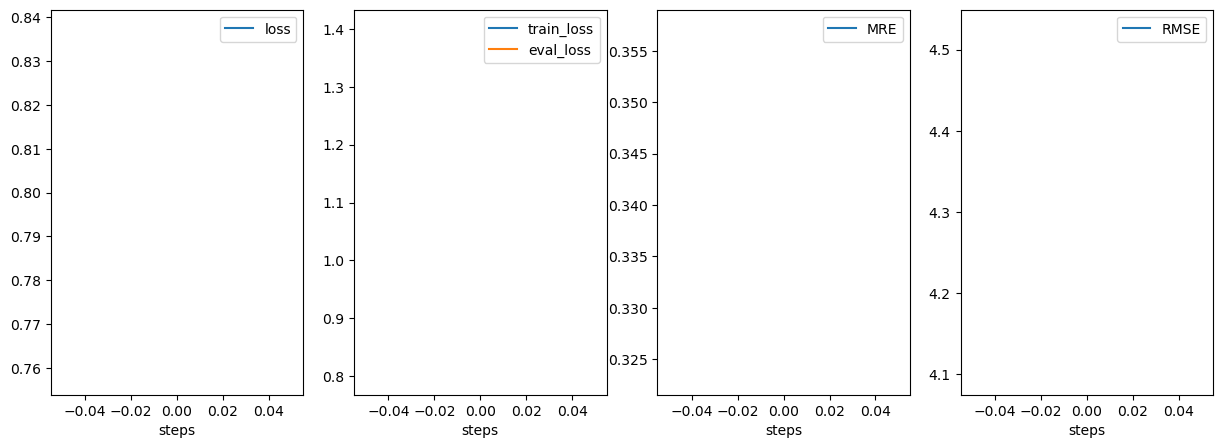

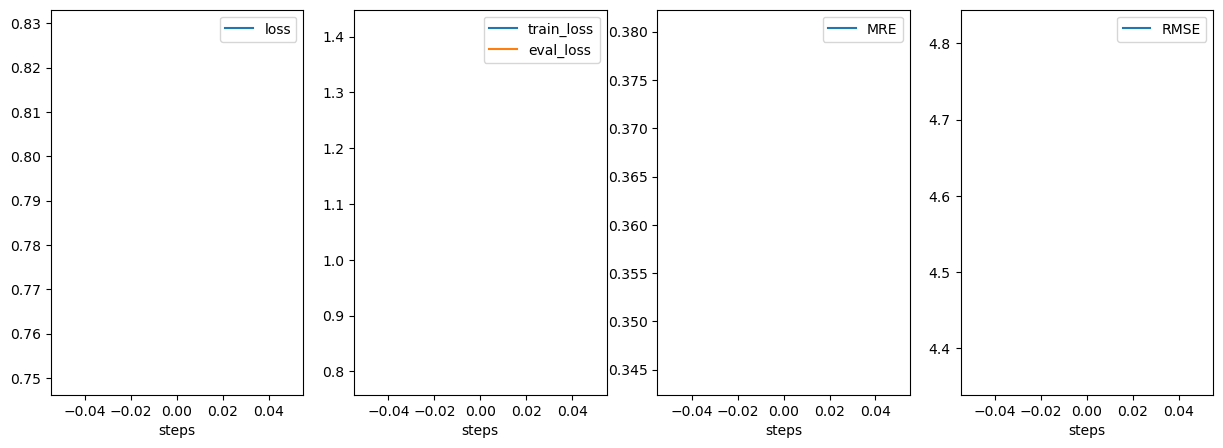

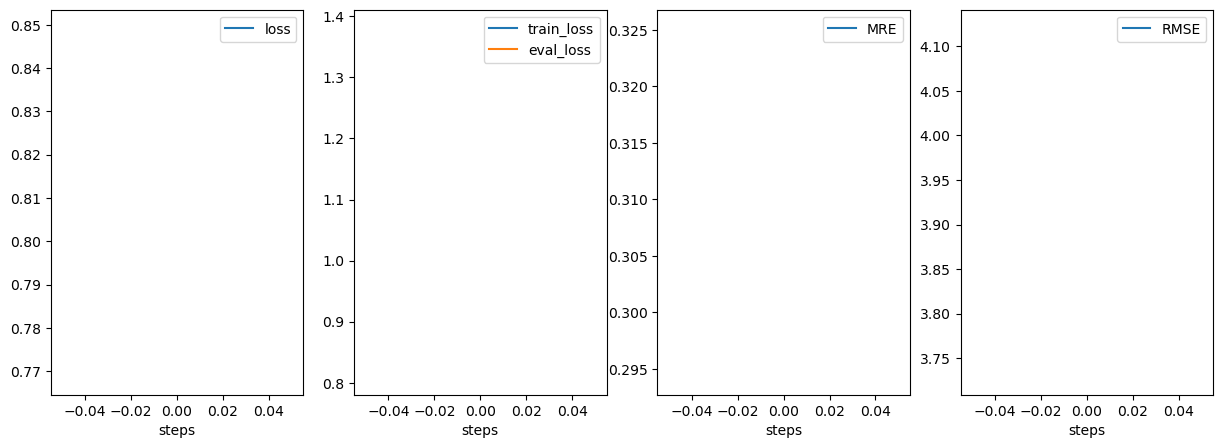

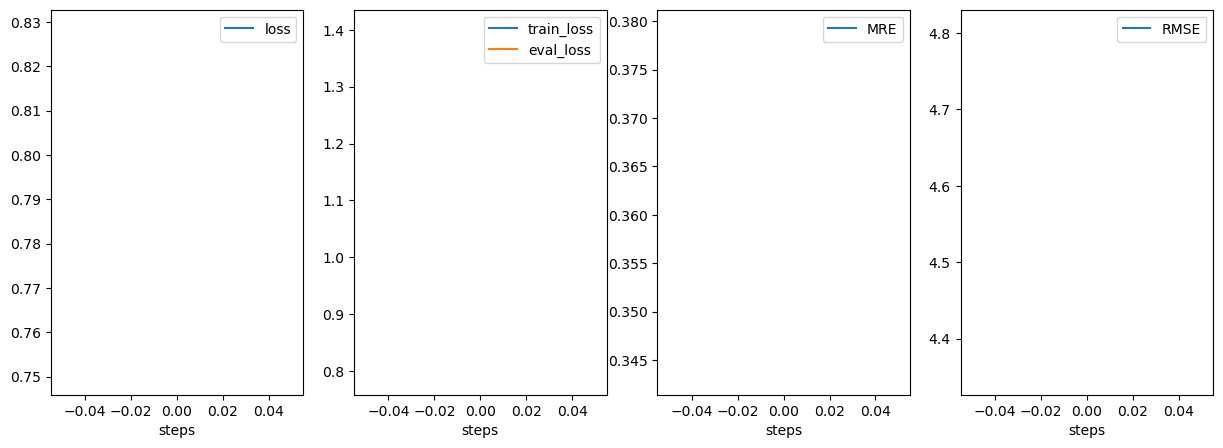

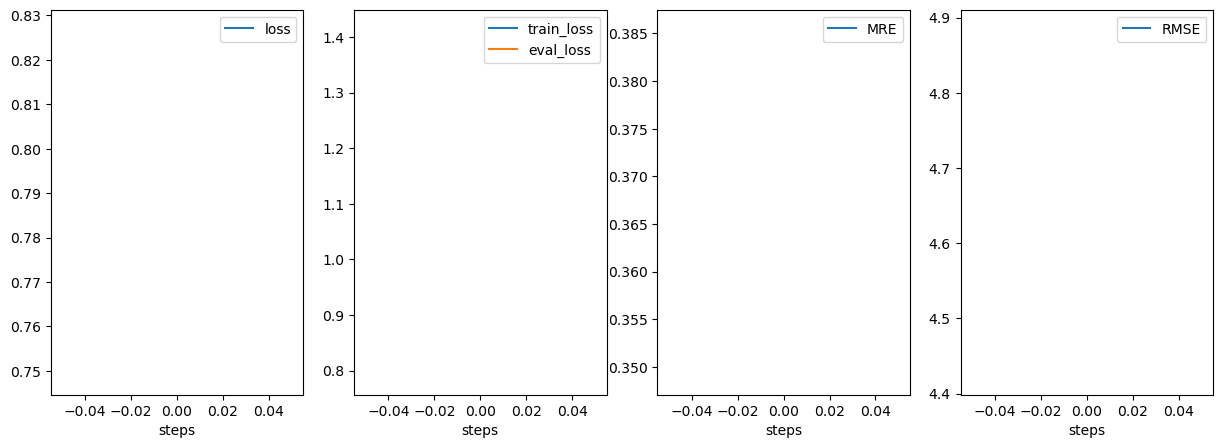

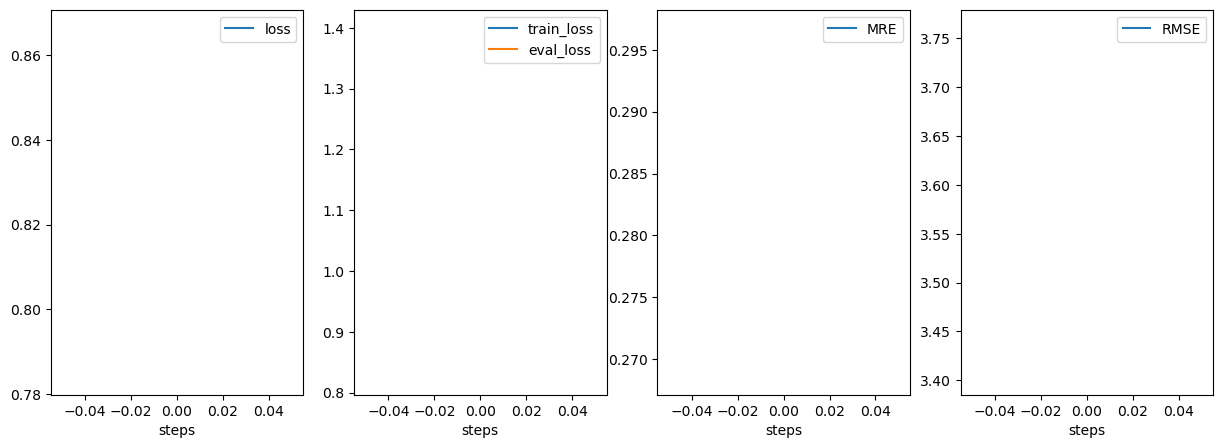

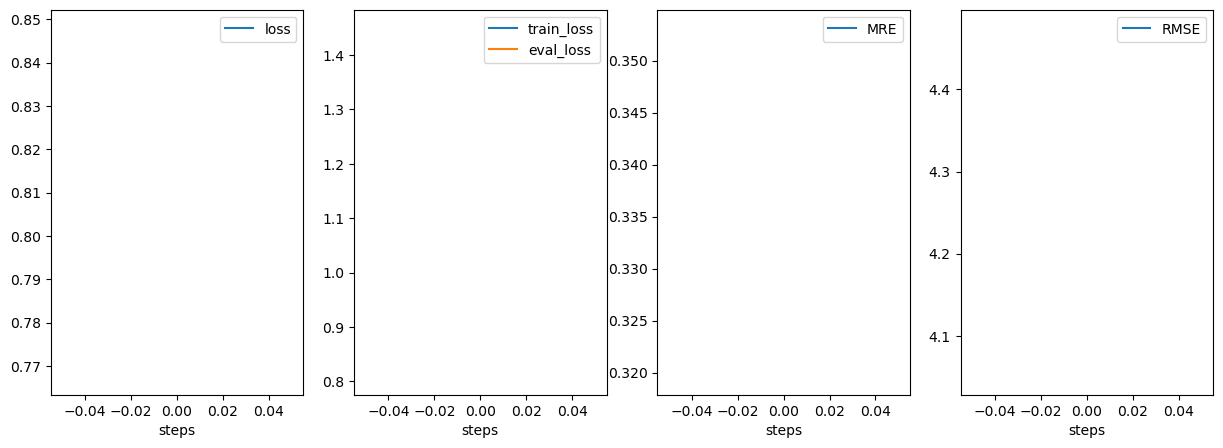

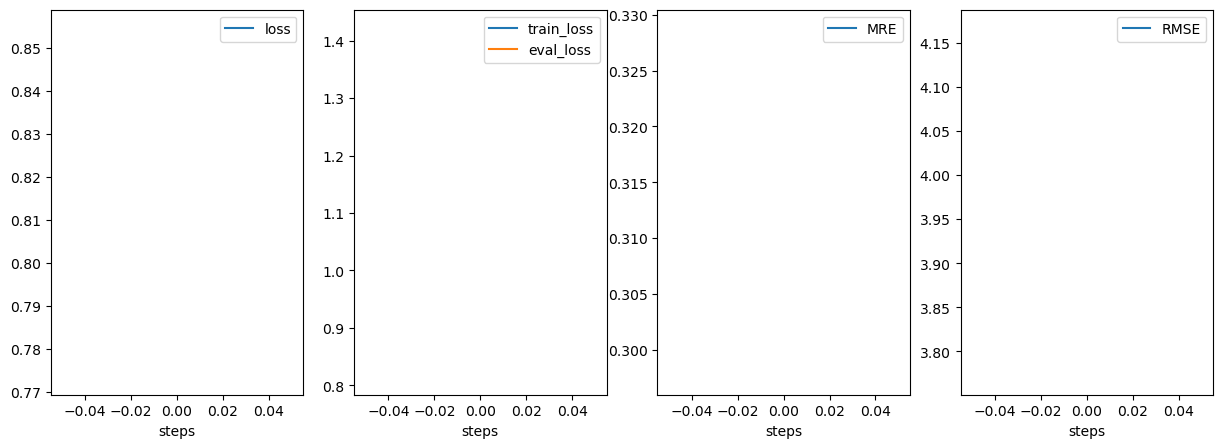

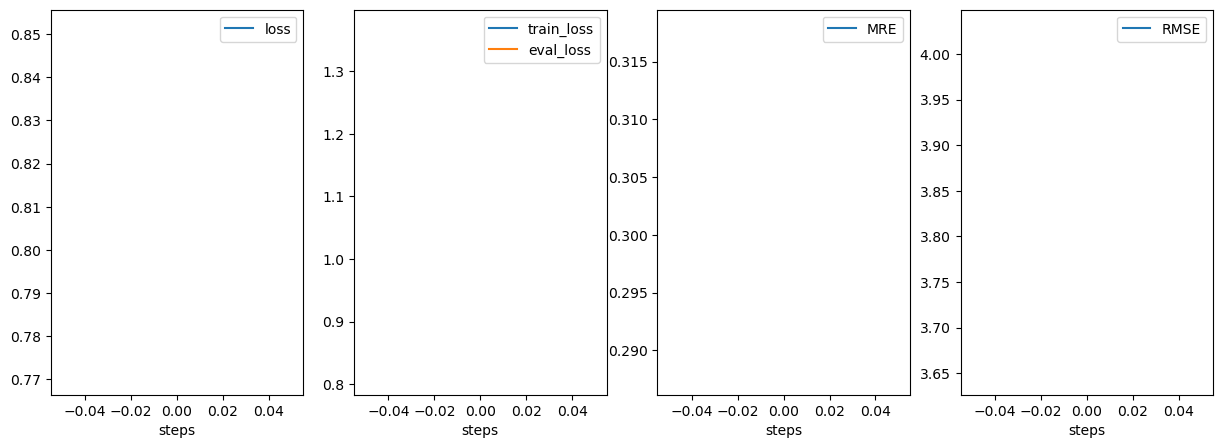

In [39]:
init_model_funcs = {
    ModelType.Transformer.name: init_Transformer_model,
    ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
    ModelType.GRU.name: init_GRU_model,
    ModelType.LSTM.name: init_LSTM_model,
    ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
    ModelType.RNN.name: init_RNN_model,
}

model_type = ModelType.LSTM
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)
grid_search_loop(model_type, 
                 conf, 
                 preprocessed_train_ds, 
                 preprocessed_eval_ds, 
                 compute_evaluate_metrics, 
                 to_device,
                 init_model,
                 )

